In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

def gaussian_noise(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.3
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

HR_test_path = '/content/gdrive/My Drive/DIV2K/DIV2K_valid_HR'
LR_test_path = '/content/gdrive/My Drive/DIV2K/DIV2K_valid_LR_bicubic/X4'
HR_train_path = '/content/gdrive/My Drive/DIV2K/DIV2K_train_HR'
LR_train_path = '/content/gdrive/My Drive/DIV2K/DIV2K_train_LR_bicubic/X4'  
HR_images = []
LR_images = []


for path in sorted(os.listdir(HR_test_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_valid_HR/' + path)
    img_hr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hr = cv2.resize(img_hr,(384,384))
    HR_images.append(img_hr)

for path in sorted(os.listdir(HR_train_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_train_HR/' + path)
    img_hr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_hr = cv2.resize(img_hr,(384,384))
    HR_images.append(img_hr)

for path in sorted(os.listdir(LR_test_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_valid_LR_bicubic/X4/' + path)
    img_lr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img_lr = cv2.GaussianBlur(img_lr, (5,5),0)
    img_lr = cv2.resize(img_lr,(96,96))
    #img_lr = gaussian_noise(img_lr)
    LR_images.append(img_lr)

for path in sorted(os.listdir(LR_train_path)):
    img = cv2.imread('/content/gdrive/My Drive/DIV2K/DIV2K_train_LR_bicubic/X4/' + path)
    img_lr = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img_lr = cv2.GaussianBlur(img_lr, (5,5),0)
    img_lr = cv2.resize(img_lr,(96,96))
    #img_lr = gaussian_noise(img_lr)
    LR_images.append(img_lr)

(-0.5, 95.5, 95.5, -0.5)

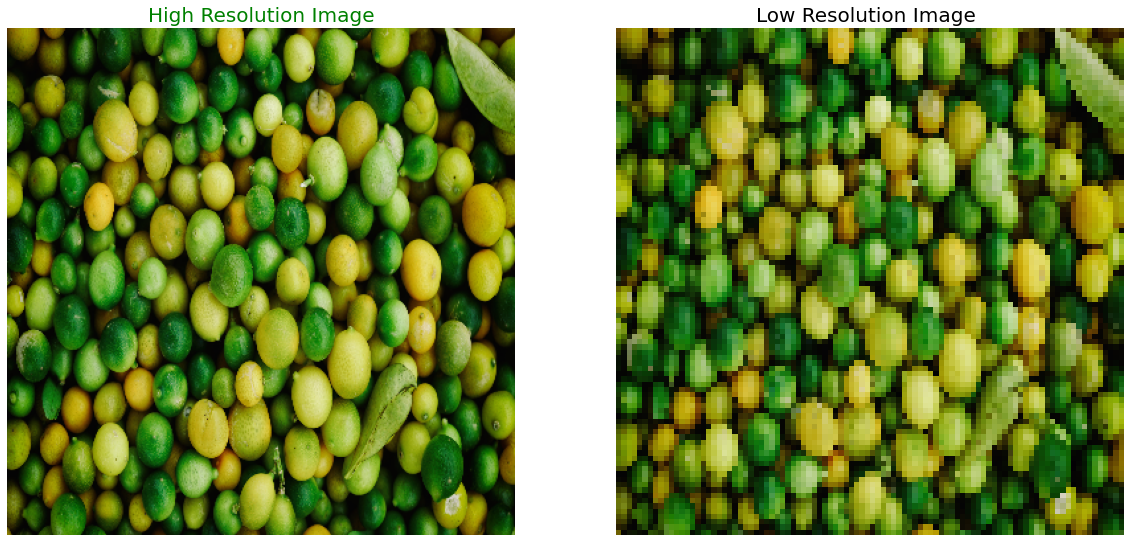

In [ ]:
a = np.random.randint(0,59)
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.title('High Resolution Image', color = 'green', fontsize = 20)
plt.imshow(HR_images[a])
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Low Resolution Image ', color = 'black', fontsize = 20)
plt.imshow(LR_images[a].astype('uint8'))
plt.axis('off')

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

#Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model


#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

from keras.applications.vgg19 import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [ ]:
lr_images = np.array(LR_images)
hr_images = np.array(HR_images)

In [ ]:
print(lr_images[0].shape)
print(hr_images[0].shape)

(96, 96, 3)
(384, 384, 3)


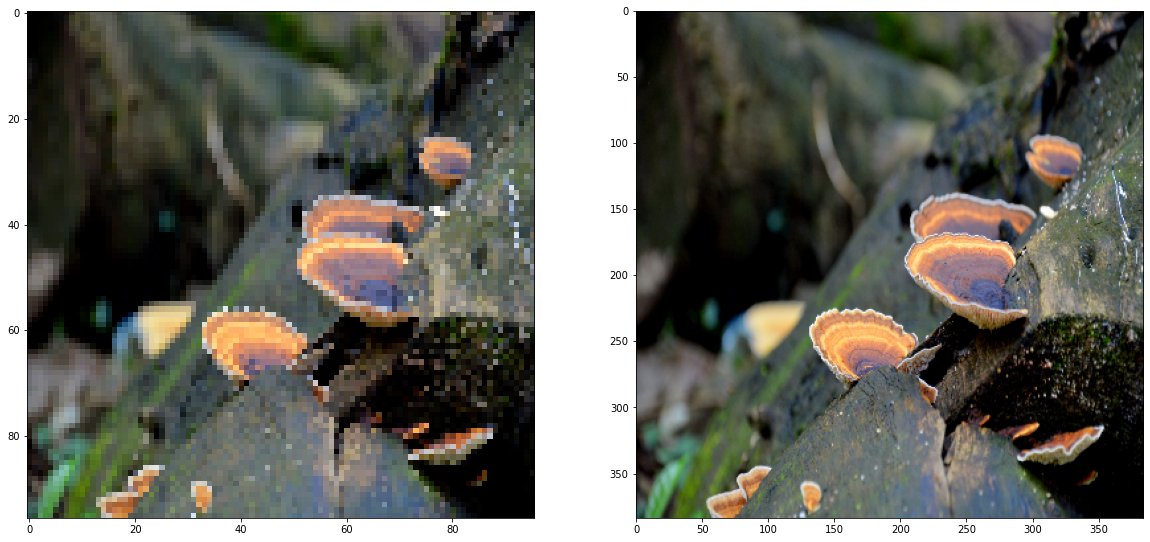

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.imshow(lr_images[image_number])
plt.subplot(122)
plt.imshow(hr_images[image_number])
plt.show()

In [ ]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)



hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

In [ ]:
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 96, 96, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 96, 96, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 96, 96, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [ ]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

discriminator = create_disc(hr_ip)
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.01, decay_steps=100, decay_rate=0.96
    )
)
discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
discriminator.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 conv2d_45 (Conv2D)          (None, 384, 384, 64)      1792      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 384, 384, 64)      0         
                                                                 
 conv2d_46 (Conv2D)          (None, 192, 192, 64)      36928     
                                                                 
 batch_normalization_40 (Bat  (None, 192, 192, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 192, 192, 64)      0         
                                                           

In [ ]:
vgg = build_vgg((384, 384, 3))
print(vgg.summary())
vgg.trainable = False

80134624/80134624 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 384, 384, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 384, 384, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 384, 384, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 192, 192, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 192, 192, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 192, 192, 128)     147584    
                                                            

In [ ]:


gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 


gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 384, 384, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_2 (Functional)           (None, 1)            306684737   ['model[0][0]']            

In [ ]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
epochs = 8
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 414ms/step


  0%|          | 1/603 [00:21<3:38:15, 21.75s/it]

1/1 [==============================] - 0s 23ms/step


  0%|          | 2/603 [00:22<1:33:32,  9.34s/it]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/603 [00:23<54:25,  5.44s/it]  

1/1 [==============================] - 0s 15ms/step


  1%|          | 4/603 [00:24<36:21,  3.64s/it]

1/1 [==============================] - 0s 17ms/step


  1%|          | 5/603 [00:24<25:18,  2.54s/it]

1/1 [==============================] - 0s 16ms/step


  1%|          | 6/603 [00:25<18:38,  1.87s/it]

1/1 [==============================] - 0s 16ms/step


  1%|          | 7/603 [00:25<14:26,  1.45s/it]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 8/603 [00:26<11:42,  1.18s/it]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 9/603 [00:27<09:51,  1.00it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 10/603 [00:27<08:39,  1.14it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 11/603 [00:28<07:53,  1.25it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 12/603 [00:28<07:15,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 13/603 [00:29<06:55,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 14/603 [00:30<06:33,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/603 [00:30<06:18,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 16/603 [00:31<06:07,  1.60it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 17/603 [00:31<06:07,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 18/603 [00:32<05:59,  1.63it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 19/603 [00:33<05:52,  1.66it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 20/603 [00:33<05:49,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 21/603 [00:34<05:48,  1.67it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▎         | 22/603 [00:34<05:44,  1.69it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 23/603 [00:35<05:44,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 24/603 [00:35<05:43,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 25/603 [00:36<05:42,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 26/603 [00:37<05:40,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 27/603 [00:37<05:39,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 28/603 [00:38<05:38,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 29/603 [00:38<05:37,  1.70it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 30/603 [00:39<05:38,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 31/603 [00:40<05:37,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 32/603 [00:40<05:37,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 33/603 [00:41<05:37,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▌         | 34/603 [00:41<05:36,  1.69it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 35/603 [00:42<05:36,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 36/603 [00:43<05:34,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 37/603 [00:43<05:34,  1.69it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▋         | 38/603 [00:44<05:33,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  6%|▋         | 39/603 [00:44<05:32,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 40/603 [00:45<05:33,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 41/603 [00:46<05:32,  1.69it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 42/603 [00:46<05:33,  1.68it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 43/603 [00:47<05:33,  1.68it/s]

1/1 [==============================] - 0s 21ms/step


  7%|▋         | 44/603 [00:47<05:34,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 45/603 [00:48<05:32,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 46/603 [00:49<05:30,  1.69it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 47/603 [00:49<05:29,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 48/603 [00:50<05:28,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 49/603 [00:50<05:28,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 50/603 [00:51<05:27,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 51/603 [00:51<05:26,  1.69it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 52/603 [00:52<05:26,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 53/603 [00:53<05:26,  1.69it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 54/603 [00:53<05:25,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 55/603 [00:54<05:24,  1.69it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 56/603 [00:54<05:24,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▉         | 57/603 [00:55<05:23,  1.69it/s]

1/1 [==============================] - 0s 15ms/step


 10%|▉         | 58/603 [00:56<05:26,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:56<05:25,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 60/603 [00:57<05:24,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 61/603 [00:58<06:13,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 62/603 [00:58<06:04,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 63/603 [00:59<06:00,  1.50it/s]

1/1 [==============================] - 0s 78ms/step


 11%|█         | 64/603 [01:00<06:28,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 65/603 [01:00<06:06,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 66/603 [01:01<05:52,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 67/603 [01:02<05:41,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 68/603 [01:02<05:33,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 69/603 [01:03<05:28,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 70/603 [01:03<05:31,  1.61it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 71/603 [01:04<05:26,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 72/603 [01:05<05:22,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/603 [01:05<05:18,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 74/603 [01:06<05:16,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 75/603 [01:06<05:15,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 76/603 [01:07<05:14,  1.68it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 77/603 [01:08<05:15,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [01:08<05:13,  1.67it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/603 [01:09<05:14,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 80/603 [01:09<05:12,  1.67it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 81/603 [01:10<05:56,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 82/603 [01:11<05:41,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 83/603 [01:12<05:35,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 84/603 [01:12<05:27,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 85/603 [01:13<05:22,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 86/603 [01:14<06:01,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 87/603 [01:14<05:44,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [01:15<05:34,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 89/603 [01:15<05:26,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 90/603 [01:16<05:19,  1.60it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▌        | 91/603 [01:17<05:14,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 92/603 [01:17<05:16,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 93/603 [01:18<05:12,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 94/603 [01:18<05:09,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▌        | 95/603 [01:19<05:06,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 96/603 [01:20<05:05,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 97/603 [01:20<05:03,  1.67it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 98/603 [01:21<05:47,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 99/603 [01:22<05:33,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 100/603 [01:22<05:22,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 101/603 [01:23<05:16,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 102/603 [01:23<05:10,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 103/603 [01:24<05:07,  1.63it/s]

1/1 [==============================] - 0s 15ms/step


 17%|█▋        | 104/603 [01:25<05:47,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 105/603 [01:26<05:31,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 106/603 [01:26<05:21,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 107/603 [01:27<05:14,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 108/603 [01:27<05:08,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 109/603 [01:28<05:05,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 110/603 [01:29<05:02,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 111/603 [01:29<05:00,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 112/603 [01:30<04:58,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▊        | 113/603 [01:30<04:56,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 114/603 [01:31<04:54,  1.66it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 115/603 [01:32<04:54,  1.66it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 116/603 [01:32<04:53,  1.66it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 117/603 [01:33<05:35,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 118/603 [01:34<05:22,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 119/603 [01:34<05:12,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 120/603 [01:35<05:05,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 121/603 [01:35<04:59,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 122/603 [01:36<04:55,  1.63it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 123/603 [01:37<04:53,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 124/603 [01:37<04:51,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 125/603 [01:38<04:49,  1.65it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██        | 126/603 [01:38<04:47,  1.66it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 127/603 [01:39<04:47,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 128/603 [01:40<04:47,  1.65it/s]

1/1 [==============================] - 0s 15ms/step


 21%|██▏       | 129/603 [01:40<04:46,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 130/603 [01:41<04:45,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 131/603 [01:42<04:44,  1.66it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 132/603 [01:42<04:44,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 133/603 [01:43<04:44,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 134/603 [01:43<04:43,  1.66it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 135/603 [01:44<04:46,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 136/603 [01:45<04:45,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 137/603 [01:45<04:45,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 138/603 [01:46<04:43,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 139/603 [01:46<04:48,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 140/603 [01:47<04:46,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 141/603 [01:48<04:45,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 142/603 [01:48<04:43,  1.63it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▎       | 143/603 [01:49<04:40,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 144/603 [01:49<04:39,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 145/603 [01:50<04:38,  1.65it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 146/603 [01:51<04:36,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 147/603 [01:51<04:38,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 148/603 [01:52<04:37,  1.64it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 149/603 [01:53<04:37,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 150/603 [01:53<04:41,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 151/603 [01:54<04:38,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 152/603 [01:54<04:36,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 153/603 [01:55<04:35,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 154/603 [01:56<04:33,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 155/603 [01:56<05:10,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 156/603 [01:57<04:58,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 157/603 [01:58<04:51,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 158/603 [01:58<04:44,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 159/603 [01:59<04:39,  1.59it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 160/603 [02:00<04:39,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [02:00<04:41,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 162/603 [02:01<04:36,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 163/603 [02:01<04:41,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 164/603 [02:02<04:35,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 165/603 [02:03<04:31,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 166/603 [02:03<04:30,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 167/603 [02:04<04:29,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 168/603 [02:05<04:27,  1.63it/s]

1/1 [==============================] - 0s 21ms/step


 28%|██▊       | 169/603 [02:05<04:25,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 170/603 [02:06<04:24,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 171/603 [02:06<04:23,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 172/603 [02:07<04:22,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▊       | 173/603 [02:08<04:22,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 174/603 [02:08<04:21,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 175/603 [02:09<04:20,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▉       | 176/603 [02:09<04:19,  1.65it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 177/603 [02:10<04:19,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/603 [02:11<04:18,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 179/603 [02:11<04:17,  1.64it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 180/603 [02:12<04:17,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 181/603 [02:12<04:16,  1.65it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 182/603 [02:13<04:15,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/603 [02:14<04:14,  1.65it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 184/603 [02:14<04:15,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 185/603 [02:15<04:13,  1.65it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 186/603 [02:15<04:14,  1.64it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 187/603 [02:16<04:13,  1.64it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 188/603 [02:17<04:13,  1.64it/s]

1/1 [==============================] - 0s 15ms/step


 31%|███▏      | 189/603 [02:18<04:48,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 190/603 [02:18<04:36,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 191/603 [02:19<04:28,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 192/603 [02:20<04:57,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 193/603 [02:20<04:42,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 194/603 [02:21<04:32,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 195/603 [02:22<04:59,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 196/603 [02:22<04:44,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 197/603 [02:23<04:32,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 198/603 [02:24<04:24,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 199/603 [02:24<04:18,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 200/603 [02:25<04:14,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 201/603 [02:25<04:11,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 202/603 [02:26<04:09,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 203/603 [02:27<04:07,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 204/603 [02:27<04:05,  1.63it/s]

1/1 [==============================] - 0s 15ms/step


 34%|███▍      | 205/603 [02:28<04:04,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 206/603 [02:29<04:04,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 207/603 [02:29<04:03,  1.63it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 208/603 [02:30<04:03,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 209/603 [02:30<04:02,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:31<04:01,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 211/603 [02:32<03:59,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 212/603 [02:32<03:59,  1.63it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 213/603 [02:33<04:03,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 214/603 [02:33<04:01,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 215/603 [02:34<04:00,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▌      | 216/603 [02:35<04:04,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:35<04:01,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 218/603 [02:36<03:59,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▋      | 219/603 [02:37<03:58,  1.61it/s]

1/1 [==============================] - 0s 21ms/step


 36%|███▋      | 220/603 [02:37<03:57,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 221/603 [02:38<03:56,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 222/603 [02:38<03:59,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 223/603 [02:39<03:57,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 224/603 [02:40<03:58,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 225/603 [02:40<04:01,  1.57it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 226/603 [02:41<04:01,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 227/603 [02:42<03:57,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 228/603 [02:42<03:55,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 229/603 [02:43<03:53,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 230/603 [02:44<03:51,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 231/603 [02:44<03:49,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 232/603 [02:45<03:48,  1.62it/s]

1/1 [==============================] - 0s 23ms/step


 39%|███▊      | 233/603 [02:45<03:51,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 234/603 [02:46<03:53,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 235/603 [02:47<03:50,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 236/603 [02:47<03:49,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 237/603 [02:48<03:51,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 238/603 [02:49<03:49,  1.59it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 239/603 [02:49<03:46,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 240/603 [02:50<03:45,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:51<04:13,  1.43it/s]

1/1 [==============================] - 0s 25ms/step


 40%|████      | 242/603 [02:51<04:04,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 243/603 [02:52<03:57,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 40%|████      | 244/603 [02:53<03:57,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 245/603 [02:53<03:51,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 246/603 [02:54<03:47,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [02:54<03:43,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 248/603 [02:55<03:41,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 249/603 [02:56<03:39,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████▏     | 250/603 [02:56<03:38,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 251/603 [02:57<03:37,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/603 [02:57<03:37,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 253/603 [02:58<03:36,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 254/603 [02:59<03:35,  1.62it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 255/603 [02:59<03:34,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 256/603 [03:00<03:33,  1.62it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 257/603 [03:01<03:33,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 258/603 [03:01<03:33,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 259/603 [03:02<03:32,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 260/603 [03:02<03:31,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 261/603 [03:03<03:30,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 262/603 [03:04<03:29,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 263/603 [03:04<03:28,  1.63it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 264/603 [03:05<03:28,  1.63it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 265/603 [03:05<03:28,  1.62it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 266/603 [03:06<03:28,  1.62it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 267/603 [03:07<03:27,  1.62it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 268/603 [03:07<03:27,  1.62it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 269/603 [03:08<03:26,  1.62it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 270/603 [03:09<03:26,  1.61it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 271/603 [03:09<03:25,  1.61it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 272/603 [03:10<03:29,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 273/603 [03:10<03:26,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 274/603 [03:11<03:24,  1.61it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 275/603 [03:12<03:27,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 276/603 [03:12<03:25,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:13<03:24,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 278/603 [03:14<03:22,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 279/603 [03:14<03:25,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 280/603 [03:15<03:23,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 281/603 [03:15<03:21,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 282/603 [03:16<03:20,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 283/603 [03:17<03:19,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 284/603 [03:17<03:17,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 285/603 [03:18<03:21,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 286/603 [03:19<03:22,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 287/603 [03:19<03:19,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 288/603 [03:20<03:17,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 289/603 [03:21<03:16,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 290/603 [03:21<03:14,  1.61it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 291/603 [03:22<03:15,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 292/603 [03:22<03:13,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 293/603 [03:23<03:12,  1.61it/s]

1/1 [==============================] - 0s 15ms/step


 49%|████▉     | 294/603 [03:24<03:12,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 295/603 [03:24<03:11,  1.61it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 296/603 [03:25<03:11,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 297/603 [03:26<03:14,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 298/603 [03:26<03:13,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 299/603 [03:27<03:11,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 300/603 [03:27<03:09,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 301/603 [03:28<03:08,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 302/603 [03:29<03:07,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 303/603 [03:29<03:06,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:30<03:05,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 305/603 [03:31<03:05,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:31<03:04,  1.61it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 307/603 [03:32<03:06,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 308/603 [03:32<03:04,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 309/603 [03:33<03:03,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 310/603 [03:34<03:02,  1.61it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 311/603 [03:34<03:02,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 312/603 [03:35<03:01,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 313/603 [03:36<03:01,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:36<03:03,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 315/603 [03:37<03:01,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 316/603 [03:37<03:03,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 317/603 [03:38<03:01,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 318/603 [03:39<02:59,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 319/603 [03:39<02:58,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 320/603 [03:40<03:00,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 321/603 [03:41<02:58,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 322/603 [03:41<02:57,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 323/603 [03:42<02:55,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 324/603 [03:42<02:56,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 325/603 [03:43<02:54,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 326/603 [03:44<02:53,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 327/603 [03:44<02:52,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 328/603 [03:45<02:51,  1.61it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 329/603 [03:46<02:50,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 330/603 [03:46<02:50,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 331/603 [03:47<02:52,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 332/603 [03:48<02:54,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 333/603 [03:48<02:52,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 55%|█████▌    | 334/603 [03:49<02:50,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 335/603 [03:49<02:49,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [03:50<02:47,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 337/603 [03:51<02:46,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 338/603 [03:51<02:45,  1.60it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 339/603 [03:52<02:44,  1.60it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▋    | 340/603 [03:53<02:44,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 341/603 [03:53<02:43,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 342/603 [03:54<02:42,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 343/603 [03:54<02:42,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 344/603 [03:55<02:41,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 345/603 [03:56<02:40,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 346/603 [03:56<02:40,  1.60it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 347/603 [03:57<02:43,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 348/603 [03:58<02:41,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 349/603 [03:58<02:40,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 350/603 [03:59<02:59,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 351/603 [04:00<02:52,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 352/603 [04:00<02:47,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 353/603 [04:01<02:43,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 354/603 [04:02<02:43,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 355/603 [04:02<02:40,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 356/603 [04:03<02:38,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 357/603 [04:04<02:38,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 59%|█████▉    | 358/603 [04:04<02:35,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 359/603 [04:05<02:34,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 360/603 [04:05<02:35,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 361/603 [04:06<02:34,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 362/603 [04:07<02:35,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 363/603 [04:07<02:35,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 364/603 [04:08<02:34,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 365/603 [04:09<02:32,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 366/603 [04:09<02:30,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 367/603 [04:10<02:29,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 368/603 [04:11<02:27,  1.59it/s]

1/1 [==============================] - 0s 15ms/step


 61%|██████    | 369/603 [04:11<02:26,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████▏   | 370/603 [04:12<02:25,  1.60it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 371/603 [04:12<02:24,  1.60it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 372/603 [04:13<02:24,  1.60it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 373/603 [04:14<02:27,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 374/603 [04:14<02:30,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 375/603 [04:15<02:30,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:16<02:27,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 377/603 [04:16<02:25,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 378/603 [04:17<02:26,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 379/603 [04:18<02:24,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 380/603 [04:18<02:22,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 381/603 [04:19<02:23,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:20<02:21,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 383/603 [04:20<02:23,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 384/603 [04:21<02:20,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 385/603 [04:21<02:18,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 386/603 [04:22<02:17,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 387/603 [04:23<02:16,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 388/603 [04:23<02:16,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▍   | 389/603 [04:24<02:17,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:25<02:15,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 391/603 [04:25<02:14,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 392/603 [04:26<02:13,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 393/603 [04:26<02:12,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 394/603 [04:27<02:11,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 395/603 [04:28<02:11,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 396/603 [04:28<02:10,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 397/603 [04:29<02:09,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 398/603 [04:30<02:08,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 399/603 [04:30<02:08,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 400/603 [04:31<02:10,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/603 [04:32<02:08,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 402/603 [04:32<02:09,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 403/603 [04:33<02:08,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 67%|██████▋   | 404/603 [04:33<02:06,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:34<02:05,  1.58it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 406/603 [04:35<02:04,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 407/603 [04:35<02:03,  1.59it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 408/603 [04:36<02:03,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 409/603 [04:37<02:02,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 410/603 [04:37<02:01,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 411/603 [04:38<02:00,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 412/603 [04:39<02:00,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 413/603 [04:39<01:59,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [04:40<01:58,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 415/603 [04:40<01:58,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 416/603 [04:41<01:57,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 417/603 [04:42<01:56,  1.59it/s]

1/1 [==============================] - 0s 22ms/step


 69%|██████▉   | 418/603 [04:42<01:56,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 419/603 [04:43<01:55,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 420/603 [04:44<01:57,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 70%|██████▉   | 421/603 [04:44<01:55,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 422/603 [04:45<01:54,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 423/603 [04:45<01:54,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 424/603 [04:46<01:53,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 425/603 [04:47<02:06,  1.40it/s]

1/1 [==============================] - 0s 24ms/step


 71%|███████   | 426/603 [04:48<02:02,  1.45it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████   | 427/603 [04:48<02:00,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 428/603 [04:49<01:56,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 429/603 [04:50<01:55,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 71%|███████▏  | 430/603 [04:50<01:54,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [04:51<01:51,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 432/603 [04:52<01:50,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 433/603 [04:52<01:48,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 434/603 [04:53<01:47,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 435/603 [04:53<01:48,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 436/603 [04:54<01:47,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 437/603 [04:55<01:45,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 438/603 [04:55<01:46,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 439/603 [04:56<01:45,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 440/603 [04:57<01:43,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 441/603 [04:57<01:44,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 442/603 [04:58<01:43,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 443/603 [04:59<01:42,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▎  | 444/603 [04:59<01:41,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/603 [05:00<01:40,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 446/603 [05:00<01:39,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 447/603 [05:01<01:39,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 448/603 [05:02<01:38,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 449/603 [05:02<01:37,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 450/603 [05:03<01:39,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 451/603 [05:04<01:38,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 452/603 [05:04<01:38,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 75%|███████▌  | 453/603 [05:05<01:36,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 454/603 [05:06<01:35,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 455/603 [05:06<01:33,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 456/603 [05:07<01:32,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 457/603 [05:08<01:33,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 458/603 [05:08<01:32,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 459/603 [05:09<01:31,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 460/603 [05:09<01:30,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 461/603 [05:10<01:30,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 77%|███████▋  | 462/603 [05:11<01:29,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 463/603 [05:11<01:28,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 464/603 [05:12<01:29,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:13<01:28,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 466/603 [05:13<01:27,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 467/603 [05:14<01:26,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 468/603 [05:15<01:26,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 469/603 [05:15<01:25,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 470/603 [05:16<01:24,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 471/603 [05:16<01:23,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 472/603 [05:17<01:23,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 473/603 [05:18<01:22,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 474/603 [05:18<01:22,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 475/603 [05:19<01:21,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 476/603 [05:20<01:22,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 477/603 [05:20<01:21,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


 79%|███████▉  | 478/603 [05:21<01:21,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 479/603 [05:22<01:19,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 480/603 [05:22<01:18,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 481/603 [05:23<01:17,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 482/603 [05:23<01:17,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 483/603 [05:24<01:15,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 484/603 [05:25<01:16,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 485/603 [05:25<01:15,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 486/603 [05:26<01:14,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 487/603 [05:27<01:13,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 488/603 [05:27<01:12,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 489/603 [05:28<01:11,  1.59it/s]

1/1 [==============================] - 0s 21ms/step


 81%|████████▏ | 490/603 [05:29<01:11,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 491/603 [05:29<01:10,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 492/603 [05:30<01:10,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 493/603 [05:30<01:09,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 494/603 [05:31<01:08,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 495/603 [05:32<01:08,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 496/603 [05:32<01:07,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 497/603 [05:33<01:06,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 498/603 [05:34<01:05,  1.60it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 499/603 [05:34<01:05,  1.59it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 500/603 [05:35<01:04,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [05:35<01:05,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 502/603 [05:36<01:04,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 503/603 [05:37<01:11,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 504/603 [05:38<01:08,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 505/603 [05:38<01:05,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 506/603 [05:39<01:04,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/603 [05:40<01:04,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 508/603 [05:40<01:02,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 509/603 [05:41<01:00,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 510/603 [05:42<01:00,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 511/603 [05:42<01:00,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 512/603 [05:43<00:59,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 85%|████████▌ | 513/603 [05:43<00:58,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 85%|████████▌ | 514/603 [05:44<00:57,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 515/603 [05:45<00:56,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 516/603 [05:45<00:55,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 517/603 [05:46<00:55,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 518/603 [05:47<00:55,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 519/603 [05:47<00:54,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 520/603 [05:48<00:53,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▋ | 521/603 [05:49<00:53,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 522/603 [05:49<00:52,  1.56it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 523/603 [05:50<00:52,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [05:51<00:50,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 525/603 [05:51<00:50,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 526/603 [05:52<00:49,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 527/603 [05:52<00:48,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 528/603 [05:53<00:49,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 88%|████████▊ | 529/603 [05:54<00:48,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/603 [05:54<00:47,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 531/603 [05:55<00:46,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 532/603 [05:56<00:45,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [05:56<00:44,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 534/603 [05:57<00:43,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▊ | 535/603 [05:58<00:43,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 536/603 [05:58<00:42,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 537/603 [05:59<00:42,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [06:00<00:42,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [06:00<00:41,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 540/603 [06:01<00:40,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 541/603 [06:02<00:40,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 542/603 [06:02<00:39,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 543/603 [06:03<00:38,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 90%|█████████ | 544/603 [06:03<00:37,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 545/603 [06:04<00:36,  1.58it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████ | 546/603 [06:05<00:35,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 547/603 [06:05<00:35,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:06<00:34,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 549/603 [06:07<00:33,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 550/603 [06:07<00:33,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████▏| 551/603 [06:08<00:33,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 552/603 [06:08<00:32,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 553/603 [06:09<00:31,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 554/603 [06:10<00:30,  1.59it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 555/603 [06:10<00:30,  1.59it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 556/603 [06:11<00:29,  1.59it/s]

1/1 [==============================] - 0s 15ms/step


 92%|█████████▏| 557/603 [06:12<00:28,  1.59it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 558/603 [06:12<00:28,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:13<00:27,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 560/603 [06:14<00:27,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 561/603 [06:14<00:27,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 562/603 [06:15<00:26,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 563/603 [06:15<00:25,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 564/603 [06:16<00:24,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 565/603 [06:17<00:24,  1.55it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 566/603 [06:17<00:23,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 567/603 [06:18<00:23,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 94%|█████████▍| 568/603 [06:19<00:22,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 569/603 [06:19<00:22,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▍| 570/603 [06:20<00:21,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 571/603 [06:21<00:20,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 572/603 [06:21<00:19,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 573/603 [06:22<00:18,  1.58it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 574/603 [06:22<00:18,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 575/603 [06:23<00:19,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 576/603 [06:24<00:18,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 577/603 [06:25<00:17,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 578/603 [06:25<00:16,  1.52it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 579/603 [06:26<00:15,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 580/603 [06:27<00:14,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 581/603 [06:27<00:14,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 582/603 [06:28<00:13,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 583/603 [06:28<00:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 584/603 [06:29<00:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 585/603 [06:30<00:11,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 586/603 [06:30<00:11,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 587/603 [06:31<00:10,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 588/603 [06:32<00:09,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 589/603 [06:32<00:09,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 590/603 [06:33<00:08,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 591/603 [06:34<00:07,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 592/603 [06:34<00:07,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 593/603 [06:35<00:06,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 594/603 [06:36<00:05,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 595/603 [06:36<00:05,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 99%|█████████▉| 596/603 [06:37<00:04,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 597/603 [06:38<00:03,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 598/603 [06:38<00:03,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 599/603 [06:39<00:02,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 600/603 [06:40<00:01,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 601/603 [06:40<00:01,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [06:41<00:00,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 603/603 [06:42<00:00,  1.50it/s]


epoch: 1 g_loss: 71.5144030205646 d_loss: [1.40381242 0.47927032]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 1/603 [00:00<07:27,  1.35it/s]

1/1 [==============================] - 0s 22ms/step


  0%|          | 2/603 [00:01<06:49,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 3/603 [00:02<07:48,  1.28it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 4/603 [00:03<08:14,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 5/603 [00:03<07:30,  1.33it/s]

1/1 [==============================] - 0s 15ms/step


  1%|          | 6/603 [00:04<07:06,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 7/603 [00:05<06:49,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 8/603 [00:05<06:44,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 9/603 [00:06<06:37,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 10/603 [00:07<06:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 11/603 [00:07<06:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 12/603 [00:08<06:23,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 13/603 [00:09<07:15,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 14/603 [00:09<06:53,  1.42it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 15/603 [00:10<06:39,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 16/603 [00:11<06:30,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 17/603 [00:11<06:23,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 18/603 [00:12<06:18,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 19/603 [00:13<06:13,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 20/603 [00:13<06:59,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 21/603 [00:14<06:42,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 22/603 [00:15<06:38,  1.46it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 23/603 [00:15<06:27,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 24/603 [00:16<06:19,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 25/603 [00:17<06:17,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 26/603 [00:17<06:25,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 27/603 [00:18<06:19,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 28/603 [00:19<06:16,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 29/603 [00:19<06:17,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 30/603 [00:20<06:12,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 31/603 [00:21<06:08,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 32/603 [00:21<06:05,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 33/603 [00:22<06:13,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 34/603 [00:22<06:08,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 35/603 [00:23<06:04,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 36/603 [00:24<06:08,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 37/603 [00:24<06:11,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 38/603 [00:25<06:07,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 39/603 [00:26<06:09,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 40/603 [00:26<06:05,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 41/603 [00:27<06:55,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 42/603 [00:28<06:35,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 43/603 [00:29<06:29,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:29<06:18,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 45/603 [00:30<06:15,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 46/603 [00:31<06:14,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 47/603 [00:31<06:06,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 48/603 [00:32<06:06,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 49/603 [00:33<06:04,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 50/603 [00:33<06:00,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 51/603 [00:34<06:02,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 52/603 [00:34<05:57,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 53/603 [00:35<05:54,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 54/603 [00:36<05:51,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 55/603 [00:36<05:49,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 56/603 [00:37<06:34,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 57/603 [00:38<06:17,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 58/603 [00:39<06:06,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 59/603 [00:39<05:58,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 60/603 [00:40<05:58,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 61/603 [00:40<05:53,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 62/603 [00:41<05:55,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 63/603 [00:42<05:49,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 64/603 [00:42<05:46,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 65/603 [00:43<05:47,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:44<05:46,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 67/603 [00:44<05:49,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 68/603 [00:45<05:45,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 69/603 [00:46<05:44,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 70/603 [00:46<05:40,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 71/603 [00:47<05:42,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 72/603 [00:48<05:38,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 73/603 [00:48<05:36,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 74/603 [00:49<05:35,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 12%|█▏        | 75/603 [00:49<05:38,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 76/603 [00:50<05:36,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 77/603 [00:51<05:36,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 78/603 [00:51<05:34,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/603 [00:52<05:33,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 80/603 [00:53<05:36,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 81/603 [00:53<05:40,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▎        | 82/603 [00:54<05:37,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 83/603 [00:55<05:33,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 84/603 [00:55<05:31,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 85/603 [00:56<05:30,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 14%|█▍        | 86/603 [00:56<05:28,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 87/603 [00:57<05:25,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [00:58<05:30,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 89/603 [00:59<06:15,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 90/603 [00:59<05:58,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 91/603 [01:00<05:47,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 92/603 [01:01<05:45,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 93/603 [01:01<05:38,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 94/603 [01:02<05:34,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 95/603 [01:03<05:30,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 96/603 [01:03<05:26,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 97/603 [01:04<05:23,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 16%|█▋        | 98/603 [01:04<05:22,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 99/603 [01:05<05:21,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 100/603 [01:06<05:20,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 101/603 [01:06<05:19,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 102/603 [01:07<05:22,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 103/603 [01:08<05:20,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 17%|█▋        | 104/603 [01:08<05:17,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 105/603 [01:09<05:16,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 106/603 [01:10<05:20,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 107/603 [01:10<05:16,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 108/603 [01:11<05:15,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 109/603 [01:11<05:19,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 110/603 [01:12<05:33,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 111/603 [01:13<05:26,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 19%|█▊        | 112/603 [01:13<05:20,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 113/603 [01:14<05:18,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 114/603 [01:15<05:17,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 115/603 [01:15<05:14,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 19%|█▉        | 116/603 [01:16<05:17,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 117/603 [01:17<05:18,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/603 [01:17<05:14,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 119/603 [01:18<05:14,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 120/603 [01:19<05:11,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:19<05:08,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 20%|██        | 122/603 [01:20<05:05,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 123/603 [01:21<05:04,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 124/603 [01:21<05:09,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 125/603 [01:22<05:45,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 126/603 [01:23<05:35,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 127/603 [01:23<05:24,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 128/603 [01:24<05:17,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 129/603 [01:25<05:11,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 130/603 [01:25<05:07,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 131/603 [01:26<05:03,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 22%|██▏       | 132/603 [01:27<04:59,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 133/603 [01:27<04:57,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 134/603 [01:28<04:56,  1.58it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 135/603 [01:28<04:56,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 136/603 [01:29<05:00,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 137/603 [01:30<04:58,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 138/603 [01:30<04:57,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 139/603 [01:31<04:54,  1.58it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 140/603 [01:32<04:53,  1.57it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 141/603 [01:32<04:52,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 142/603 [01:33<04:56,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 143/603 [01:34<04:55,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▍       | 144/603 [01:34<04:55,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 145/603 [01:35<04:54,  1.56it/s]

1/1 [==============================] - 0s 22ms/step


 24%|██▍       | 146/603 [01:36<04:57,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


 24%|██▍       | 147/603 [01:36<04:58,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 148/603 [01:37<04:54,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:37<04:51,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 150/603 [01:38<04:49,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 25%|██▌       | 151/603 [01:39<04:48,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 152/603 [01:39<04:51,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 153/603 [01:40<04:48,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 154/603 [01:41<04:47,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 155/603 [01:41<04:50,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 156/603 [01:42<04:47,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 157/603 [01:43<04:50,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 158/603 [01:43<04:46,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▋       | 159/603 [01:44<04:44,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 160/603 [01:45<04:48,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 27%|██▋       | 161/603 [01:45<04:44,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 162/603 [01:46<04:42,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 163/603 [01:46<04:40,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 164/603 [01:47<04:39,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 165/603 [01:48<04:42,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 28%|██▊       | 166/603 [01:48<04:40,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 167/603 [01:49<04:40,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 168/603 [01:50<04:43,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 169/603 [01:50<04:39,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 170/603 [01:51<04:37,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 171/603 [01:52<04:35,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 172/603 [01:52<04:38,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 29%|██▊       | 173/603 [01:53<04:35,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 174/603 [01:54<04:38,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 175/603 [01:54<04:40,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 176/603 [01:55<04:38,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 177/603 [01:56<04:35,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 178/603 [01:56<04:32,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 179/603 [01:57<04:30,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 180/603 [01:57<04:29,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 181/603 [01:58<04:31,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 182/603 [01:59<04:29,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/603 [01:59<04:28,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 184/603 [02:00<04:27,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 185/603 [02:01<05:00,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 186/603 [02:01<04:48,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 187/603 [02:02<04:40,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 188/603 [02:03<04:34,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 189/603 [02:03<04:30,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 190/603 [02:04<04:28,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 191/603 [02:05<04:25,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 192/603 [02:05<04:24,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 193/603 [02:06<04:24,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 194/603 [02:07<04:21,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 195/603 [02:07<04:19,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 196/603 [02:08<04:17,  1.58it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 197/603 [02:08<04:16,  1.58it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 198/603 [02:09<04:20,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 199/603 [02:10<04:17,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 33%|███▎      | 200/603 [02:10<04:19,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 201/603 [02:11<04:18,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 202/603 [02:12<04:21,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 203/603 [02:12<04:18,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 204/603 [02:13<04:16,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 205/603 [02:14<04:14,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 206/603 [02:14<04:17,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 207/603 [02:15<04:19,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 208/603 [02:16<04:16,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 209/603 [02:16<04:18,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 210/603 [02:17<04:18,  1.52it/s]

1/1 [==============================] - 0s 15ms/step


 35%|███▍      | 211/603 [02:18<04:14,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 212/603 [02:18<04:15,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 213/603 [02:19<04:12,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 214/603 [02:19<04:09,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 215/603 [02:20<04:08,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 216/603 [02:21<04:06,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 217/603 [02:21<04:06,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 218/603 [02:22<04:09,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


 36%|███▋      | 219/603 [02:23<04:06,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 220/603 [02:23<04:08,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 221/603 [02:24<04:05,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 222/603 [02:25<04:03,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 37%|███▋      | 223/603 [02:25<04:02,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 224/603 [02:26<04:01,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 225/603 [02:27<04:00,  1.57it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 226/603 [02:27<04:03,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 227/603 [02:28<04:00,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 228/603 [02:28<03:58,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 229/603 [02:29<03:58,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 230/603 [02:30<03:57,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 231/603 [02:30<04:00,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 232/603 [02:31<03:58,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 233/603 [02:32<03:57,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 234/603 [02:32<03:56,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 235/603 [02:33<03:55,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 236/603 [02:34<04:27,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 237/603 [02:35<04:14,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▉      | 238/603 [02:35<04:06,  1.48it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 239/603 [02:36<04:04,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 240/603 [02:36<03:59,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:37<03:56,  1.53it/s]

1/1 [==============================] - 0s 15ms/step


 40%|████      | 242/603 [02:38<03:54,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 243/603 [02:38<03:51,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [02:39<03:49,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 245/603 [02:40<03:51,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 246/603 [02:40<03:52,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 247/603 [02:41<03:50,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 41%|████      | 248/603 [02:42<03:47,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 249/603 [02:42<03:51,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████▏     | 250/603 [02:43<03:49,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 251/603 [02:44<03:47,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 252/603 [02:44<03:45,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 253/603 [02:45<03:47,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 254/603 [02:45<03:45,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 255/603 [02:46<03:44,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 256/603 [02:47<03:43,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 257/603 [02:47<03:45,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 258/603 [02:48<03:47,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 259/603 [02:49<03:43,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 260/603 [02:49<03:41,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 261/603 [02:50<03:39,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 262/603 [02:51<03:37,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 263/603 [02:51<03:37,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 264/603 [02:52<03:39,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 265/603 [02:53<03:37,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 266/603 [02:53<03:35,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 267/603 [02:54<03:33,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 268/603 [02:54<03:36,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 269/603 [02:55<03:34,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 270/603 [02:56<03:32,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 271/603 [02:56<03:30,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 272/603 [02:57<03:30,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 273/603 [02:58<03:32,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 274/603 [02:58<03:30,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 275/603 [02:59<03:29,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 276/603 [03:00<03:28,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 277/603 [03:00<03:27,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


 46%|████▌     | 278/603 [03:01<03:25,  1.58it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 279/603 [03:01<03:26,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 280/603 [03:02<03:28,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 281/603 [03:03<03:26,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 282/603 [03:03<03:28,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 283/603 [03:04<03:29,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 284/603 [03:05<03:26,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 285/603 [03:05<03:27,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 286/603 [03:06<03:28,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 287/603 [03:07<03:25,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 288/603 [03:07<03:23,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 289/603 [03:08<03:21,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 290/603 [03:09<03:19,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 291/603 [03:09<03:19,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 292/603 [03:10<03:45,  1.38it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▊     | 293/603 [03:11<03:35,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 294/603 [03:11<03:29,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 295/603 [03:12<03:24,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 296/603 [03:13<03:24,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 297/603 [03:13<03:20,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 298/603 [03:14<03:20,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 299/603 [03:15<03:17,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 300/603 [03:15<03:14,  1.55it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 301/603 [03:16<03:20,  1.51it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 302/603 [03:17<03:27,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 303/603 [03:17<03:24,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:18<03:22,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 305/603 [03:19<03:23,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:19<03:18,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 307/603 [03:20<03:15,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 308/603 [03:21<03:11,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 309/603 [03:21<03:12,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 310/603 [03:22<03:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 311/603 [03:23<03:15,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 312/603 [03:23<03:15,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 313/603 [03:24<03:14,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 52%|█████▏    | 314/603 [03:25<03:10,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 315/603 [03:25<03:06,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 316/603 [03:26<03:04,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 317/603 [03:27<03:06,  1.53it/s]

1/1 [==============================] - 0s 15ms/step


 53%|█████▎    | 318/603 [03:27<03:04,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 319/603 [03:28<03:05,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 320/603 [03:29<03:02,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 321/603 [03:29<03:01,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 322/603 [03:30<03:03,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 323/603 [03:31<03:04,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 324/603 [03:31<03:04,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 325/603 [03:32<03:01,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/603 [03:32<02:59,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 327/603 [03:33<02:57,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 328/603 [03:34<02:59,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 329/603 [03:35<03:20,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 330/603 [03:35<03:13,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 331/603 [03:36<03:07,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 332/603 [03:37<03:02,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 333/603 [03:37<02:58,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 334/603 [03:38<02:57,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 335/603 [03:39<02:57,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [03:39<02:54,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 337/603 [03:40<02:53,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 338/603 [03:40<02:52,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 339/603 [03:41<02:51,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 340/603 [03:42<02:52,  1.52it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 341/603 [03:43<02:55,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 342/603 [03:43<02:58,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 343/603 [03:44<03:00,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 344/603 [03:45<02:56,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 57%|█████▋    | 345/603 [03:45<02:52,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 346/603 [03:46<02:52,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 347/603 [03:47<02:49,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 348/603 [03:47<02:46,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 349/603 [03:48<03:08,  1.35it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████▊    | 350/603 [03:49<03:17,  1.28it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 351/603 [03:50<03:13,  1.30it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 352/603 [03:50<03:03,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 353/603 [03:51<02:56,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 354/603 [03:52<02:53,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 355/603 [03:52<02:51,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 356/603 [03:53<02:47,  1.47it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 357/603 [03:54<02:46,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 358/603 [03:54<02:46,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 359/603 [03:55<02:44,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 360/603 [03:56<02:42,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 361/603 [03:56<02:41,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 362/603 [03:57<02:38,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 363/603 [03:58<02:37,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 364/603 [03:58<02:35,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 365/603 [03:59<02:34,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 366/603 [04:00<02:35,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 367/603 [04:00<02:35,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 368/603 [04:01<02:35,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 369/603 [04:02<02:36,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████▏   | 370/603 [04:02<02:37,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 371/603 [04:03<02:37,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:04<02:35,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 373/603 [04:04<02:34,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 374/603 [04:05<02:33,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 375/603 [04:06<02:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:06<02:32,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 377/603 [04:07<02:29,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 378/603 [04:08<02:29,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 379/603 [04:08<02:29,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 380/603 [04:09<02:28,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 381/603 [04:10<02:30,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:10<02:27,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 383/603 [04:11<02:27,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 384/603 [04:12<02:26,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 385/603 [04:12<02:25,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 386/603 [04:13<02:28,  1.46it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 387/603 [04:14<02:33,  1.41it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 388/603 [04:15<02:35,  1.38it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 389/603 [04:15<02:37,  1.36it/s]

1/1 [==============================] - 0s 40ms/step


 65%|██████▍   | 390/603 [04:16<02:39,  1.33it/s]

1/1 [==============================] - 0s 41ms/step


 65%|██████▍   | 391/603 [04:17<02:38,  1.33it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 392/603 [04:18<02:37,  1.34it/s]

1/1 [==============================] - 0s 35ms/step


 65%|██████▌   | 393/603 [04:18<02:35,  1.35it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 394/603 [04:19<02:33,  1.36it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▌   | 395/603 [04:20<02:31,  1.37it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 396/603 [04:21<02:30,  1.37it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 397/603 [04:21<02:30,  1.37it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 398/603 [04:22<02:31,  1.35it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 399/603 [04:23<02:31,  1.34it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▋   | 400/603 [04:24<02:29,  1.35it/s]

1/1 [==============================] - 0s 31ms/step


 67%|██████▋   | 401/603 [04:24<02:27,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 402/603 [04:25<02:26,  1.37it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 403/603 [04:26<02:25,  1.37it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 404/603 [04:26<02:25,  1.37it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 405/603 [04:27<02:24,  1.37it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 406/603 [04:28<02:25,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 407/603 [04:29<02:25,  1.35it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 408/603 [04:29<02:27,  1.32it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 409/603 [04:30<02:28,  1.31it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 410/603 [04:31<02:41,  1.20it/s]

1/1 [==============================] - 0s 34ms/step


 68%|██████▊   | 411/603 [04:32<02:32,  1.26it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 412/603 [04:33<02:29,  1.28it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 413/603 [04:33<02:26,  1.30it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▊   | 414/603 [04:34<02:25,  1.30it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 415/603 [04:35<02:22,  1.32it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▉   | 416/603 [04:36<02:22,  1.32it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 417/603 [04:36<02:21,  1.31it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 418/603 [04:37<02:23,  1.29it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 419/603 [04:38<02:25,  1.27it/s]

1/1 [==============================] - 0s 34ms/step


 70%|██████▉   | 420/603 [04:39<02:22,  1.29it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 421/603 [04:40<02:19,  1.30it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 422/603 [04:40<02:16,  1.33it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 423/603 [04:41<02:13,  1.35it/s]

1/1 [==============================] - 0s 40ms/step


 70%|███████   | 424/603 [04:42<02:12,  1.35it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 425/603 [04:43<02:12,  1.34it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 426/603 [04:43<02:14,  1.32it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 427/603 [04:44<02:16,  1.29it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 428/603 [04:45<02:17,  1.28it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 429/603 [04:46<02:16,  1.27it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 430/603 [04:46<02:13,  1.30it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████▏  | 431/603 [04:47<02:11,  1.31it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 432/603 [04:48<02:10,  1.31it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 433/603 [04:49<02:09,  1.31it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 434/603 [04:49<02:09,  1.31it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 435/603 [04:50<02:09,  1.30it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 436/603 [04:51<02:06,  1.32it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 437/603 [04:52<02:06,  1.32it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 438/603 [04:53<02:06,  1.30it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 439/603 [04:53<02:07,  1.28it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 440/603 [04:54<02:05,  1.30it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 441/603 [04:55<02:03,  1.32it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 442/603 [04:56<02:02,  1.31it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 443/603 [04:56<02:00,  1.32it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 444/603 [04:57<02:00,  1.32it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 445/603 [04:58<01:57,  1.34it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 446/603 [04:59<01:58,  1.32it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 447/603 [04:59<01:59,  1.30it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 448/603 [05:00<02:01,  1.28it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 449/603 [05:01<01:59,  1.28it/s]

1/1 [==============================] - 0s 35ms/step


 75%|███████▍  | 450/603 [05:02<01:58,  1.29it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 451/603 [05:02<01:56,  1.30it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 452/603 [05:03<01:54,  1.32it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▌  | 453/603 [05:04<01:54,  1.31it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 454/603 [05:05<01:55,  1.29it/s]

1/1 [==============================] - 0s 40ms/step


 75%|███████▌  | 455/603 [05:06<01:55,  1.28it/s]

1/1 [==============================] - 0s 38ms/step


 76%|███████▌  | 456/603 [05:06<01:56,  1.26it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 457/603 [05:08<02:14,  1.09it/s]

1/1 [==============================] - 0s 28ms/step


 76%|███████▌  | 458/603 [05:08<02:02,  1.19it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 459/603 [05:09<01:52,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 460/603 [05:10<01:45,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 461/603 [05:10<01:40,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 462/603 [05:11<01:37,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 463/603 [05:12<01:34,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 464/603 [05:12<01:32,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 465/603 [05:13<01:32,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 466/603 [05:13<01:30,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 467/603 [05:14<01:30,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 468/603 [05:15<01:28,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 469/603 [05:15<01:27,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 470/603 [05:16<01:26,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 471/603 [05:17<01:25,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 472/603 [05:17<01:25,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 473/603 [05:18<01:25,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 79%|███████▊  | 474/603 [05:19<01:24,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 475/603 [05:19<01:23,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:20<01:23,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 477/603 [05:21<01:22,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:21<01:20,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 479/603 [05:22<01:21,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 480/603 [05:23<01:20,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 481/603 [05:23<01:18,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 482/603 [05:24<01:19,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 483/603 [05:25<01:18,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 484/603 [05:25<01:17,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 485/603 [05:26<01:17,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 486/603 [05:27<01:15,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 487/603 [05:27<01:24,  1.38it/s]

1/1 [==============================] - 0s 25ms/step


 81%|████████  | 488/603 [05:28<01:20,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 489/603 [05:29<01:17,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 490/603 [05:29<01:15,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 491/603 [05:30<01:14,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 492/603 [05:31<01:13,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 493/603 [05:31<01:13,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 494/603 [05:32<01:12,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 495/603 [05:33<01:11,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 496/603 [05:33<01:11,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 497/603 [05:34<01:11,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 498/603 [05:35<01:09,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 499/603 [05:35<01:08,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 500/603 [05:36<01:06,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 501/603 [05:37<01:05,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 502/603 [05:37<01:05,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 503/603 [05:38<01:12,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 504/603 [05:39<01:09,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 505/603 [05:39<01:06,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 506/603 [05:40<01:04,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▍ | 507/603 [05:41<01:02,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 508/603 [05:41<01:02,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 509/603 [05:42<01:00,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 510/603 [05:43<00:59,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 511/603 [05:43<00:58,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 512/603 [05:44<00:58,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 513/603 [05:44<00:57,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 514/603 [05:45<00:56,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 515/603 [05:46<00:56,  1.57it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 516/603 [05:46<00:56,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 517/603 [05:47<00:56,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 518/603 [05:48<00:55,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 519/603 [05:48<00:54,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 520/603 [05:49<00:53,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 521/603 [05:50<00:52,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 522/603 [05:50<00:51,  1.56it/s]

1/1 [==============================] - 0s 21ms/step


 87%|████████▋ | 523/603 [05:51<00:51,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 524/603 [05:52<00:51,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 525/603 [05:52<00:50,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 526/603 [05:53<00:50,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 527/603 [05:54<00:49,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 528/603 [05:54<00:48,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 529/603 [05:55<00:47,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 530/603 [05:55<00:46,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 531/603 [05:56<00:46,  1.56it/s]

1/1 [==============================] - 0s 27ms/step


 88%|████████▊ | 532/603 [05:57<00:45,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [05:57<00:44,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 534/603 [05:58<00:43,  1.58it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 535/603 [05:59<00:44,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 536/603 [05:59<00:43,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 537/603 [06:00<00:42,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 538/603 [06:01<00:41,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [06:01<00:41,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 540/603 [06:02<00:40,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 541/603 [06:03<00:39,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 542/603 [06:03<00:39,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 543/603 [06:04<00:39,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 544/603 [06:05<00:38,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 545/603 [06:05<00:38,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 546/603 [06:06<00:37,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 547/603 [06:06<00:36,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:07<00:40,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 91%|█████████ | 549/603 [06:08<00:38,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 550/603 [06:09<00:37,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 551/603 [06:09<00:35,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 552/603 [06:10<00:35,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 553/603 [06:11<00:34,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 554/603 [06:11<00:33,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 555/603 [06:12<00:32,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 556/603 [06:13<00:30,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 557/603 [06:13<00:29,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 558/603 [06:14<00:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:15<00:29,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 560/603 [06:15<00:28,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 561/603 [06:16<00:27,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 562/603 [06:17<00:26,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 563/603 [06:17<00:25,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▎| 564/603 [06:18<00:25,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 565/603 [06:19<00:24,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 566/603 [06:19<00:23,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 567/603 [06:20<00:23,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 568/603 [06:20<00:22,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 569/603 [06:21<00:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 570/603 [06:22<00:21,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▍| 571/603 [06:22<00:20,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 572/603 [06:23<00:20,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 573/603 [06:24<00:19,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 574/603 [06:24<00:18,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 575/603 [06:25<00:17,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 576/603 [06:26<00:17,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 577/603 [06:26<00:16,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 578/603 [06:27<00:16,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 579/603 [06:28<00:15,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 580/603 [06:28<00:14,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 581/603 [06:29<00:14,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 582/603 [06:30<00:13,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 583/603 [06:30<00:12,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 584/603 [06:31<00:12,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 585/603 [06:31<00:11,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 586/603 [06:32<00:10,  1.56it/s]

1/1 [==============================] - 0s 23ms/step


 97%|█████████▋| 587/603 [06:33<00:10,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 588/603 [06:33<00:09,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 589/603 [06:34<00:09,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 98%|█████████▊| 590/603 [06:35<00:08,  1.55it/s]

1/1 [==============================] - 0s 26ms/step


 98%|█████████▊| 591/603 [06:35<00:07,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 98%|█████████▊| 592/603 [06:36<00:07,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 593/603 [06:37<00:06,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 594/603 [06:37<00:05,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 595/603 [06:38<00:05,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 596/603 [06:39<00:04,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [06:39<00:03,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 598/603 [06:40<00:03,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 599/603 [06:41<00:02,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 600/603 [06:41<00:01,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 601/603 [06:42<00:01,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [06:43<00:00,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 603/603 [06:43<00:00,  1.49it/s]


epoch: 2 g_loss: 58.7137159723943 d_loss: [0.26572106 0.88640133]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 1/603 [00:00<06:53,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 2/603 [00:01<06:46,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 3/603 [00:02<06:44,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 4/603 [00:02<06:37,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 5/603 [00:03<06:34,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 6/603 [00:04<06:53,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 7/603 [00:04<06:48,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 8/603 [00:05<06:40,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 9/603 [00:06<07:22,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 10/603 [00:06<07:01,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 11/603 [00:07<06:47,  1.45it/s]

1/1 [==============================] - 0s 15ms/step


  2%|▏         | 12/603 [00:08<06:36,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 13/603 [00:08<06:37,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 14/603 [00:09<06:39,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 15/603 [00:10<06:33,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 16/603 [00:10<06:32,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 17/603 [00:11<06:33,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 18/603 [00:12<06:29,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 19/603 [00:12<06:28,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 20/603 [00:13<06:27,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 21/603 [00:14<07:09,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 22/603 [00:15<06:54,  1.40it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 23/603 [00:15<06:41,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 24/603 [00:16<06:37,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 25/603 [00:17<06:28,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 26/603 [00:17<06:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 27/603 [00:18<06:15,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 28/603 [00:18<06:11,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 29/603 [00:19<06:07,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 30/603 [00:20<06:05,  1.57it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 31/603 [00:20<06:03,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 32/603 [00:21<06:03,  1.57it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▌         | 33/603 [00:22<06:07,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


  6%|▌         | 34/603 [00:22<06:13,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 35/603 [00:23<06:09,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 36/603 [00:24<06:12,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 37/603 [00:24<06:09,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 38/603 [00:25<06:06,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 39/603 [00:26<06:03,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 40/603 [00:26<06:01,  1.56it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 41/603 [00:27<06:00,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 42/603 [00:27<05:59,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 43/603 [00:28<06:03,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:29<06:02,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 45/603 [00:29<06:00,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 46/603 [00:30<06:05,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 47/603 [00:31<06:07,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 48/603 [00:31<06:04,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 49/603 [00:32<06:01,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 50/603 [00:33<05:58,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 51/603 [00:33<06:03,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▊         | 52/603 [00:34<06:06,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 53/603 [00:35<06:02,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 54/603 [00:36<06:55,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 55/603 [00:36<06:41,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 56/603 [00:37<06:24,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 57/603 [00:38<06:57,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 58/603 [00:39<06:49,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:39<06:34,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 60/603 [00:40<06:18,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 61/603 [00:41<06:15,  1.44it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 62/603 [00:41<06:06,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 63/603 [00:42<05:59,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 64/603 [00:43<06:00,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 65/603 [00:43<06:00,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:44<05:54,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 67/603 [00:45<05:50,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 68/603 [00:45<05:47,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█▏        | 69/603 [00:46<05:49,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 70/603 [00:46<05:47,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 71/603 [00:47<06:27,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 72/603 [00:48<06:11,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 73/603 [00:49<06:09,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 74/603 [00:49<06:03,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 75/603 [00:50<05:59,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 76/603 [00:51<05:57,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 77/603 [00:51<06:02,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 78/603 [00:52<05:52,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 79/603 [00:53<05:45,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 80/603 [00:53<05:41,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 81/603 [00:54<05:38,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▎        | 82/603 [00:55<05:37,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 83/603 [00:55<05:37,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 84/603 [00:56<05:40,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 85/603 [00:57<05:37,  1.53it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 86/603 [00:57<05:38,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 87/603 [00:58<05:36,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 88/603 [00:59<05:33,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 89/603 [00:59<05:30,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 90/603 [01:00<05:29,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 91/603 [01:00<05:28,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 92/603 [01:01<05:27,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 93/603 [01:02<05:25,  1.57it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 94/603 [01:02<05:23,  1.57it/s]

1/1 [==============================] - 0s 23ms/step


 16%|█▌        | 95/603 [01:03<05:23,  1.57it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 96/603 [01:04<05:28,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 97/603 [01:04<05:25,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 98/603 [01:05<05:22,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▋        | 99/603 [01:06<05:21,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 100/603 [01:06<05:20,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 101/603 [01:07<05:22,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 102/603 [01:07<05:20,  1.56it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 103/603 [01:08<05:24,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 104/603 [01:09<05:28,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 105/603 [01:09<05:28,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 106/603 [01:10<05:25,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 107/603 [01:11<05:22,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 108/603 [01:11<05:19,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 109/603 [01:12<05:16,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 110/603 [01:13<05:15,  1.57it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 111/603 [01:13<05:16,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 112/603 [01:14<05:18,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 113/603 [01:15<05:15,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 114/603 [01:15<05:13,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 115/603 [01:16<05:17,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 116/603 [01:17<05:19,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 117/603 [01:17<05:32,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/603 [01:18<05:24,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 119/603 [01:19<05:18,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 20%|█▉        | 120/603 [01:19<05:20,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 121/603 [01:20<05:19,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 122/603 [01:21<05:15,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 123/603 [01:21<05:19,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 21%|██        | 124/603 [01:22<05:16,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 125/603 [01:23<05:14,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 126/603 [01:23<05:17,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 127/603 [01:24<05:17,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 128/603 [01:25<05:13,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:25<05:13,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 130/603 [01:26<05:16,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 131/603 [01:27<05:12,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 132/603 [01:27<05:10,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 133/603 [01:28<05:07,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 134/603 [01:29<05:06,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 135/603 [01:29<05:07,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 136/603 [01:30<05:08,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 137/603 [01:31<05:08,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 138/603 [01:31<05:42,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 139/603 [01:32<05:26,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/603 [01:33<05:21,  1.44it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 141/603 [01:33<05:13,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 142/603 [01:34<05:07,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 143/603 [01:35<05:03,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 144/603 [01:35<04:59,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 145/603 [01:36<04:55,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 146/603 [01:37<04:55,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 147/603 [01:37<05:34,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 148/603 [01:38<05:24,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:39<05:14,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 150/603 [01:40<05:15,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 151/603 [01:40<05:07,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 152/603 [01:41<05:02,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 153/603 [01:41<04:59,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 154/603 [01:42<05:01,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 155/603 [01:43<05:01,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 156/603 [01:43<04:57,  1.50it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 157/603 [01:44<05:03,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 158/603 [01:45<04:59,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 159/603 [01:46<04:59,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 160/603 [01:46<04:55,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 161/603 [01:47<04:53,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 162/603 [01:47<04:50,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 163/603 [01:48<04:51,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 164/603 [01:49<04:49,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 165/603 [01:49<04:49,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 166/603 [01:50<04:46,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 167/603 [01:51<04:47,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 168/603 [01:51<04:48,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 169/603 [01:52<04:51,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 170/603 [01:53<04:46,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 171/603 [01:53<04:43,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 172/603 [01:54<04:41,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 173/603 [01:55<04:39,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 174/603 [01:55<04:37,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 175/603 [01:56<04:36,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 176/603 [01:57<04:35,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 177/603 [01:57<04:35,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/603 [01:58<04:37,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 179/603 [01:59<04:36,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 30%|██▉       | 180/603 [01:59<04:38,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 181/603 [02:00<04:39,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 182/603 [02:01<04:39,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 183/603 [02:01<04:39,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 184/603 [02:02<04:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 185/603 [02:03<04:39,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 186/603 [02:03<04:40,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 187/603 [02:04<04:35,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 188/603 [02:05<04:33,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 189/603 [02:05<04:32,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 190/603 [02:06<04:29,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 191/603 [02:07<04:27,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 192/603 [02:07<04:29,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 193/603 [02:08<04:27,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 194/603 [02:09<04:26,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 195/603 [02:09<04:27,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 196/603 [02:10<04:26,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 33%|███▎      | 197/603 [02:10<04:26,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 198/603 [02:11<04:29,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 199/603 [02:12<04:26,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 200/603 [02:12<04:23,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 201/603 [02:13<04:22,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 202/603 [02:14<04:21,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 203/603 [02:14<04:30,  1.48it/s]

1/1 [==============================] - 0s 27ms/step


 34%|███▍      | 204/603 [02:15<04:25,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 205/603 [02:16<04:22,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 206/603 [02:16<04:20,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 207/603 [02:17<04:22,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███▍      | 208/603 [02:18<04:20,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 209/603 [02:18<04:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:19<04:20,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 211/603 [02:20<04:17,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 212/603 [02:20<04:16,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 213/603 [02:21<04:17,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 214/603 [02:22<04:15,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 215/603 [02:22<04:17,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 216/603 [02:23<04:14,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:24<04:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 218/603 [02:24<04:11,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:25<04:10,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 220/603 [02:26<04:17,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 221/603 [02:26<04:13,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 222/603 [02:27<04:09,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 37%|███▋      | 223/603 [02:28<04:07,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 224/603 [02:28<04:09,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 225/603 [02:29<04:07,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 37%|███▋      | 226/603 [02:30<04:06,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 227/603 [02:30<04:07,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 228/603 [02:31<04:08,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 229/603 [02:32<04:05,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 230/603 [02:32<04:05,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 231/603 [02:33<04:07,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 232/603 [02:34<04:08,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▊      | 233/603 [02:34<04:07,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 234/603 [02:35<04:05,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 235/603 [02:36<04:01,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 236/603 [02:36<03:58,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 237/603 [02:37<03:58,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 238/603 [02:38<04:00,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 239/603 [02:38<03:57,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 240/603 [02:39<03:57,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 241/603 [02:39<03:55,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 242/603 [02:40<03:54,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 243/603 [02:41<03:56,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [02:41<03:54,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 245/603 [02:42<03:52,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 246/603 [02:43<03:51,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 247/603 [02:43<03:53,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 248/603 [02:44<03:55,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 249/603 [02:45<03:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 250/603 [02:45<03:55,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 251/603 [02:46<03:53,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/603 [02:47<03:53,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 253/603 [02:47<03:53,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 254/603 [02:48<03:52,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 255/603 [02:49<03:49,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 256/603 [02:49<03:49,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 257/603 [02:50<03:47,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 258/603 [02:51<03:45,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 259/603 [02:51<03:49,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 260/603 [02:52<03:47,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 261/603 [02:53<03:48,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 262/603 [02:53<03:44,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▎     | 263/603 [02:54<03:44,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 264/603 [02:55<03:42,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 265/603 [02:55<03:42,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 266/603 [02:56<03:42,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 267/603 [02:57<03:40,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 268/603 [02:57<03:46,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 269/603 [02:58<03:41,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [02:59<03:38,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▍     | 271/603 [02:59<03:37,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 272/603 [03:00<03:35,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 273/603 [03:01<03:33,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 274/603 [03:01<03:32,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 275/603 [03:02<03:33,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 276/603 [03:03<03:33,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:03<03:35,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 278/603 [03:04<03:36,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 279/603 [03:05<03:33,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 280/603 [03:05<03:34,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 281/603 [03:06<03:34,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 282/603 [03:07<03:33,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 283/603 [03:07<03:31,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 284/603 [03:08<03:29,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 285/603 [03:09<03:34,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 286/603 [03:09<03:34,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:10<03:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 288/603 [03:11<03:32,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 289/603 [03:11<03:28,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 290/603 [03:12<03:25,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 291/603 [03:13<03:26,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 292/603 [03:13<03:24,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 293/603 [03:14<03:22,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 294/603 [03:14<03:21,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 295/603 [03:15<03:19,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 296/603 [03:16<03:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 297/603 [03:16<03:19,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 298/603 [03:17<03:18,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 299/603 [03:18<03:20,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 300/603 [03:18<03:20,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 301/603 [03:19<03:17,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 302/603 [03:20<03:15,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 303/603 [03:20<03:14,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 304/603 [03:21<03:13,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 305/603 [03:22<03:14,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:22<03:13,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 307/603 [03:23<03:14,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 51%|█████     | 308/603 [03:24<03:12,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 309/603 [03:24<03:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 310/603 [03:25<03:11,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 311/603 [03:26<03:10,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 312/603 [03:26<03:09,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 313/603 [03:27<03:07,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:27<03:06,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 315/603 [03:28<03:05,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 316/603 [03:29<03:05,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 317/603 [03:29<03:04,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 318/603 [03:30<03:05,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 319/603 [03:31<03:05,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 320/603 [03:31<03:04,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 321/603 [03:32<03:05,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 322/603 [03:33<03:03,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 323/603 [03:33<03:01,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 324/603 [03:34<03:00,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 325/603 [03:35<03:07,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 326/603 [03:35<03:03,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 327/603 [03:36<03:01,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 328/603 [03:37<02:59,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▍    | 329/603 [03:37<02:57,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 330/603 [03:38<02:55,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 331/603 [03:39<02:54,  1.56it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 332/603 [03:39<02:52,  1.57it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 333/603 [03:40<02:53,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 334/603 [03:40<02:53,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 56%|█████▌    | 335/603 [03:41<02:53,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 336/603 [03:42<02:54,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 337/603 [03:42<02:53,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 338/603 [03:43<02:54,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 339/603 [03:44<02:54,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 340/603 [03:44<02:51,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 341/603 [03:45<02:50,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 342/603 [03:46<02:48,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 343/603 [03:46<02:47,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 344/603 [03:47<02:46,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 345/603 [03:48<02:46,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 346/603 [03:48<02:47,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 347/603 [03:49<02:46,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 348/603 [03:50<02:44,  1.55it/s]

1/1 [==============================] - 0s 24ms/step


 58%|█████▊    | 349/603 [03:50<02:44,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 350/603 [03:51<02:43,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 351/603 [03:52<02:42,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 352/603 [03:52<02:43,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▊    | 353/603 [03:53<02:44,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 354/603 [03:54<02:43,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 355/603 [03:54<02:41,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 356/603 [03:55<02:40,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 357/603 [03:55<02:39,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 358/603 [03:56<02:38,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 359/603 [03:57<02:39,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 360/603 [03:57<02:38,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 361/603 [03:58<02:37,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 362/603 [03:59<02:38,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 363/603 [03:59<02:39,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 364/603 [04:00<02:36,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 365/603 [04:01<02:36,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 366/603 [04:01<02:36,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 367/603 [04:02<02:34,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 368/603 [04:03<02:34,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 369/603 [04:03<02:33,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 370/603 [04:04<02:33,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 371/603 [04:05<02:31,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 372/603 [04:05<02:30,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 373/603 [04:06<02:28,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 374/603 [04:07<02:28,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 375/603 [04:07<02:27,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 376/603 [04:08<02:26,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 377/603 [04:09<02:25,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 378/603 [04:09<02:24,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 379/603 [04:10<02:23,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 380/603 [04:10<02:24,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 381/603 [04:11<02:23,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 382/603 [04:12<02:23,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▎   | 383/603 [04:12<02:22,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 384/603 [04:13<02:23,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 385/603 [04:14<02:23,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 386/603 [04:14<02:21,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 387/603 [04:15<02:22,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 388/603 [04:16<02:22,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 389/603 [04:16<02:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:17<02:21,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 391/603 [04:18<02:20,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 392/603 [04:19<02:35,  1.36it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 393/603 [04:19<02:28,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 394/603 [04:20<02:26,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 395/603 [04:21<02:21,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 396/603 [04:21<02:20,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 397/603 [04:22<02:17,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 398/603 [04:23<02:18,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 399/603 [04:23<02:15,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▋   | 400/603 [04:24<02:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 401/603 [04:25<02:11,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 402/603 [04:25<02:10,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 403/603 [04:26<02:11,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 404/603 [04:27<02:12,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 405/603 [04:27<02:09,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 406/603 [04:28<02:10,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 407/603 [04:28<02:08,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 408/603 [04:29<02:06,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 409/603 [04:30<02:07,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 410/603 [04:30<02:06,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 411/603 [04:31<02:04,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 412/603 [04:32<02:03,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 413/603 [04:32<02:04,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 414/603 [04:33<02:19,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 415/603 [04:34<02:13,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 416/603 [04:35<02:10,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 417/603 [04:35<02:08,  1.45it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 418/603 [04:36<02:05,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 419/603 [04:37<02:02,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 420/603 [04:37<02:02,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 421/603 [04:38<02:01,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 422/603 [04:39<01:58,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 423/603 [04:39<01:57,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 424/603 [04:40<01:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 425/603 [04:40<01:55,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 426/603 [04:41<01:54,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 427/603 [04:42<01:54,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 428/603 [04:42<01:55,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 429/603 [04:43<01:55,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 430/603 [04:44<01:53,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [04:44<01:51,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 432/603 [04:45<01:51,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 433/603 [04:46<01:51,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 434/603 [04:46<01:50,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 435/603 [04:47<01:49,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 436/603 [04:48<01:48,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 437/603 [04:48<01:47,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 438/603 [04:49<01:46,  1.55it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 439/603 [04:50<01:47,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 440/603 [04:50<01:45,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 441/603 [04:51<01:44,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 442/603 [04:52<01:43,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 443/603 [04:52<01:44,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 444/603 [04:53<01:43,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 445/603 [04:54<01:42,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 446/603 [04:54<01:43,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 447/603 [04:55<01:43,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 448/603 [04:56<01:43,  1.50it/s]

1/1 [==============================] - 0s 28ms/step


 74%|███████▍  | 449/603 [04:56<01:41,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 450/603 [04:57<01:41,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▍  | 451/603 [04:58<01:40,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 452/603 [04:58<01:40,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 75%|███████▌  | 453/603 [04:59<01:38,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 454/603 [04:59<01:38,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 455/603 [05:00<01:37,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 456/603 [05:01<01:35,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 457/603 [05:01<01:36,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 458/603 [05:02<01:35,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 459/603 [05:03<01:33,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 460/603 [05:03<01:32,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 76%|███████▋  | 461/603 [05:04<01:32,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 462/603 [05:05<01:32,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 463/603 [05:05<01:31,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 464/603 [05:06<01:30,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:07<01:30,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 466/603 [05:07<01:28,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 467/603 [05:08<01:29,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 468/603 [05:09<01:28,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 469/603 [05:09<01:27,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 470/603 [05:10<01:27,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 471/603 [05:11<01:25,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 472/603 [05:11<01:25,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 473/603 [05:12<01:24,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 474/603 [05:13<01:23,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 475/603 [05:13<01:33,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 476/603 [05:14<01:29,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 477/603 [05:15<01:27,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:15<01:24,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 479/603 [05:16<01:22,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 480/603 [05:17<01:21,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 80%|███████▉  | 481/603 [05:17<01:20,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 482/603 [05:18<01:20,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 483/603 [05:19<01:19,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 484/603 [05:19<01:18,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 485/603 [05:20<01:17,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 486/603 [05:21<01:17,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 487/603 [05:21<01:16,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 488/603 [05:22<01:15,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 489/603 [05:23<01:14,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 490/603 [05:23<01:13,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 491/603 [05:24<01:12,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 492/603 [05:25<01:12,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [05:25<01:11,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 494/603 [05:26<01:10,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 495/603 [05:27<01:10,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 496/603 [05:27<01:09,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 497/603 [05:28<01:08,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 498/603 [05:28<01:07,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 499/603 [05:29<01:07,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 500/603 [05:30<01:06,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [05:30<01:06,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 502/603 [05:31<01:06,  1.53it/s]

1/1 [==============================] - 0s 27ms/step


 83%|████████▎ | 503/603 [05:32<01:05,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 504/603 [05:32<01:05,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 505/603 [05:33<01:04,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████▍ | 506/603 [05:34<01:03,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 507/603 [05:34<01:02,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 508/603 [05:35<01:02,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 509/603 [05:36<01:01,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 85%|████████▍ | 510/603 [05:36<01:01,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▍ | 511/603 [05:37<01:00,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 512/603 [05:38<00:59,  1.53it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 513/603 [05:38<00:58,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 514/603 [05:39<00:58,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 515/603 [05:40<00:57,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 86%|████████▌ | 516/603 [05:40<00:57,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 86%|████████▌ | 517/603 [05:41<00:56,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 518/603 [05:42<00:55,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 519/603 [05:42<00:54,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 520/603 [05:43<00:54,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▋ | 521/603 [05:44<00:53,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 522/603 [05:44<00:52,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 87%|████████▋ | 523/603 [05:45<00:52,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 87%|████████▋ | 524/603 [05:45<00:52,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 525/603 [05:46<00:51,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 526/603 [05:47<00:49,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 527/603 [05:47<00:49,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 528/603 [05:48<00:49,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 529/603 [05:49<00:48,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/603 [05:49<00:47,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 531/603 [05:50<00:47,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 532/603 [05:51<00:46,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [05:51<00:47,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 534/603 [05:52<00:46,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 535/603 [05:53<00:45,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▉ | 536/603 [05:53<00:44,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 537/603 [05:54<00:43,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▉ | 538/603 [05:55<00:42,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [05:56<00:46,  1.37it/s]

1/1 [==============================] - 0s 20ms/step


 90%|████████▉ | 540/603 [05:56<00:43,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 541/603 [05:57<00:43,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 542/603 [05:58<00:42,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 543/603 [05:58<00:41,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 544/603 [05:59<00:39,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 545/603 [06:00<00:38,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 546/603 [06:00<00:37,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 547/603 [06:01<00:37,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:02<00:36,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 549/603 [06:02<00:35,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 550/603 [06:03<00:34,  1.52it/s]

1/1 [==============================] - 0s 15ms/step


 91%|█████████▏| 551/603 [06:03<00:33,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 552/603 [06:04<00:33,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 553/603 [06:05<00:36,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 554/603 [06:06<00:34,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 555/603 [06:06<00:32,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 556/603 [06:07<00:31,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 557/603 [06:08<00:30,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 558/603 [06:08<00:30,  1.50it/s]

1/1 [==============================] - 0s 26ms/step


 93%|█████████▎| 559/603 [06:09<00:29,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 560/603 [06:10<00:28,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 561/603 [06:10<00:27,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 562/603 [06:11<00:27,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 563/603 [06:12<00:26,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 564/603 [06:12<00:25,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 565/603 [06:13<00:24,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 566/603 [06:14<00:24,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/603 [06:14<00:23,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 568/603 [06:15<00:22,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 569/603 [06:16<00:22,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 570/603 [06:16<00:21,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 571/603 [06:17<00:23,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 572/603 [06:18<00:22,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 573/603 [06:18<00:20,  1.43it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 574/603 [06:19<00:19,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 575/603 [06:20<00:18,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 576/603 [06:20<00:18,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 577/603 [06:21<00:17,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 578/603 [06:22<00:16,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 579/603 [06:22<00:15,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 580/603 [06:23<00:15,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 96%|█████████▋| 581/603 [06:24<00:14,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 582/603 [06:24<00:13,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 97%|█████████▋| 583/603 [06:25<00:13,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 584/603 [06:26<00:12,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 585/603 [06:26<00:11,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 586/603 [06:27<00:11,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 587/603 [06:28<00:10,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 98%|█████████▊| 588/603 [06:28<00:09,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 589/603 [06:29<00:09,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 590/603 [06:30<00:08,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 591/603 [06:30<00:07,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 592/603 [06:31<00:07,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 593/603 [06:32<00:06,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 594/603 [06:32<00:05,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 595/603 [06:33<00:05,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 596/603 [06:34<00:04,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 597/603 [06:34<00:03,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 598/603 [06:35<00:03,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 99%|█████████▉| 599/603 [06:35<00:02,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


100%|█████████▉| 600/603 [06:36<00:01,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 601/603 [06:37<00:01,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 602/603 [06:37<00:00,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


100%|██████████| 603/603 [06:38<00:00,  1.51it/s]


epoch: 3 g_loss: 53.10968742718546 d_loss: [0.07142484 0.97927032]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/603 [00:00<06:34,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 2/603 [00:01<06:32,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 3/603 [00:01<06:28,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 4/603 [00:02<06:34,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 5/603 [00:03<06:31,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 6/603 [00:03<06:29,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


  1%|          | 7/603 [00:04<06:34,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 8/603 [00:05<06:30,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


  1%|▏         | 9/603 [00:05<06:32,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 10/603 [00:06<06:31,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 11/603 [00:07<06:27,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 12/603 [00:07<06:25,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 13/603 [00:08<06:23,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 14/603 [00:09<06:21,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/603 [00:09<06:23,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 16/603 [00:10<06:21,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 17/603 [00:11<06:19,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


  3%|▎         | 18/603 [00:11<06:24,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 19/603 [00:12<06:21,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 20/603 [00:13<07:07,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 21/603 [00:13<06:49,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 22/603 [00:14<06:43,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 23/603 [00:15<06:34,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 24/603 [00:15<06:27,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


  4%|▍         | 25/603 [00:16<06:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 26/603 [00:17<06:22,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 27/603 [00:17<06:17,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 28/603 [00:18<06:15,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


  5%|▍         | 29/603 [00:19<06:12,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 30/603 [00:19<06:12,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 31/603 [00:20<06:15,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 32/603 [00:21<06:19,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 33/603 [00:21<06:26,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 34/603 [00:22<06:20,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 35/603 [00:23<06:20,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 36/603 [00:23<06:16,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 37/603 [00:24<06:12,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 38/603 [00:25<06:28,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 39/603 [00:25<06:22,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 40/603 [00:26<06:20,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 41/603 [00:27<06:14,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


  7%|▋         | 42/603 [00:27<06:09,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 43/603 [00:28<06:14,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:29<06:14,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 45/603 [00:29<06:13,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 46/603 [00:30<06:08,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 47/603 [00:31<06:04,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 48/603 [00:31<06:02,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 49/603 [00:32<05:58,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 50/603 [00:33<05:57,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 51/603 [00:33<05:57,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▊         | 52/603 [00:34<05:54,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 53/603 [00:35<05:58,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 54/603 [00:35<06:41,  1.37it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 55/603 [00:36<06:30,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 56/603 [00:37<06:23,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▉         | 57/603 [00:37<06:12,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 58/603 [00:38<06:10,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:39<06:04,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 60/603 [00:39<06:00,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 61/603 [00:40<06:00,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 62/603 [00:41<05:57,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 63/603 [00:41<05:54,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 64/603 [00:42<05:57,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 65/603 [00:43<05:54,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 66/603 [00:43<05:51,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 67/603 [00:44<05:53,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 68/603 [00:45<05:52,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 69/603 [00:45<05:53,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 70/603 [00:46<05:54,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 71/603 [00:47<05:50,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 72/603 [00:47<05:47,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 73/603 [00:48<05:45,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 74/603 [00:49<05:46,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 75/603 [00:49<05:49,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 13%|█▎        | 76/603 [00:50<06:00,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 77/603 [00:51<05:54,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [00:51<05:48,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/603 [00:52<05:45,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 80/603 [00:53<05:44,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 81/603 [00:53<05:45,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 82/603 [00:54<05:46,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 83/603 [00:55<05:43,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 84/603 [00:55<05:44,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 85/603 [00:56<05:40,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 14%|█▍        | 86/603 [00:57<05:43,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 87/603 [00:57<05:43,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▍        | 88/603 [00:58<05:44,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 89/603 [00:59<05:41,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 90/603 [00:59<05:41,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▌        | 91/603 [01:00<05:37,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 92/603 [01:01<05:35,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 93/603 [01:01<05:34,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 94/603 [01:02<05:35,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 95/603 [01:03<05:36,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 96/603 [01:03<05:39,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 97/603 [01:04<05:39,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 98/603 [01:05<05:34,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▋        | 99/603 [01:05<05:33,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 100/603 [01:06<05:29,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 101/603 [01:07<05:32,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 102/603 [01:07<05:32,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 103/603 [01:08<05:28,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 104/603 [01:09<05:31,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 17%|█▋        | 105/603 [01:09<05:32,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 106/603 [01:10<05:28,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 107/603 [01:11<05:31,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 108/603 [01:11<05:27,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 109/603 [01:12<05:29,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 110/603 [01:13<05:28,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 111/603 [01:13<05:25,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 112/603 [01:14<05:24,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▊        | 113/603 [01:15<05:26,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 114/603 [01:15<05:22,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 115/603 [01:16<05:23,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 116/603 [01:17<05:23,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▉        | 117/603 [01:17<05:21,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 118/603 [01:18<05:18,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 119/603 [01:19<05:20,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 120/603 [01:19<05:16,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 121/603 [01:20<05:14,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 20%|██        | 122/603 [01:20<05:17,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 123/603 [01:21<05:12,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 21%|██        | 124/603 [01:22<05:10,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 125/603 [01:22<05:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 126/603 [01:23<05:10,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 127/603 [01:24<05:10,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 21%|██        | 128/603 [01:24<05:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:25<05:08,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 130/603 [01:26<05:09,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 131/603 [01:26<05:07,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 132/603 [01:27<05:09,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 133/603 [01:28<05:11,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 22%|██▏       | 134/603 [01:28<05:07,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 135/603 [01:29<05:04,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 136/603 [01:30<05:03,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 137/603 [01:30<05:06,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 138/603 [01:31<05:04,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 139/603 [01:32<05:05,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 140/603 [01:33<05:41,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 141/603 [01:33<05:26,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 142/603 [01:34<05:17,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 143/603 [01:34<05:11,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 144/603 [01:35<05:07,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 145/603 [01:36<05:08,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 146/603 [01:37<05:42,  1.34it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 147/603 [01:37<05:29,  1.38it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 148/603 [01:38<05:18,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 149/603 [01:39<05:13,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 25%|██▍       | 150/603 [01:39<05:11,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 151/603 [01:40<05:42,  1.32it/s]

1/1 [==============================] - 0s 23ms/step


 25%|██▌       | 152/603 [01:41<05:30,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 153/603 [01:42<05:17,  1.42it/s]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 154/603 [01:42<05:09,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 155/603 [01:43<05:06,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 156/603 [01:44<05:01,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 157/603 [01:44<04:55,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 158/603 [01:45<04:59,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▋       | 159/603 [01:46<04:55,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 160/603 [01:46<04:58,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 161/603 [01:47<04:53,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 162/603 [01:48<04:49,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 163/603 [01:48<04:51,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 164/603 [01:49<04:52,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 165/603 [01:50<04:52,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 166/603 [01:50<04:49,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 167/603 [01:51<04:50,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 168/603 [01:52<04:51,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 169/603 [01:52<04:48,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 170/603 [01:53<04:45,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 171/603 [01:53<04:42,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▊       | 172/603 [01:54<04:41,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 173/603 [01:55<04:39,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 174/603 [01:55<04:38,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 175/603 [01:56<04:37,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 176/603 [01:57<04:40,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 177/603 [01:57<04:42,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/603 [01:58<04:39,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 179/603 [01:59<05:11,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 180/603 [02:00<04:58,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 181/603 [02:00<04:53,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 182/603 [02:01<04:46,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 183/603 [02:02<04:41,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 184/603 [02:02<04:38,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 185/603 [02:03<04:36,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 186/603 [02:04<04:34,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 187/603 [02:04<04:32,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 188/603 [02:05<04:31,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███▏      | 189/603 [02:06<04:30,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 32%|███▏      | 190/603 [02:06<04:30,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 191/603 [02:07<04:31,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 192/603 [02:08<04:33,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 193/603 [02:08<04:30,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 194/603 [02:09<04:27,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 195/603 [02:09<04:28,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 196/603 [02:10<04:31,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 197/603 [02:11<04:30,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 198/603 [02:11<04:29,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 33%|███▎      | 199/603 [02:12<04:29,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 200/603 [02:13<04:30,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 201/603 [02:13<04:25,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 202/603 [02:14<04:24,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▎      | 203/603 [02:15<04:29,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 204/603 [02:15<04:24,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 205/603 [02:16<04:21,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 206/603 [02:17<04:20,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 207/603 [02:17<04:22,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 208/603 [02:18<04:20,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 209/603 [02:19<04:16,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▍      | 210/603 [02:19<04:15,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 211/603 [02:20<04:14,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 212/603 [02:21<04:16,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 213/603 [02:21<04:17,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▌      | 214/603 [02:22<04:15,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 36%|███▌      | 215/603 [02:23<04:13,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 216/603 [02:23<04:12,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:24<04:10,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 218/603 [02:25<04:10,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:25<04:12,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▋      | 220/603 [02:26<04:14,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 221/603 [02:27<04:12,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 222/603 [02:27<04:11,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 223/603 [02:28<04:12,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 224/603 [02:29<04:10,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 225/603 [02:29<04:08,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 226/603 [02:30<04:07,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 227/603 [02:31<04:08,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 228/603 [02:31<04:07,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 229/603 [02:32<04:05,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 230/603 [02:33<04:05,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 38%|███▊      | 231/603 [02:33<04:06,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 232/603 [02:34<04:04,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 233/603 [02:35<04:04,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 234/603 [02:35<04:03,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 39%|███▉      | 235/603 [02:36<04:04,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 236/603 [02:37<04:01,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 237/603 [02:37<03:59,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 238/603 [02:38<04:00,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 239/603 [02:38<04:01,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 240/603 [02:39<03:59,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 40%|███▉      | 241/603 [02:40<04:01,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 242/603 [02:40<03:58,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 243/603 [02:41<03:57,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 40%|████      | 244/603 [02:42<03:58,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 245/603 [02:42<03:55,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 246/603 [02:43<03:56,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 41%|████      | 247/603 [02:44<03:56,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 248/603 [02:44<03:53,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 249/603 [02:45<03:51,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 250/603 [02:46<03:52,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 251/603 [02:46<03:52,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/603 [02:47<03:52,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 253/603 [02:48<03:50,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 254/603 [02:48<03:48,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 255/603 [02:49<03:52,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 256/603 [02:50<03:49,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 257/603 [02:50<03:49,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 258/603 [02:51<03:46,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 259/603 [02:52<03:45,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 43%|████▎     | 260/603 [02:52<03:44,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 261/603 [02:53<03:47,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 262/603 [02:54<03:45,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▎     | 263/603 [02:54<03:45,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 264/603 [02:55<03:42,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 265/603 [02:56<03:41,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 266/603 [02:56<03:42,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 267/603 [02:57<03:41,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 268/603 [02:58<03:40,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 269/603 [02:58<03:40,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [02:59<03:38,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 271/603 [03:00<03:36,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 272/603 [03:00<03:36,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 273/603 [03:01<03:35,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▌     | 274/603 [03:02<04:10,  1.31it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 275/603 [03:03<03:58,  1.37it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 276/603 [03:03<03:49,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 277/603 [03:04<03:43,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 278/603 [03:04<03:39,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 279/603 [03:05<03:38,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 280/603 [03:06<03:35,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 281/603 [03:06<03:32,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 282/603 [03:07<03:30,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 283/603 [03:08<03:31,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 284/603 [03:08<03:30,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 285/603 [03:09<03:57,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 286/603 [03:10<03:52,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 287/603 [03:11<03:45,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 288/603 [03:11<03:43,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 289/603 [03:12<03:37,  1.44it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 290/603 [03:13<03:35,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 291/603 [03:13<03:30,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 292/603 [03:14<03:29,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 293/603 [03:15<03:28,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 49%|████▉     | 294/603 [03:15<03:25,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 295/603 [03:16<03:23,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 296/603 [03:17<03:24,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 49%|████▉     | 297/603 [03:17<03:22,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 298/603 [03:18<03:21,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 299/603 [03:19<03:21,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 50%|████▉     | 300/603 [03:19<03:22,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 301/603 [03:20<03:20,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 302/603 [03:21<03:17,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 303/603 [03:21<03:16,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:22<03:15,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 305/603 [03:23<03:15,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 306/603 [03:23<03:16,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████     | 307/603 [03:24<03:15,  1.51it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 308/603 [03:25<03:13,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 309/603 [03:25<03:14,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 310/603 [03:26<03:13,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 311/603 [03:27<03:11,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 312/603 [03:27<03:13,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 313/603 [03:28<03:11,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 314/603 [03:29<03:12,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 315/603 [03:29<03:11,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 316/603 [03:30<03:10,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 317/603 [03:31<03:08,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 318/603 [03:31<03:06,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 53%|█████▎    | 319/603 [03:32<03:06,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 320/603 [03:33<03:05,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 321/603 [03:33<03:04,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 322/603 [03:34<03:03,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 323/603 [03:35<03:04,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 324/603 [03:35<03:04,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 325/603 [03:36<03:01,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/603 [03:36<03:00,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 327/603 [03:37<02:59,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 328/603 [03:38<02:58,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 329/603 [03:38<02:58,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 330/603 [03:39<02:59,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 331/603 [03:40<02:59,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 332/603 [03:40<03:00,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 333/603 [03:41<02:58,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▌    | 334/603 [03:42<02:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 335/603 [03:42<02:56,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 336/603 [03:43<02:55,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 337/603 [03:44<02:55,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 56%|█████▌    | 338/603 [03:44<02:54,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 339/603 [03:45<02:52,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▋    | 340/603 [03:46<02:51,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 341/603 [03:46<02:50,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 342/603 [03:47<02:49,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 343/603 [03:48<02:49,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 344/603 [03:48<02:51,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 345/603 [03:49<02:49,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 346/603 [03:50<02:48,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 347/603 [03:50<02:47,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 348/603 [03:51<02:46,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 349/603 [03:52<02:45,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 350/603 [03:52<02:46,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 351/603 [03:53<02:44,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 58%|█████▊    | 352/603 [03:54<02:45,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 353/603 [03:54<02:45,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 354/603 [03:55<02:44,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 355/603 [03:56<02:43,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 59%|█████▉    | 356/603 [03:56<02:43,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 357/603 [03:57<02:43,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 358/603 [03:58<02:42,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 359/603 [03:58<02:40,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 360/603 [03:59<02:39,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 361/603 [03:59<02:39,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 362/603 [04:00<02:38,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 363/603 [04:01<02:37,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 364/603 [04:01<02:37,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 365/603 [04:02<02:36,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 366/603 [04:03<02:36,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 367/603 [04:03<02:36,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 368/603 [04:04<02:37,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 61%|██████    | 369/603 [04:05<02:36,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 370/603 [04:05<02:35,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 371/603 [04:06<02:33,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:07<02:31,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 373/603 [04:07<02:32,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 374/603 [04:08<02:31,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 375/603 [04:09<02:30,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 376/603 [04:09<02:30,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 377/603 [04:10<02:30,  1.50it/s]

1/1 [==============================] - 0s 23ms/step


 63%|██████▎   | 378/603 [04:11<02:30,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 379/603 [04:11<02:29,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 380/603 [04:12<02:33,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 381/603 [04:13<02:31,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 382/603 [04:14<02:46,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 383/603 [04:14<02:40,  1.37it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 384/603 [04:15<02:35,  1.41it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 385/603 [04:16<02:30,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 386/603 [04:16<02:27,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 64%|██████▍   | 387/603 [04:17<02:26,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:18<02:23,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 389/603 [04:18<02:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 390/603 [04:19<02:21,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 391/603 [04:20<02:21,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 392/603 [04:20<02:18,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 393/603 [04:21<02:17,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 394/603 [04:22<02:17,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 395/603 [04:22<02:16,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 396/603 [04:23<02:16,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 66%|██████▌   | 397/603 [04:24<02:16,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 398/603 [04:24<02:15,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 399/603 [04:25<02:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 400/603 [04:26<02:14,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 401/603 [04:26<02:14,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 402/603 [04:27<02:13,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 403/603 [04:28<02:13,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 404/603 [04:28<02:12,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:29<02:11,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 406/603 [04:30<02:09,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 407/603 [04:30<02:09,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 408/603 [04:31<02:07,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 409/603 [04:32<02:07,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 410/603 [04:32<02:06,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 411/603 [04:33<02:05,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 412/603 [04:33<02:04,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 413/603 [04:34<02:05,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [04:35<02:03,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 415/603 [04:35<02:03,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 416/603 [04:36<02:01,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 417/603 [04:37<02:01,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 69%|██████▉   | 418/603 [04:37<02:01,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 419/603 [04:38<02:02,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


 70%|██████▉   | 420/603 [04:39<02:00,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 421/603 [04:39<02:01,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 422/603 [04:40<01:59,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 423/603 [04:41<02:00,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 424/603 [04:41<01:59,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 425/603 [04:42<01:59,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 426/603 [04:43<02:00,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 427/603 [04:43<01:59,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 428/603 [04:44<01:56,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 429/603 [04:45<01:56,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 430/603 [04:45<01:54,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [04:46<01:54,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 432/603 [04:47<01:54,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 433/603 [04:47<01:52,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 434/603 [04:48<01:52,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 435/603 [04:49<01:52,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 436/603 [04:49<01:50,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 437/603 [04:50<01:48,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 438/603 [04:51<01:47,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 439/603 [04:51<01:49,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 440/603 [04:52<01:48,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 441/603 [04:53<01:48,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 442/603 [04:53<01:47,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 443/603 [04:54<01:47,  1.49it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 444/603 [04:55<01:46,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 445/603 [04:55<01:45,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 446/603 [04:56<01:56,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 447/603 [04:57<01:52,  1.39it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 448/603 [04:58<01:49,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 449/603 [04:58<01:45,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 450/603 [04:59<01:44,  1.47it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▍  | 451/603 [05:00<01:41,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 452/603 [05:01<01:53,  1.33it/s]

1/1 [==============================] - 0s 25ms/step


 75%|███████▌  | 453/603 [05:01<01:47,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▌  | 454/603 [05:02<01:44,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 455/603 [05:03<01:41,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 456/603 [05:03<01:39,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 457/603 [05:04<01:38,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 458/603 [05:05<01:36,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 459/603 [05:05<01:35,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 76%|███████▋  | 460/603 [05:06<01:35,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 461/603 [05:07<01:45,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 462/603 [05:07<01:41,  1.39it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 463/603 [05:08<01:38,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 464/603 [05:09<01:35,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 465/603 [05:09<01:33,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 466/603 [05:10<01:33,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 467/603 [05:11<01:30,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 468/603 [05:11<01:29,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 469/603 [05:12<01:29,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 78%|███████▊  | 470/603 [05:13<01:28,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 471/603 [05:13<01:27,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 472/603 [05:14<01:25,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 473/603 [05:15<01:24,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 474/603 [05:15<01:24,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 475/603 [05:16<01:24,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:17<01:22,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 477/603 [05:17<01:23,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 478/603 [05:18<01:22,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 479/603 [05:19<01:20,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 80%|███████▉  | 480/603 [05:19<01:20,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 481/603 [05:20<01:19,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 482/603 [05:21<01:18,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 483/603 [05:21<01:17,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 484/603 [05:22<01:16,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 80%|████████  | 485/603 [05:23<01:17,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 81%|████████  | 486/603 [05:23<01:16,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 487/603 [05:24<01:15,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 488/603 [05:24<01:14,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 489/603 [05:25<01:13,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 490/603 [05:26<01:12,  1.56it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 491/603 [05:26<01:12,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 492/603 [05:27<01:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [05:28<01:12,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 494/603 [05:28<01:12,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 495/603 [05:29<01:11,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 496/603 [05:30<01:10,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 497/603 [05:30<01:09,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 498/603 [05:31<01:08,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 499/603 [05:32<01:07,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 500/603 [05:32<01:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 501/603 [05:33<01:06,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 502/603 [05:34<01:06,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 503/603 [05:34<01:06,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 504/603 [05:35<01:05,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 505/603 [05:36<01:04,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 506/603 [05:36<01:03,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/603 [05:37<01:03,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 508/603 [05:38<01:02,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 509/603 [05:38<01:02,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 510/603 [05:39<01:01,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 511/603 [05:40<01:01,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 512/603 [05:40<01:00,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 513/603 [05:41<00:58,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 514/603 [05:42<00:57,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 515/603 [05:42<00:57,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 516/603 [05:43<00:56,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 517/603 [05:43<00:56,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 518/603 [05:44<00:56,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 519/603 [05:45<00:55,  1.52it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▌ | 520/603 [05:45<00:54,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 521/603 [05:46<00:53,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 87%|████████▋ | 522/603 [05:47<00:53,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 523/603 [05:47<00:52,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [05:48<00:51,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 87%|████████▋ | 525/603 [05:49<00:51,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 526/603 [05:49<00:50,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 527/603 [05:50<00:49,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 528/603 [05:51<00:48,  1.53it/s]

1/1 [==============================] - 0s 15ms/step


 88%|████████▊ | 529/603 [05:51<00:48,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/603 [05:52<00:48,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 531/603 [05:53<00:47,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 532/603 [05:53<00:47,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 533/603 [05:54<00:46,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▊ | 534/603 [05:55<00:45,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 535/603 [05:55<00:44,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 536/603 [05:56<00:43,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 537/603 [05:57<00:43,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [05:57<00:42,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 539/603 [05:58<00:42,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 540/603 [05:59<00:41,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 541/603 [05:59<00:40,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 542/603 [06:00<00:39,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 543/603 [06:01<00:39,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 544/603 [06:01<00:38,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 545/603 [06:02<00:38,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 546/603 [06:03<00:37,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 547/603 [06:03<00:36,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 91%|█████████ | 548/603 [06:04<00:35,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 549/603 [06:05<00:35,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 550/603 [06:05<00:34,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████▏| 551/603 [06:06<00:33,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 552/603 [06:06<00:33,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 553/603 [06:07<00:32,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 554/603 [06:08<00:33,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 555/603 [06:09<00:34,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 556/603 [06:09<00:32,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 557/603 [06:10<00:31,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 558/603 [06:11<00:30,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 93%|█████████▎| 559/603 [06:11<00:29,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 560/603 [06:12<00:28,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 561/603 [06:13<00:28,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 562/603 [06:13<00:27,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 563/603 [06:14<00:29,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 564/603 [06:15<00:28,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▎| 565/603 [06:16<00:26,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 566/603 [06:16<00:25,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/603 [06:17<00:24,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 568/603 [06:17<00:23,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 569/603 [06:18<00:22,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 95%|█████████▍| 570/603 [06:19<00:24,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 571/603 [06:20<00:23,  1.38it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▍| 572/603 [06:20<00:21,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 573/603 [06:21<00:20,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 574/603 [06:22<00:19,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 575/603 [06:22<00:18,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 576/603 [06:23<00:18,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 577/603 [06:24<00:17,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 578/603 [06:24<00:16,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 579/603 [06:25<00:15,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 580/603 [06:26<00:14,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 581/603 [06:26<00:14,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 582/603 [06:27<00:13,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 583/603 [06:28<00:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 584/603 [06:28<00:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 585/603 [06:29<00:11,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 586/603 [06:30<00:11,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 587/603 [06:30<00:10,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 98%|█████████▊| 588/603 [06:31<00:09,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 589/603 [06:31<00:09,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 590/603 [06:32<00:08,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 591/603 [06:33<00:07,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 592/603 [06:33<00:07,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 593/603 [06:34<00:06,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 594/603 [06:35<00:05,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 595/603 [06:35<00:05,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 596/603 [06:36<00:04,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [06:37<00:03,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 99%|█████████▉| 598/603 [06:37<00:03,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 599/603 [06:38<00:02,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


100%|█████████▉| 600/603 [06:39<00:01,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


100%|█████████▉| 601/603 [06:39<00:01,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [06:40<00:00,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


100%|██████████| 603/603 [06:41<00:00,  1.50it/s]


epoch: 4 g_loss: 46.81529681362323 d_loss: [0.05499155 0.98092869]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 17ms/step


  0%|          | 1/603 [00:00<06:38,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 2/603 [00:01<08:14,  1.21it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 3/603 [00:02<07:23,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 4/603 [00:02<06:59,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 5/603 [00:03<06:51,  1.45it/s]

1/1 [==============================] - 0s 23ms/step


  1%|          | 6/603 [00:04<06:43,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 7/603 [00:04<06:35,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


  1%|▏         | 8/603 [00:05<06:31,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 9/603 [00:06<06:26,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 10/603 [00:06<06:24,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 11/603 [00:07<06:24,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 12/603 [00:08<06:23,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 13/603 [00:08<06:27,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 14/603 [00:09<06:24,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 15/603 [00:10<06:22,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 16/603 [00:10<06:18,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


  3%|▎         | 17/603 [00:11<06:22,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 18/603 [00:11<06:24,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 19/603 [00:12<06:30,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 20/603 [00:13<06:27,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 21/603 [00:13<06:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 22/603 [00:14<06:18,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 23/603 [00:15<06:15,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 24/603 [00:15<06:15,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 25/603 [00:16<06:13,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 26/603 [00:17<06:11,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 27/603 [00:17<06:12,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 28/603 [00:18<06:11,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 29/603 [00:19<06:11,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


  5%|▍         | 30/603 [00:19<06:16,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▌         | 31/603 [00:20<06:16,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 32/603 [00:21<06:16,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 33/603 [00:21<06:16,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 34/603 [00:22<06:23,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 35/603 [00:23<06:22,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▌         | 36/603 [00:23<06:19,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 37/603 [00:24<06:14,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 38/603 [00:25<06:10,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 39/603 [00:25<06:08,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 40/603 [00:26<06:07,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 41/603 [00:27<06:09,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 42/603 [00:27<06:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 43/603 [00:28<06:06,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 44/603 [00:29<06:04,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


  7%|▋         | 45/603 [00:29<06:02,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 46/603 [00:30<06:01,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 47/603 [00:30<05:59,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 48/603 [00:31<06:01,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 49/603 [00:32<05:58,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 50/603 [00:32<05:59,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 51/603 [00:33<05:57,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▊         | 52/603 [00:34<05:58,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 53/603 [00:34<05:58,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 54/603 [00:35<05:57,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 55/603 [00:36<05:56,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


  9%|▉         | 56/603 [00:36<05:56,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


  9%|▉         | 57/603 [00:37<05:55,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 58/603 [00:38<05:53,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:38<05:57,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 10%|▉         | 60/603 [00:39<05:56,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 61/603 [00:40<05:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 62/603 [00:40<05:53,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 63/603 [00:41<05:51,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 11%|█         | 64/603 [00:42<05:50,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 11%|█         | 65/603 [00:42<05:53,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:43<05:52,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 67/603 [00:44<05:51,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█▏        | 68/603 [00:44<05:53,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 69/603 [00:45<05:49,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 70/603 [00:46<05:49,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 71/603 [00:46<05:50,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 72/603 [00:47<05:48,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/603 [00:47<05:46,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 74/603 [00:48<05:48,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 75/603 [00:49<05:51,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 76/603 [00:49<05:48,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 77/603 [00:50<05:49,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [00:51<05:51,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 79/603 [00:51<05:47,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 80/603 [00:52<05:44,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 81/603 [00:53<05:45,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▎        | 82/603 [00:53<05:42,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 83/603 [00:54<05:38,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 84/603 [00:55<05:37,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 85/603 [00:55<05:36,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 86/603 [00:56<05:39,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▍        | 87/603 [00:57<05:36,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [00:57<05:34,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▍        | 89/603 [00:58<05:32,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 90/603 [00:59<05:32,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 91/603 [00:59<05:35,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 92/603 [01:00<05:37,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 93/603 [01:01<05:39,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 94/603 [01:01<05:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 95/603 [01:02<05:38,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 96/603 [01:03<06:16,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 97/603 [01:04<06:00,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 98/603 [01:04<05:49,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 99/603 [01:05<05:44,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 100/603 [01:06<06:22,  1.31it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 101/603 [01:06<06:07,  1.37it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 102/603 [01:07<05:57,  1.40it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 103/603 [01:08<05:47,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 104/603 [01:08<05:38,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 105/603 [01:09<05:34,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 106/603 [01:10<05:30,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 107/603 [01:10<05:26,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 108/603 [01:11<05:26,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 109/603 [01:12<05:27,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 110/603 [01:12<05:29,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 111/603 [01:13<05:29,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 112/603 [01:14<05:23,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 113/603 [01:14<05:20,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 114/603 [01:15<05:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 115/603 [01:16<05:20,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 116/603 [01:16<05:22,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 117/603 [01:17<05:19,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 118/603 [01:18<05:17,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 20%|█▉        | 119/603 [01:18<05:15,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 20%|█▉        | 120/603 [01:19<05:13,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:20<05:13,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 122/603 [01:20<05:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 123/603 [01:21<05:11,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 124/603 [01:22<05:11,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 125/603 [01:22<05:09,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 126/603 [01:23<05:07,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 127/603 [01:23<05:07,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 128/603 [01:24<05:06,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:25<05:08,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 22%|██▏       | 130/603 [01:25<05:06,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 131/603 [01:26<05:04,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 132/603 [01:27<05:03,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 133/603 [01:27<05:04,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 134/603 [01:28<05:06,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 135/603 [01:29<05:03,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 136/603 [01:29<05:05,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 23%|██▎       | 137/603 [01:30<05:07,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 138/603 [01:31<05:03,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 23%|██▎       | 139/603 [01:31<05:01,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 140/603 [01:32<05:00,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 141/603 [01:33<05:02,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▎       | 142/603 [01:33<05:04,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▎       | 143/603 [01:34<05:02,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 144/603 [01:35<05:01,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 145/603 [01:35<04:59,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 146/603 [01:36<04:57,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▍       | 147/603 [01:37<04:58,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 148/603 [01:37<04:56,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 149/603 [01:38<04:59,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 150/603 [01:38<04:56,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 151/603 [01:39<04:55,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 152/603 [01:40<04:53,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 153/603 [01:40<04:54,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 154/603 [01:41<04:52,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▌       | 155/603 [01:42<04:51,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 26%|██▌       | 156/603 [01:42<04:50,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 157/603 [01:43<04:48,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 26%|██▌       | 158/603 [01:44<04:48,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▋       | 159/603 [01:44<04:51,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 160/603 [01:45<04:49,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 161/603 [01:46<04:48,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 162/603 [01:46<04:50,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 163/603 [01:47<04:52,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 164/603 [01:48<04:49,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 165/603 [01:48<04:49,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 166/603 [01:49<04:49,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 167/603 [01:50<04:45,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 168/603 [01:50<04:44,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 169/603 [01:51<04:42,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 170/603 [01:52<04:42,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 171/603 [01:52<04:41,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 172/603 [01:53<04:42,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▊       | 173/603 [01:54<04:51,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 174/603 [01:54<04:46,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 175/603 [01:55<04:47,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 29%|██▉       | 176/603 [01:56<05:19,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 177/603 [01:56<05:03,  1.40it/s]

1/1 [==============================] - 0s 23ms/step


 30%|██▉       | 178/603 [01:57<04:54,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 179/603 [01:58<04:47,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 180/603 [01:58<04:41,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 181/603 [01:59<04:41,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 182/603 [02:00<04:39,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 183/603 [02:00<04:36,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 184/603 [02:01<04:37,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 31%|███       | 185/603 [02:02<04:37,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 186/603 [02:02<04:34,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 187/603 [02:03<04:35,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 31%|███       | 188/603 [02:04<04:32,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 189/603 [02:04<04:38,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 190/603 [02:05<04:35,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 191/603 [02:06<04:34,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 192/603 [02:06<04:34,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 193/603 [02:07<04:33,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 194/603 [02:08<04:31,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 195/603 [02:08<04:27,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 196/603 [02:09<04:26,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 197/603 [02:10<04:25,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 198/603 [02:10<04:22,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 199/603 [02:11<04:21,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 200/603 [02:12<04:23,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 201/603 [02:12<04:22,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 33%|███▎      | 202/603 [02:13<04:22,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▎      | 203/603 [02:14<04:21,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 204/603 [02:14<04:23,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 205/603 [02:15<04:21,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 206/603 [02:16<04:24,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 207/603 [02:16<04:24,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 208/603 [02:17<04:20,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 209/603 [02:18<04:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 210/603 [02:18<04:18,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 211/603 [02:19<04:50,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 212/603 [02:20<04:40,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 213/603 [02:20<04:31,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 214/603 [02:21<04:28,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 215/603 [02:22<04:24,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 216/603 [02:22<04:23,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 217/603 [02:23<04:17,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 218/603 [02:24<04:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:24<04:11,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▋      | 220/603 [02:25<04:12,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 221/603 [02:26<04:15,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 222/603 [02:26<04:14,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 223/603 [02:27<04:10,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 224/603 [02:28<04:08,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 225/603 [02:28<04:06,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 226/603 [02:29<04:07,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 227/603 [02:30<04:05,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 228/603 [02:30<04:07,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 229/603 [02:31<04:05,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 230/603 [02:32<04:06,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 231/603 [02:32<04:04,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 232/603 [02:33<04:01,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 233/603 [02:34<04:00,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 234/603 [02:34<03:58,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 235/603 [02:35<03:56,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 236/603 [02:36<04:00,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 39%|███▉      | 237/603 [02:36<03:58,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 238/603 [02:37<03:56,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 239/603 [02:37<03:55,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 240/603 [02:38<03:53,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:39<03:54,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 242/603 [02:39<03:56,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 243/603 [02:40<03:53,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [02:41<03:52,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 245/603 [02:41<03:50,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████      | 246/603 [02:42<03:49,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [02:43<03:48,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 248/603 [02:43<03:51,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 249/603 [02:44<03:49,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 41%|████▏     | 250/603 [02:45<03:51,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 251/603 [02:45<03:53,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/603 [02:46<03:52,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 253/603 [02:47<03:53,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 254/603 [02:47<03:51,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 255/603 [02:48<03:49,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 256/603 [02:49<03:48,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 43%|████▎     | 257/603 [02:49<03:48,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 258/603 [02:50<03:45,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 259/603 [02:51<03:43,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 260/603 [02:51<03:41,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 261/603 [02:52<03:45,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 262/603 [02:53<03:45,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 263/603 [02:53<03:43,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 264/603 [02:54<03:41,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 265/603 [02:54<03:39,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 266/603 [02:55<03:40,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 267/603 [02:56<03:41,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 268/603 [02:56<03:41,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 269/603 [02:57<03:38,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [02:58<03:39,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 271/603 [02:58<03:39,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 272/603 [02:59<03:37,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▌     | 273/603 [03:00<03:37,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▌     | 274/603 [03:00<03:36,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 275/603 [03:01<03:33,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 276/603 [03:02<03:31,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▌     | 277/603 [03:02<03:30,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 278/603 [03:03<03:29,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 279/603 [03:04<03:29,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▋     | 280/603 [03:05<03:57,  1.36it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 281/603 [03:05<04:12,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 282/603 [03:06<03:57,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 283/603 [03:07<03:46,  1.41it/s]

1/1 [==============================] - 0s 21ms/step


 47%|████▋     | 284/603 [03:07<03:39,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 285/603 [03:08<03:33,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 286/603 [03:09<03:30,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:09<03:27,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 288/603 [03:10<03:25,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 289/603 [03:11<03:24,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 290/603 [03:11<03:24,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 291/603 [03:12<03:23,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 292/603 [03:13<03:22,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 293/603 [03:13<03:21,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 294/603 [03:14<03:20,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 295/603 [03:14<03:22,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 296/603 [03:15<03:21,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 297/603 [03:16<03:19,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 298/603 [03:16<03:17,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 299/603 [03:17<03:16,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 300/603 [03:18<03:16,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 301/603 [03:18<03:15,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 302/603 [03:19<03:16,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 303/603 [03:20<03:15,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:20<03:14,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 305/603 [03:21<03:13,  1.54it/s]

1/1 [==============================] - 0s 30ms/step


 51%|█████     | 306/603 [03:22<03:14,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 307/603 [03:22<03:12,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 308/603 [03:23<03:11,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 309/603 [03:24<03:11,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████▏    | 310/603 [03:24<03:12,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 311/603 [03:25<03:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 312/603 [03:26<03:12,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 52%|█████▏    | 313/603 [03:26<03:10,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 314/603 [03:27<03:09,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 315/603 [03:28<03:08,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 316/603 [03:28<03:08,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 317/603 [03:29<03:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 318/603 [03:29<03:05,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 319/603 [03:30<03:04,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 320/603 [03:31<03:03,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 321/603 [03:31<03:03,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 322/603 [03:32<03:04,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▎    | 323/603 [03:33<03:04,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▎    | 324/603 [03:33<03:02,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 325/603 [03:34<03:05,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 326/603 [03:35<03:03,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 54%|█████▍    | 327/603 [03:35<03:01,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 328/603 [03:36<03:02,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 55%|█████▍    | 329/603 [03:37<03:03,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 330/603 [03:37<03:02,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 331/603 [03:38<03:00,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 332/603 [03:39<02:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 333/603 [03:39<02:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 334/603 [03:40<02:58,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 335/603 [03:41<02:55,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [03:41<02:54,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 337/603 [03:42<02:54,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 338/603 [03:43<02:55,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 339/603 [03:43<02:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 340/603 [03:44<02:54,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 341/603 [03:45<03:15,  1.34it/s]

1/1 [==============================] - 0s 23ms/step


 57%|█████▋    | 342/603 [03:46<03:06,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 343/603 [03:46<03:02,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 344/603 [03:47<02:56,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 345/603 [03:48<02:52,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 346/603 [03:48<02:50,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 347/603 [03:49<02:47,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 348/603 [03:49<02:46,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 349/603 [03:50<02:47,  1.52it/s]

1/1 [==============================] - 0s 15ms/step


 58%|█████▊    | 350/603 [03:51<02:45,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 351/603 [03:51<02:45,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 352/603 [03:52<02:46,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 353/603 [03:53<02:44,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 354/603 [03:53<02:41,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 355/603 [03:54<02:40,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 356/603 [03:55<02:39,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 357/603 [03:55<02:38,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 358/603 [03:56<02:39,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 359/603 [03:57<02:40,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 360/603 [03:57<02:40,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 361/603 [03:58<02:39,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 60%|██████    | 362/603 [03:59<02:39,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 363/603 [03:59<02:37,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 364/603 [04:00<02:35,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 365/603 [04:01<02:35,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 366/603 [04:01<02:34,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 367/603 [04:02<02:33,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 368/603 [04:03<02:32,  1.54it/s]

1/1 [==============================] - 0s 22ms/step


 61%|██████    | 369/603 [04:03<02:34,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 370/603 [04:04<02:32,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 371/603 [04:05<02:36,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:05<02:33,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 373/603 [04:06<02:32,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 374/603 [04:07<02:30,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 375/603 [04:07<02:31,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:08<02:28,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 377/603 [04:09<02:29,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 378/603 [04:09<02:29,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 379/603 [04:10<02:27,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 380/603 [04:11<02:28,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 381/603 [04:11<02:26,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 382/603 [04:12<02:24,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 383/603 [04:12<02:24,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▎   | 384/603 [04:13<02:22,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 64%|██████▍   | 385/603 [04:14<02:21,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 386/603 [04:14<02:21,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 387/603 [04:15<02:19,  1.55it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 388/603 [04:16<02:21,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 389/603 [04:16<02:20,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:17<02:18,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▍   | 391/603 [04:18<02:19,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 392/603 [04:18<02:17,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 65%|██████▌   | 393/603 [04:19<02:16,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▌   | 394/603 [04:20<02:15,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 395/603 [04:20<02:14,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 396/603 [04:21<02:14,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 397/603 [04:22<02:14,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 398/603 [04:22<02:14,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 399/603 [04:23<02:12,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▋   | 400/603 [04:24<02:13,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/603 [04:24<02:11,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 402/603 [04:25<02:12,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 403/603 [04:26<02:12,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 404/603 [04:26<02:12,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:27<02:10,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 406/603 [04:27<02:08,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 407/603 [04:28<02:11,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 408/603 [04:29<02:09,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 409/603 [04:29<02:07,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 410/603 [04:30<02:06,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 411/603 [04:31<02:06,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 412/603 [04:31<02:06,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 413/603 [04:32<02:05,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [04:33<02:05,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 69%|██████▉   | 415/603 [04:33<02:02,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 416/603 [04:34<02:01,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 417/603 [04:35<02:01,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 418/603 [04:35<02:00,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 419/603 [04:36<02:01,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 420/603 [04:37<01:59,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 421/603 [04:37<02:01,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 422/603 [04:38<02:00,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 423/603 [04:39<01:59,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 424/603 [04:39<01:59,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 425/603 [04:40<01:57,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 426/603 [04:41<01:57,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 427/603 [04:41<01:55,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 428/603 [04:42<01:54,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 429/603 [04:43<01:53,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 430/603 [04:43<01:57,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [04:44<01:55,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 432/603 [04:45<01:53,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 72%|███████▏  | 433/603 [04:45<01:52,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 434/603 [04:46<01:50,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 435/603 [04:47<01:50,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 436/603 [04:47<01:49,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 437/603 [04:48<01:49,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 438/603 [04:49<01:48,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 439/603 [04:49<01:48,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 440/603 [04:50<01:46,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 441/603 [04:51<01:48,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 442/603 [04:51<01:48,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 443/603 [04:52<01:47,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 444/603 [04:53<01:47,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/603 [04:53<01:44,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 446/603 [04:54<01:43,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 447/603 [04:55<01:43,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 448/603 [04:55<01:42,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 449/603 [04:56<01:43,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 450/603 [04:57<01:43,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 451/603 [04:57<01:42,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 452/603 [04:58<01:41,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▌  | 453/603 [04:59<01:40,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 75%|███████▌  | 454/603 [04:59<01:38,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 455/603 [05:00<01:36,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 76%|███████▌  | 456/603 [05:01<01:35,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 457/603 [05:01<01:35,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 458/603 [05:02<01:35,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 459/603 [05:03<01:46,  1.35it/s]

1/1 [==============================] - 0s 24ms/step


 76%|███████▋  | 460/603 [05:04<01:42,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


 76%|███████▋  | 461/603 [05:04<01:40,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 462/603 [05:05<01:36,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 77%|███████▋  | 463/603 [05:06<01:35,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 464/603 [05:06<01:35,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 465/603 [05:07<01:33,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 77%|███████▋  | 466/603 [05:08<01:42,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 467/603 [05:08<01:38,  1.38it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 468/603 [05:09<01:34,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 469/603 [05:10<01:32,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 470/603 [05:10<01:29,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 471/603 [05:11<01:28,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 472/603 [05:12<01:27,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 473/603 [05:12<01:26,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▊  | 474/603 [05:13<01:25,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▉  | 475/603 [05:14<01:25,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 79%|███████▉  | 476/603 [05:14<01:23,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 79%|███████▉  | 477/603 [05:15<01:22,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 478/603 [05:16<01:22,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 479/603 [05:16<01:22,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 480/603 [05:17<01:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 481/603 [05:18<01:19,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 482/603 [05:18<01:18,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 483/603 [05:19<01:18,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 484/603 [05:20<01:18,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 485/603 [05:20<01:17,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 486/603 [05:21<01:16,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 487/603 [05:22<01:15,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 488/603 [05:22<01:14,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 81%|████████  | 489/603 [05:23<01:14,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████▏ | 490/603 [05:24<01:13,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 491/603 [05:24<01:14,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 492/603 [05:25<01:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 493/603 [05:26<01:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 494/603 [05:26<01:12,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 495/603 [05:27<01:11,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 496/603 [05:28<01:10,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 82%|████████▏ | 497/603 [05:28<01:18,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 498/603 [05:29<01:14,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 499/603 [05:30<01:13,  1.42it/s]

1/1 [==============================] - 0s 25ms/step


 83%|████████▎ | 500/603 [05:30<01:11,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [05:31<01:09,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 502/603 [05:32<01:08,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 503/603 [05:32<01:06,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 84%|████████▎ | 504/603 [05:33<01:05,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 505/603 [05:34<01:05,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 84%|████████▍ | 506/603 [05:34<01:03,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/603 [05:35<01:03,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 508/603 [05:36<01:02,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 509/603 [05:36<01:01,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 510/603 [05:37<01:01,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 511/603 [05:38<01:00,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 512/603 [05:38<01:00,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 513/603 [05:39<01:06,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 514/603 [05:40<01:02,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▌ | 515/603 [05:41<01:00,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 516/603 [05:41<01:00,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 517/603 [05:42<00:58,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 518/603 [05:43<00:57,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 519/603 [05:43<00:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 520/603 [05:44<00:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 521/603 [05:45<00:56,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 522/603 [05:45<00:54,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 523/603 [05:46<00:53,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 524/603 [05:47<00:52,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 87%|████████▋ | 525/603 [05:47<00:51,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 526/603 [05:48<00:50,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 527/603 [05:49<00:50,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 528/603 [05:49<00:49,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 529/603 [05:50<00:48,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 530/603 [05:50<00:47,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 531/603 [05:51<00:46,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 88%|████████▊ | 532/603 [05:52<00:46,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [05:52<00:45,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 534/603 [05:53<00:44,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 535/603 [05:54<00:44,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 536/603 [05:54<00:43,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 537/603 [05:55<00:42,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 538/603 [05:56<00:42,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [05:57<00:47,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 540/603 [05:57<00:44,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 541/603 [05:58<00:43,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 542/603 [05:59<00:41,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 543/603 [05:59<00:40,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 544/603 [06:00<00:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 545/603 [06:01<00:38,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████ | 546/603 [06:01<00:37,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 547/603 [06:02<00:38,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:03<00:37,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 549/603 [06:03<00:36,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 550/603 [06:04<00:35,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 551/603 [06:05<00:34,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 552/603 [06:05<00:34,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 553/603 [06:06<00:33,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 92%|█████████▏| 554/603 [06:07<00:32,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 92%|█████████▏| 555/603 [06:07<00:31,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 556/603 [06:08<00:31,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 92%|█████████▏| 557/603 [06:09<00:30,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 558/603 [06:09<00:29,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:10<00:28,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 560/603 [06:11<00:28,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 561/603 [06:11<00:27,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 562/603 [06:12<00:27,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 563/603 [06:13<00:26,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 564/603 [06:13<00:25,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▎| 565/603 [06:14<00:25,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 566/603 [06:14<00:24,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/603 [06:15<00:23,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 568/603 [06:16<00:22,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 569/603 [06:16<00:22,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 570/603 [06:17<00:21,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 571/603 [06:18<00:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 572/603 [06:18<00:20,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 95%|█████████▌| 573/603 [06:19<00:19,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 574/603 [06:20<00:19,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 575/603 [06:20<00:18,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 576/603 [06:21<00:18,  1.49it/s]

1/1 [==============================] - 0s 29ms/step


 96%|█████████▌| 577/603 [06:22<00:17,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 578/603 [06:22<00:16,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 579/603 [06:23<00:16,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 580/603 [06:24<00:15,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 581/603 [06:24<00:14,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 582/603 [06:25<00:13,  1.53it/s]

1/1 [==============================] - 0s 15ms/step


 97%|█████████▋| 583/603 [06:26<00:12,  1.55it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 584/603 [06:26<00:12,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 97%|█████████▋| 585/603 [06:27<00:11,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 586/603 [06:28<00:11,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 587/603 [06:28<00:10,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 588/603 [06:29<00:09,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 589/603 [06:30<00:09,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 590/603 [06:30<00:08,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 591/603 [06:31<00:07,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 592/603 [06:32<00:07,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 593/603 [06:32<00:06,  1.54it/s]

1/1 [==============================] - 0s 28ms/step


 99%|█████████▊| 594/603 [06:33<00:05,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▊| 595/603 [06:34<00:05,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 596/603 [06:34<00:04,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 597/603 [06:35<00:03,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 99%|█████████▉| 598/603 [06:36<00:03,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 599/603 [06:36<00:02,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 600/603 [06:37<00:01,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 601/603 [06:37<00:01,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [06:38<00:00,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 603/603 [06:39<00:00,  1.51it/s]


epoch: 5 g_loss: 44.04641771553761 d_loss: [0.0557116  0.98507463]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 1/603 [00:00<06:55,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 2/603 [00:01<06:42,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/603 [00:02<06:38,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 4/603 [00:02<06:41,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


  1%|          | 5/603 [00:03<06:41,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 6/603 [00:04<06:55,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


  1%|          | 7/603 [00:04<06:48,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


  1%|▏         | 8/603 [00:05<06:39,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  1%|▏         | 9/603 [00:06<06:32,  1.51it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 10/603 [00:06<06:31,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/603 [00:07<07:20,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 12/603 [00:08<07:06,  1.39it/s]

1/1 [==============================] - 0s 23ms/step


  2%|▏         | 13/603 [00:08<06:52,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 14/603 [00:09<06:41,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


  2%|▏         | 15/603 [00:10<06:33,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 16/603 [00:10<06:28,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 17/603 [00:11<06:26,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 18/603 [00:12<06:23,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 19/603 [00:12<06:25,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 20/603 [00:13<06:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 21/603 [00:14<06:25,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▎         | 22/603 [00:14<06:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 23/603 [00:15<06:20,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 24/603 [00:16<06:30,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 25/603 [00:16<06:23,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 26/603 [00:17<06:17,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 27/603 [00:18<06:21,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 28/603 [00:18<06:17,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 29/603 [00:19<06:17,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 30/603 [00:20<06:16,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 31/603 [00:20<06:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 32/603 [00:21<06:13,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 33/603 [00:22<06:15,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 34/603 [00:22<06:17,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 35/603 [00:23<06:12,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 36/603 [00:24<06:09,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▌         | 37/603 [00:24<06:25,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▋         | 38/603 [00:25<06:17,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▋         | 39/603 [00:26<06:10,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 40/603 [00:26<06:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 41/603 [00:27<06:06,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 42/603 [00:28<06:09,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 43/603 [00:28<06:06,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:29<06:05,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 45/603 [00:29<06:06,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


  8%|▊         | 46/603 [00:30<06:04,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 47/603 [00:31<06:02,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 48/603 [00:31<06:05,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 49/603 [00:32<06:08,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 50/603 [00:33<06:02,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


  8%|▊         | 51/603 [00:33<06:05,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  9%|▊         | 52/603 [00:34<06:02,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 53/603 [00:35<06:00,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▉         | 54/603 [00:35<06:03,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 55/603 [00:36<06:00,  1.52it/s]

1/1 [==============================] - 0s 31ms/step


  9%|▉         | 56/603 [00:37<05:58,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 57/603 [00:37<05:56,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 10%|▉         | 58/603 [00:38<05:55,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:39<05:53,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 60/603 [00:39<05:49,  1.56it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 61/603 [00:40<05:54,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 62/603 [00:41<05:52,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 10%|█         | 63/603 [00:41<05:50,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 64/603 [00:42<05:47,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 65/603 [00:43<05:46,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:43<05:45,  1.56it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 67/603 [00:44<05:50,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 68/603 [00:45<05:52,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 11%|█▏        | 69/603 [00:45<05:48,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 70/603 [00:46<05:46,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 71/603 [00:47<06:28,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 72/603 [00:47<06:14,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 73/603 [00:48<06:08,  1.44it/s]

1/1 [==============================] - 0s 15ms/step


 12%|█▏        | 74/603 [00:49<05:58,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 12%|█▏        | 75/603 [00:49<05:54,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 76/603 [00:50<05:50,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 77/603 [00:51<05:46,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 78/603 [00:51<05:44,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/603 [00:52<05:45,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 80/603 [00:53<05:42,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 13%|█▎        | 81/603 [00:53<05:45,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 82/603 [00:54<05:46,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 14%|█▍        | 83/603 [00:55<05:44,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 84/603 [00:55<05:41,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 85/603 [00:56<05:39,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 86/603 [00:57<05:36,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 87/603 [00:57<05:35,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [00:58<05:32,  1.55it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 89/603 [00:58<05:38,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 90/603 [00:59<05:40,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 91/603 [01:00<05:35,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 92/603 [01:00<05:37,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 93/603 [01:01<05:34,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 94/603 [01:02<05:33,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█▌        | 95/603 [01:02<05:30,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 16%|█▌        | 96/603 [01:03<05:30,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 97/603 [01:04<05:28,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▋        | 98/603 [01:04<05:28,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 99/603 [01:05<05:27,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 100/603 [01:06<05:28,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 101/603 [01:06<05:25,  1.54it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 102/603 [01:07<05:28,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 17%|█▋        | 103/603 [01:08<05:27,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 104/603 [01:08<05:25,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 105/603 [01:09<05:27,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 106/603 [01:10<05:24,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 107/603 [01:10<05:21,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/603 [01:11<05:25,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 109/603 [01:12<05:23,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 18%|█▊        | 110/603 [01:12<05:32,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 111/603 [01:13<05:34,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 19%|█▊        | 112/603 [01:14<05:29,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 113/603 [01:14<05:24,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 19%|█▉        | 114/603 [01:15<05:25,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 115/603 [01:16<05:21,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 116/603 [01:16<05:20,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 117/603 [01:17<05:17,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 118/603 [01:18<05:19,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 119/603 [01:18<05:16,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 120/603 [01:19<05:18,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:20<05:15,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 20%|██        | 122/603 [01:20<05:12,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 20%|██        | 123/603 [01:21<05:11,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 124/603 [01:21<05:13,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 125/603 [01:22<05:12,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 126/603 [01:23<05:14,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 127/603 [01:23<05:14,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 128/603 [01:24<05:11,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██▏       | 129/603 [01:25<05:09,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 130/603 [01:25<05:09,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 131/603 [01:26<05:07,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 132/603 [01:27<05:08,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 133/603 [01:27<05:06,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 134/603 [01:28<05:04,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 135/603 [01:29<05:44,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 136/603 [01:30<05:30,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 137/603 [01:30<05:25,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 138/603 [01:31<05:20,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 139/603 [01:32<05:16,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 140/603 [01:32<05:11,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 23%|██▎       | 141/603 [01:33<05:11,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 142/603 [01:34<05:07,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 24%|██▎       | 143/603 [01:34<05:18,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 144/603 [01:35<05:12,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 24%|██▍       | 145/603 [01:36<05:05,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 146/603 [01:36<05:00,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 147/603 [01:37<04:58,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▍       | 148/603 [01:38<04:56,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 149/603 [01:38<04:53,  1.55it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 150/603 [01:39<04:51,  1.55it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▌       | 151/603 [01:39<04:55,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 152/603 [01:40<04:53,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 153/603 [01:41<04:51,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 154/603 [01:41<04:53,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 155/603 [01:42<04:51,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 156/603 [01:43<04:53,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 157/603 [01:43<04:54,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 158/603 [01:44<04:55,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 26%|██▋       | 159/603 [01:45<04:55,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 160/603 [01:45<04:52,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [01:46<04:49,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 162/603 [01:47<04:47,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 163/603 [01:47<04:45,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 164/603 [01:48<04:47,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 165/603 [01:49<04:46,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 166/603 [01:49<04:43,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 167/603 [01:50<04:46,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 168/603 [01:51<04:43,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 169/603 [01:51<04:45,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 170/603 [01:52<04:42,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 28%|██▊       | 171/603 [01:53<04:45,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▊       | 172/603 [01:53<04:42,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▊       | 173/603 [01:54<04:40,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 174/603 [01:55<04:39,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 175/603 [01:55<04:38,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 176/603 [01:56<04:40,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 29%|██▉       | 177/603 [01:57<04:42,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 30%|██▉       | 178/603 [01:57<04:45,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 179/603 [01:58<04:41,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 180/603 [01:59<04:37,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 181/603 [01:59<04:39,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 30%|███       | 182/603 [02:00<04:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/603 [02:01<04:36,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███       | 184/603 [02:01<04:33,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 185/603 [02:02<04:32,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 186/603 [02:02<04:33,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 187/603 [02:03<04:31,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 188/603 [02:04<04:30,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 31%|███▏      | 189/603 [02:04<04:29,  1.54it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 190/603 [02:05<04:31,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 191/603 [02:06<04:30,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 192/603 [02:06<04:28,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 193/603 [02:07<04:26,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 194/603 [02:08<04:25,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 195/603 [02:08<04:28,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 196/603 [02:09<04:26,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 197/603 [02:10<04:25,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 198/603 [02:10<04:23,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 199/603 [02:11<04:22,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 200/603 [02:12<04:57,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 33%|███▎      | 201/603 [02:13<04:45,  1.41it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 202/603 [02:13<04:37,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▎      | 203/603 [02:14<04:30,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 204/603 [02:14<04:25,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 34%|███▍      | 205/603 [02:15<04:21,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 206/603 [02:16<04:17,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 207/603 [02:16<04:19,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 208/603 [02:17<04:26,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 209/603 [02:18<04:23,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:19<04:33,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 211/603 [02:19<04:30,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 212/603 [02:20<04:27,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 213/603 [02:21<04:25,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 35%|███▌      | 214/603 [02:21<04:23,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 215/603 [02:22<04:18,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 216/603 [02:23<04:18,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:23<04:15,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 218/603 [02:24<04:15,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:24<04:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 220/603 [02:25<04:10,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 221/603 [02:26<04:12,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 222/603 [02:26<04:09,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 223/603 [02:27<04:09,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 224/603 [02:28<04:07,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 225/603 [02:28<04:11,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 226/603 [02:29<04:11,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 227/603 [02:30<04:10,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 228/603 [02:30<04:13,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 229/603 [02:31<04:12,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 230/603 [02:32<04:11,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 231/603 [02:33<04:10,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 38%|███▊      | 232/603 [02:33<04:06,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 39%|███▊      | 233/603 [02:34<04:02,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 234/603 [02:35<04:32,  1.36it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 235/603 [02:35<04:22,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 236/603 [02:36<04:14,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 237/603 [02:37<04:09,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 238/603 [02:37<04:03,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 239/603 [02:38<04:03,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:39<04:03,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:39<04:05,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 242/603 [02:40<04:00,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 40%|████      | 243/603 [02:41<03:57,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 244/603 [02:41<03:54,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 245/603 [02:42<03:54,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████      | 246/603 [02:43<03:55,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 247/603 [02:43<03:54,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████      | 248/603 [02:44<03:52,  1.53it/s]

1/1 [==============================] - 0s 22ms/step


 41%|████▏     | 249/603 [02:45<03:50,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 250/603 [02:45<03:49,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 251/603 [02:46<03:49,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 252/603 [02:47<03:49,  1.53it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 253/603 [02:47<03:47,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 254/603 [02:48<03:47,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 42%|████▏     | 255/603 [02:48<03:48,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 256/603 [02:49<03:48,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 257/603 [02:50<03:46,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 258/603 [02:50<03:48,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 259/603 [02:51<03:49,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 260/603 [02:52<03:46,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 261/603 [02:52<03:44,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 262/603 [02:53<03:42,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▎     | 263/603 [02:54<03:43,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 264/603 [02:54<03:41,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 265/603 [02:55<03:44,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 266/603 [02:56<03:41,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 267/603 [02:57<04:12,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 268/603 [02:57<04:02,  1.38it/s]

1/1 [==============================] - 0s 15ms/step


 45%|████▍     | 269/603 [02:58<03:54,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 270/603 [02:59<03:47,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▍     | 271/603 [02:59<03:44,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 272/603 [03:00<03:43,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 273/603 [03:01<03:41,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 45%|████▌     | 274/603 [03:01<03:40,  1.49it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 275/603 [03:02<03:37,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 276/603 [03:03<03:34,  1.52it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▌     | 277/603 [03:03<03:34,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 278/603 [03:04<03:35,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 279/603 [03:05<03:35,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 280/603 [03:05<03:35,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 281/603 [03:06<03:34,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 282/603 [03:07<03:33,  1.51it/s]

1/1 [==============================] - 0s 28ms/step


 47%|████▋     | 283/603 [03:07<03:33,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 284/603 [03:08<03:33,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 285/603 [03:09<03:33,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 286/603 [03:09<03:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 287/603 [03:10<03:33,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 288/603 [03:11<03:34,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 289/603 [03:11<03:36,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 48%|████▊     | 290/603 [03:12<03:34,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 291/603 [03:13<03:32,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 292/603 [03:13<03:29,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▊     | 293/603 [03:14<03:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 294/603 [03:15<03:26,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 295/603 [03:15<03:25,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 296/603 [03:16<03:49,  1.34it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 297/603 [03:17<04:03,  1.26it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 298/603 [03:18<03:49,  1.33it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 299/603 [03:19<03:40,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 300/603 [03:19<03:33,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 50%|████▉     | 301/603 [03:20<03:26,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 302/603 [03:20<03:21,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 303/603 [03:21<03:18,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 304/603 [03:22<03:19,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 305/603 [03:22<03:16,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 306/603 [03:23<03:17,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 307/603 [03:24<03:14,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 308/603 [03:24<03:13,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 309/603 [03:25<03:14,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████▏    | 310/603 [03:26<03:11,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 311/603 [03:26<03:09,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 312/603 [03:27<03:08,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 313/603 [03:28<03:10,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 314/603 [03:28<03:08,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 52%|█████▏    | 315/603 [03:29<03:09,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 316/603 [03:30<03:10,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 317/603 [03:30<03:11,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 318/603 [03:31<03:09,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 319/603 [03:32<03:08,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 320/603 [03:32<03:12,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 53%|█████▎    | 321/603 [03:33<03:11,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 322/603 [03:34<03:08,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 323/603 [03:34<03:04,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 324/603 [03:35<03:01,  1.54it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 325/603 [03:36<03:01,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 326/603 [03:36<03:00,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 327/603 [03:37<03:03,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 328/603 [03:38<03:01,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 329/603 [03:39<03:21,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 330/603 [03:39<03:14,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 331/603 [03:40<03:10,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 332/603 [03:40<03:05,  1.46it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 333/603 [03:41<03:03,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 334/603 [03:42<03:00,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 335/603 [03:42<02:59,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [03:43<02:56,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 337/603 [03:44<02:55,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 338/603 [03:44<02:56,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 339/603 [03:45<02:54,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▋    | 340/603 [03:46<02:52,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 341/603 [03:46<02:51,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 342/603 [03:47<02:50,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 343/603 [03:48<02:51,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 344/603 [03:48<02:49,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 345/603 [03:49<02:50,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 346/603 [03:50<02:49,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 347/603 [03:50<02:47,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 348/603 [03:51<02:46,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 349/603 [03:52<02:45,  1.54it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 350/603 [03:52<02:46,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 351/603 [03:53<02:45,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 352/603 [03:54<02:43,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 353/603 [03:54<02:41,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▊    | 354/603 [03:55<02:40,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 355/603 [03:56<02:41,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 356/603 [03:56<02:41,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 357/603 [03:57<02:41,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 358/603 [03:58<02:39,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 359/603 [03:58<02:44,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 360/603 [03:59<02:43,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 60%|█████▉    | 361/603 [04:00<02:40,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 362/603 [04:00<02:39,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 363/603 [04:01<02:37,  1.53it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 364/603 [04:02<02:36,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 365/603 [04:02<02:37,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 366/603 [04:03<02:37,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 367/603 [04:04<02:36,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 368/603 [04:04<02:37,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 369/603 [04:05<02:34,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 61%|██████▏   | 370/603 [04:06<02:35,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 371/603 [04:06<02:33,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 372/603 [04:07<02:51,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 373/603 [04:08<02:45,  1.39it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 374/603 [04:08<02:39,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 375/603 [04:09<02:37,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 376/603 [04:10<02:35,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 377/603 [04:10<02:34,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 378/603 [04:11<02:31,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 379/603 [04:12<02:32,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 380/603 [04:12<02:29,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 381/603 [04:13<02:26,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:14<02:26,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 383/603 [04:14<02:24,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 384/603 [04:15<02:23,  1.53it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 385/603 [04:16<02:21,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 386/603 [04:16<02:19,  1.56it/s]

1/1 [==============================] - 0s 15ms/step


 64%|██████▍   | 387/603 [04:17<02:21,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 388/603 [04:18<02:21,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 389/603 [04:18<02:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:19<02:19,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▍   | 391/603 [04:20<02:20,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 392/603 [04:20<02:18,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 393/603 [04:21<02:19,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 394/603 [04:22<02:17,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 66%|██████▌   | 395/603 [04:22<02:16,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 396/603 [04:23<02:16,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 397/603 [04:24<02:15,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 398/603 [04:24<02:15,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 399/603 [04:25<02:14,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 400/603 [04:26<02:14,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/603 [04:26<02:13,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 402/603 [04:27<02:12,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 403/603 [04:28<02:10,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 67%|██████▋   | 404/603 [04:28<02:11,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:29<02:11,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 406/603 [04:30<02:09,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 407/603 [04:30<02:08,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 408/603 [04:31<02:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 409/603 [04:32<02:09,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 410/603 [04:32<02:08,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 411/603 [04:33<02:07,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 412/603 [04:33<02:05,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 413/603 [04:34<02:05,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▊   | 414/603 [04:35<02:05,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 415/603 [04:35<02:04,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 416/603 [04:36<02:02,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 417/603 [04:37<02:02,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 418/603 [04:37<02:04,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 419/603 [04:38<02:01,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 420/603 [04:39<02:00,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 421/603 [04:39<01:58,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 422/603 [04:40<01:58,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 423/603 [04:41<01:57,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 424/603 [04:41<01:57,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 425/603 [04:42<01:57,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 426/603 [04:43<01:59,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 427/603 [04:43<01:57,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 428/603 [04:44<01:54,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████   | 429/603 [04:45<01:53,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████▏  | 430/603 [04:45<01:55,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████▏  | 431/603 [04:46<01:57,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 432/603 [04:47<01:55,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 433/603 [04:47<01:54,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 434/603 [04:48<01:52,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 435/603 [04:49<01:51,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 436/603 [04:49<01:50,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 437/603 [04:50<01:49,  1.52it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 438/603 [04:51<01:49,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 439/603 [04:51<01:49,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 440/603 [04:52<01:49,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 441/603 [04:53<01:47,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 442/603 [04:53<01:47,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 73%|███████▎  | 443/603 [04:54<01:45,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 444/603 [04:55<01:44,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/603 [04:55<01:44,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 446/603 [04:56<01:43,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 74%|███████▍  | 447/603 [04:57<01:41,  1.53it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 448/603 [04:57<01:41,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 449/603 [04:58<01:41,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 450/603 [04:59<01:41,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 451/603 [04:59<01:46,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 452/603 [05:00<01:44,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 453/603 [05:01<01:41,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 454/603 [05:01<01:40,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 455/603 [05:02<01:40,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 456/603 [05:03<01:40,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 457/603 [05:03<01:39,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 458/603 [05:04<01:48,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 459/603 [05:05<01:43,  1.39it/s]

1/1 [==============================] - 0s 25ms/step


 76%|███████▋  | 460/603 [05:06<01:41,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 461/603 [05:06<01:37,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


 77%|███████▋  | 462/603 [05:07<01:37,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 463/603 [05:08<01:34,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 464/603 [05:08<01:32,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 465/603 [05:09<01:32,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 466/603 [05:10<01:31,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 467/603 [05:10<01:30,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 468/603 [05:11<01:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 469/603 [05:12<01:29,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 470/603 [05:12<01:29,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 78%|███████▊  | 471/603 [05:13<01:28,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 472/603 [05:14<01:27,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 473/603 [05:14<01:27,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 474/603 [05:15<01:25,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 475/603 [05:16<01:24,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:16<01:24,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 477/603 [05:17<01:22,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 79%|███████▉  | 478/603 [05:18<01:22,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 479/603 [05:18<01:22,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 480/603 [05:19<01:22,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 481/603 [05:20<01:21,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 482/603 [05:20<01:21,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 483/603 [05:21<01:19,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 484/603 [05:22<01:19,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 485/603 [05:22<01:19,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████  | 486/603 [05:23<01:17,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 487/603 [05:24<01:16,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 488/603 [05:24<01:15,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 489/603 [05:25<01:14,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 490/603 [05:26<01:13,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████▏ | 491/603 [05:26<01:13,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 492/603 [05:27<01:12,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [05:28<01:11,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 494/603 [05:28<01:11,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 495/603 [05:29<01:10,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 496/603 [05:30<01:10,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 497/603 [05:30<01:10,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 498/603 [05:31<01:10,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 83%|████████▎ | 499/603 [05:32<01:10,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 500/603 [05:32<01:09,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 501/603 [05:33<01:08,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 502/603 [05:34<01:06,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 503/603 [05:34<01:05,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▎ | 504/603 [05:35<01:04,  1.53it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 505/603 [05:35<01:03,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 506/603 [05:36<01:03,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/603 [05:37<01:02,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▍ | 508/603 [05:37<01:01,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 509/603 [05:38<01:01,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 510/603 [05:39<01:01,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 85%|████████▍ | 511/603 [05:39<01:00,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 512/603 [05:40<00:59,  1.54it/s]

1/1 [==============================] - 0s 15ms/step


 85%|████████▌ | 513/603 [05:41<00:59,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 85%|████████▌ | 514/603 [05:41<00:59,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 515/603 [05:42<00:58,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 516/603 [05:43<00:59,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 517/603 [05:43<00:58,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 518/603 [05:44<00:56,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 519/603 [05:45<00:56,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 520/603 [05:45<00:55,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 86%|████████▋ | 521/603 [05:46<00:55,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 522/603 [05:47<00:54,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 523/603 [05:48<00:54,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [05:48<00:53,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 525/603 [05:49<00:52,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 87%|████████▋ | 526/603 [05:50<00:52,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 527/603 [05:50<00:51,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 528/603 [05:51<00:49,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 529/603 [05:52<00:48,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 530/603 [05:52<00:48,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 531/603 [05:53<00:47,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 532/603 [05:53<00:46,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [05:54<00:45,  1.54it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████▊ | 534/603 [05:55<00:44,  1.54it/s]

1/1 [==============================] - 0s 20ms/step


 89%|████████▊ | 535/603 [05:55<00:45,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 536/603 [05:56<00:44,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 89%|████████▉ | 537/603 [05:57<00:43,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 538/603 [05:57<00:42,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 539/603 [05:58<00:41,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 540/603 [05:59<00:41,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 541/603 [05:59<00:40,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 542/603 [06:00<00:40,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 543/603 [06:01<00:39,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 90%|█████████ | 544/603 [06:01<00:38,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 545/603 [06:02<00:37,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 546/603 [06:03<00:37,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 547/603 [06:03<00:36,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:04<00:36,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 549/603 [06:05<00:35,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 91%|█████████ | 550/603 [06:05<00:34,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████▏| 551/603 [06:06<00:34,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 552/603 [06:07<00:33,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 553/603 [06:07<00:33,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 554/603 [06:08<00:32,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 555/603 [06:09<00:32,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 556/603 [06:09<00:31,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 92%|█████████▏| 557/603 [06:10<00:30,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 93%|█████████▎| 558/603 [06:11<00:29,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:11<00:28,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 560/603 [06:12<00:28,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 561/603 [06:13<00:27,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 562/603 [06:13<00:27,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 563/603 [06:14<00:26,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 94%|█████████▎| 564/603 [06:15<00:26,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 94%|█████████▎| 565/603 [06:15<00:25,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 566/603 [06:16<00:24,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/603 [06:17<00:24,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 568/603 [06:17<00:23,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 569/603 [06:18<00:22,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▍| 570/603 [06:19<00:21,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 571/603 [06:19<00:21,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 572/603 [06:20<00:22,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 573/603 [06:21<00:21,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 574/603 [06:22<00:20,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 95%|█████████▌| 575/603 [06:22<00:19,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 576/603 [06:23<00:18,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 577/603 [06:24<00:17,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 96%|█████████▌| 578/603 [06:24<00:16,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 579/603 [06:25<00:15,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 580/603 [06:25<00:15,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 581/603 [06:26<00:14,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 582/603 [06:27<00:14,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 583/603 [06:27<00:13,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 584/603 [06:28<00:12,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 585/603 [06:29<00:12,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 586/603 [06:30<00:11,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 587/603 [06:30<00:11,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 588/603 [06:31<00:10,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 589/603 [06:32<00:09,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 590/603 [06:32<00:08,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 591/603 [06:33<00:08,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 592/603 [06:34<00:07,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 593/603 [06:34<00:06,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 594/603 [06:35<00:06,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 595/603 [06:36<00:05,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 596/603 [06:36<00:04,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [06:37<00:04,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 598/603 [06:38<00:03,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▉| 599/603 [06:39<00:02,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


100%|█████████▉| 600/603 [06:39<00:02,  1.45it/s]

1/1 [==============================] - 0s 21ms/step


100%|█████████▉| 601/603 [06:40<00:01,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


100%|█████████▉| 602/603 [06:41<00:00,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


100%|██████████| 603/603 [06:41<00:00,  1.50it/s]


epoch: 6 g_loss: 43.063420855583836 d_loss: [0.04016338 0.99585406]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 1/603 [00:00<06:44,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


  0%|          | 2/603 [00:01<06:49,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/603 [00:02<06:54,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 4/603 [00:02<06:51,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 5/603 [00:03<06:42,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 6/603 [00:04<06:36,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 7/603 [00:04<06:30,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


  1%|▏         | 8/603 [00:05<06:36,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 9/603 [00:06<07:28,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/603 [00:07<07:17,  1.36it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 11/603 [00:07<07:04,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 12/603 [00:08<06:53,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 13/603 [00:09<06:51,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 14/603 [00:09<06:49,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


  2%|▏         | 15/603 [00:10<06:42,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


  3%|▎         | 16/603 [00:11<06:40,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


  3%|▎         | 17/603 [00:11<06:38,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 18/603 [00:12<06:39,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 19/603 [00:13<06:51,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 20/603 [00:13<06:43,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 21/603 [00:14<06:34,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▎         | 22/603 [00:15<06:33,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


  4%|▍         | 23/603 [00:15<06:32,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 24/603 [00:16<06:31,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


  4%|▍         | 25/603 [00:17<06:26,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 26/603 [00:17<06:22,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 27/603 [00:18<06:22,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 28/603 [00:19<06:18,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  5%|▍         | 29/603 [00:19<06:21,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▍         | 30/603 [00:20<06:19,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 31/603 [00:21<06:16,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 32/603 [00:21<06:17,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▌         | 33/603 [00:22<06:14,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 34/603 [00:23<06:12,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


  6%|▌         | 35/603 [00:23<06:25,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 36/603 [00:24<06:25,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 37/603 [00:25<06:19,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


  6%|▋         | 38/603 [00:25<06:22,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 39/603 [00:26<06:14,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 40/603 [00:27<06:12,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 41/603 [00:27<06:10,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 42/603 [00:28<06:09,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  7%|▋         | 43/603 [00:29<06:06,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 44/603 [00:29<06:05,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


  7%|▋         | 45/603 [00:30<06:02,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 46/603 [00:31<06:01,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 47/603 [00:31<06:00,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 48/603 [00:32<05:59,  1.54it/s]

1/1 [==============================] - 0s 23ms/step


  8%|▊         | 49/603 [00:32<05:58,  1.55it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 50/603 [00:33<05:59,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 51/603 [00:34<06:03,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  9%|▊         | 52/603 [00:34<06:06,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 53/603 [00:35<06:05,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 54/603 [00:36<06:00,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 55/603 [00:36<05:57,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 56/603 [00:37<05:55,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 57/603 [00:38<05:53,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 10%|▉         | 58/603 [00:38<05:54,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 59/603 [00:39<05:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 60/603 [00:40<05:58,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 10%|█         | 61/603 [00:40<06:01,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 10%|█         | 62/603 [00:41<05:57,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 63/603 [00:42<06:01,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 11%|█         | 64/603 [00:42<06:00,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█         | 65/603 [00:43<06:01,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 66/603 [00:44<06:01,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 67/603 [00:44<05:56,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 68/603 [00:45<05:57,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█▏        | 69/603 [00:46<05:54,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 70/603 [00:46<05:55,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 71/603 [00:47<05:54,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 12%|█▏        | 72/603 [00:48<05:54,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 73/603 [00:49<06:36,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 74/603 [00:49<06:18,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 75/603 [00:50<06:07,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 13%|█▎        | 76/603 [00:51<06:01,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 77/603 [00:51<05:54,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [00:52<05:55,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 79/603 [00:53<05:57,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 80/603 [00:54<06:39,  1.31it/s]

1/1 [==============================] - 0s 15ms/step


 13%|█▎        | 81/603 [00:54<06:27,  1.35it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▎        | 82/603 [00:55<06:13,  1.40it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 83/603 [00:56<06:05,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 84/603 [00:56<06:00,  1.44it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 85/603 [00:57<05:52,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 14%|█▍        | 86/603 [00:58<05:44,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 87/603 [00:58<05:46,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 15%|█▍        | 88/603 [00:59<05:42,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 15%|█▍        | 89/603 [01:00<05:44,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 90/603 [01:00<05:42,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 15%|█▌        | 91/603 [01:01<05:44,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 15%|█▌        | 92/603 [01:02<05:45,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 93/603 [01:02<05:41,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 94/603 [01:03<05:36,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 95/603 [01:04<05:33,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 16%|█▌        | 96/603 [01:04<05:38,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 97/603 [01:05<05:35,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 98/603 [01:06<05:31,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▋        | 99/603 [01:06<05:32,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 100/603 [01:07<05:29,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 101/603 [01:08<05:27,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 17%|█▋        | 102/603 [01:08<05:26,  1.54it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 103/603 [01:09<05:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 104/603 [01:09<05:27,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 105/603 [01:10<06:10,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 106/603 [01:11<05:55,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 107/603 [01:12<05:44,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/603 [01:12<05:36,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 109/603 [01:13<05:31,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 110/603 [01:14<05:28,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 111/603 [01:14<05:31,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▊        | 112/603 [01:15<05:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 113/603 [01:16<05:31,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 114/603 [01:16<05:30,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 19%|█▉        | 115/603 [01:17<05:26,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 116/603 [01:18<05:21,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 117/603 [01:18<05:17,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/603 [01:19<05:17,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 20%|█▉        | 119/603 [01:20<05:18,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|█▉        | 120/603 [01:20<05:17,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:21<05:14,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 122/603 [01:22<05:16,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 123/603 [01:22<05:15,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 124/603 [01:23<05:13,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██        | 125/603 [01:24<05:19,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 126/603 [01:24<05:32,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 127/603 [01:25<05:24,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 128/603 [01:26<05:23,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 21%|██▏       | 129/603 [01:26<05:21,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 130/603 [01:27<05:21,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 22%|██▏       | 131/603 [01:28<05:23,  1.46it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 132/603 [01:28<05:24,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 133/603 [01:29<05:17,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 134/603 [01:30<05:12,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 135/603 [01:30<05:14,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 136/603 [01:31<05:09,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 137/603 [01:32<05:10,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 138/603 [01:32<05:11,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 139/603 [01:33<05:08,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 140/603 [01:34<05:10,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 141/603 [01:34<05:12,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▎       | 142/603 [01:35<05:07,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 143/603 [01:36<05:04,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 144/603 [01:36<05:01,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 24%|██▍       | 145/603 [01:37<04:59,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 146/603 [01:38<04:57,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 147/603 [01:38<04:56,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 148/603 [01:39<04:54,  1.55it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 149/603 [01:40<05:00,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 25%|██▍       | 150/603 [01:40<04:58,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▌       | 151/603 [01:41<04:57,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▌       | 152/603 [01:42<04:59,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 153/603 [01:42<05:00,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 154/603 [01:43<05:03,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 155/603 [01:44<04:58,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 156/603 [01:44<04:57,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 157/603 [01:45<04:54,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 158/603 [01:46<04:52,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▋       | 159/603 [01:47<05:30,  1.34it/s]

1/1 [==============================] - 0s 21ms/step


 27%|██▋       | 160/603 [01:47<05:23,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 161/603 [01:48<05:13,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 162/603 [01:49<05:07,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 163/603 [01:49<05:00,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 27%|██▋       | 164/603 [01:50<04:53,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 27%|██▋       | 165/603 [01:51<04:49,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 166/603 [01:51<04:46,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 167/603 [01:52<04:49,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 168/603 [01:53<04:52,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 169/603 [01:53<04:51,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 170/603 [01:54<04:46,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 171/603 [01:55<04:46,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 172/603 [01:55<04:43,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▊       | 173/603 [01:56<04:45,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 174/603 [01:57<04:46,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 29%|██▉       | 175/603 [01:57<04:46,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 176/603 [01:58<04:46,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▉       | 177/603 [01:59<04:42,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 30%|██▉       | 178/603 [01:59<04:39,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 179/603 [02:00<04:39,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 30%|██▉       | 180/603 [02:00<04:37,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 30%|███       | 181/603 [02:01<04:35,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 30%|███       | 182/603 [02:02<04:34,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 183/603 [02:02<04:37,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 184/603 [02:03<04:43,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 185/603 [02:04<04:43,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 186/603 [02:05<04:42,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 187/603 [02:05<04:37,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 188/603 [02:06<04:37,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 31%|███▏      | 189/603 [02:07<05:12,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 32%|███▏      | 190/603 [02:07<05:02,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 191/603 [02:08<04:54,  1.40it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 192/603 [02:09<04:46,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 193/603 [02:09<04:44,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 194/603 [02:10<04:37,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 195/603 [02:11<04:39,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 196/603 [02:12<04:39,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 197/603 [02:12<04:39,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 198/603 [02:13<04:41,  1.44it/s]

1/1 [==============================] - 0s 21ms/step


 33%|███▎      | 199/603 [02:14<04:35,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 200/603 [02:14<04:29,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 201/603 [02:15<04:30,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 33%|███▎      | 202/603 [02:16<04:29,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▎      | 203/603 [02:16<04:25,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 204/603 [02:17<04:26,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 205/603 [02:18<04:23,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▍      | 206/603 [02:18<04:19,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 207/603 [02:19<04:21,  1.52it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 208/603 [02:20<04:22,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 35%|███▍      | 209/603 [02:20<04:23,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▍      | 210/603 [02:21<04:23,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 211/603 [02:22<04:25,  1.47it/s]

1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 212/603 [02:22<04:26,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 213/603 [02:23<04:22,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 35%|███▌      | 214/603 [02:24<04:19,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 215/603 [02:24<04:16,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 216/603 [02:25<04:14,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▌      | 217/603 [02:26<04:13,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 218/603 [02:26<04:16,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:27<04:17,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 36%|███▋      | 220/603 [02:28<04:14,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 221/603 [02:28<04:11,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 222/603 [02:29<04:09,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 223/603 [02:29<04:07,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 224/603 [02:30<04:09,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 37%|███▋      | 225/603 [02:31<04:07,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 226/603 [02:31<04:06,  1.53it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 227/603 [02:32<04:05,  1.53it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 228/603 [02:33<04:12,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 229/603 [02:33<04:09,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 230/603 [02:34<04:09,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 231/603 [02:35<04:06,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 232/603 [02:35<04:03,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▊      | 233/603 [02:36<04:04,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 234/603 [02:37<04:01,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 235/603 [02:37<04:00,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 236/603 [02:38<04:03,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 237/603 [02:39<04:04,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 238/603 [02:39<04:02,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 40%|███▉      | 239/603 [02:40<04:04,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 240/603 [02:41<04:00,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 40%|███▉      | 241/603 [02:41<04:01,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 242/603 [02:42<03:58,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 243/603 [02:43<03:59,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 40%|████      | 244/603 [02:44<04:30,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 245/603 [02:44<04:16,  1.40it/s]

1/1 [==============================] - 0s 21ms/step


 41%|████      | 246/603 [02:45<04:14,  1.40it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 247/603 [02:46<04:06,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 248/603 [02:46<04:04,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 249/603 [02:47<03:59,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████▏     | 250/603 [02:48<03:58,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 251/603 [02:48<03:55,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 252/603 [02:49<03:52,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 253/603 [02:50<03:56,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 254/603 [02:50<03:57,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 255/603 [02:51<03:54,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 256/603 [02:52<03:50,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 257/603 [02:52<03:47,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 258/603 [02:53<03:48,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 259/603 [02:54<03:49,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 43%|████▎     | 260/603 [02:54<03:49,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 261/603 [02:55<03:50,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 262/603 [02:56<03:46,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▎     | 263/603 [02:56<03:44,  1.52it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▍     | 264/603 [02:57<03:41,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 265/603 [02:58<03:40,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 44%|████▍     | 266/603 [02:58<03:41,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 267/603 [02:59<03:42,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 268/603 [03:00<03:42,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 45%|████▍     | 269/603 [03:00<03:42,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 270/603 [03:01<03:40,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 271/603 [03:02<03:41,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▌     | 272/603 [03:02<03:40,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▌     | 273/603 [03:03<03:42,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 274/603 [03:04<03:45,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 275/603 [03:04<03:40,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▌     | 276/603 [03:05<03:37,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:06<03:35,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 278/603 [03:06<03:36,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▋     | 279/603 [03:07<03:33,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 46%|████▋     | 280/603 [03:08<03:30,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 281/603 [03:08<03:31,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 282/603 [03:09<03:31,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 47%|████▋     | 283/603 [03:10<03:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 284/603 [03:10<03:31,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 285/603 [03:11<03:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 286/603 [03:12<03:33,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 287/603 [03:12<03:33,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 288/603 [03:13<03:29,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 289/603 [03:14<03:32,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 290/603 [03:14<03:29,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 291/603 [03:15<03:27,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 292/603 [03:16<03:28,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▊     | 293/603 [03:17<03:52,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 294/603 [03:17<03:44,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 295/603 [03:18<03:36,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 296/603 [03:19<03:32,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 297/603 [03:19<03:27,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 298/603 [03:20<03:26,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 50%|████▉     | 299/603 [03:21<03:26,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 300/603 [03:21<03:23,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 301/603 [03:22<03:20,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 50%|█████     | 302/603 [03:23<03:20,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 50%|█████     | 303/603 [03:23<03:18,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 50%|█████     | 304/603 [03:24<03:19,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 305/603 [03:25<03:17,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 51%|█████     | 306/603 [03:25<03:18,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 51%|█████     | 307/603 [03:26<03:16,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 308/603 [03:27<03:16,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 309/603 [03:27<03:16,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████▏    | 310/603 [03:28<03:15,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 52%|█████▏    | 311/603 [03:29<03:15,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 312/603 [03:29<03:16,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 313/603 [03:30<03:16,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 314/603 [03:31<03:14,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 315/603 [03:31<03:13,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 316/603 [03:32<03:15,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 317/603 [03:33<03:16,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 318/603 [03:33<03:18,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 319/603 [03:34<03:19,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 320/603 [03:35<03:16,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 53%|█████▎    | 321/603 [03:36<03:20,  1.40it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 322/603 [03:36<03:17,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▎    | 323/603 [03:37<03:11,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▎    | 324/603 [03:38<03:12,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 325/603 [03:38<03:11,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/603 [03:39<03:06,  1.48it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 327/603 [03:40<03:06,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▍    | 328/603 [03:40<03:05,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 329/603 [03:41<03:02,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 55%|█████▍    | 330/603 [03:42<03:01,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▍    | 331/603 [03:42<03:02,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 332/603 [03:43<03:02,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 333/603 [03:44<02:58,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 334/603 [03:44<03:00,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 335/603 [03:45<03:01,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [03:46<02:57,  1.50it/s]

1/1 [==============================] - 0s 31ms/step


 56%|█████▌    | 337/603 [03:46<03:02,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 56%|█████▌    | 338/603 [03:47<02:58,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 56%|█████▌    | 339/603 [03:48<02:55,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 56%|█████▋    | 340/603 [03:48<02:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 341/603 [03:49<02:54,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 342/603 [03:50<03:16,  1.33it/s]

1/1 [==============================] - 0s 20ms/step


 57%|█████▋    | 343/603 [03:51<03:11,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 57%|█████▋    | 344/603 [03:51<03:03,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 345/603 [03:52<03:00,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 346/603 [03:53<02:58,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 347/603 [03:53<02:53,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 348/603 [03:54<02:49,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 349/603 [03:55<02:51,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 350/603 [03:55<02:48,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 58%|█████▊    | 351/603 [03:56<02:50,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 352/603 [03:57<02:51,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▊    | 353/603 [03:57<02:51,  1.46it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 354/603 [03:58<02:49,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 355/603 [03:59<02:48,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 356/603 [03:59<02:49,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 59%|█████▉    | 357/603 [04:00<02:47,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 358/603 [04:01<02:44,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 60%|█████▉    | 359/603 [04:01<02:42,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 360/603 [04:02<02:40,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 60%|█████▉    | 361/603 [04:03<02:41,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 362/603 [04:03<02:39,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 60%|██████    | 363/603 [04:04<02:38,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 364/603 [04:05<02:38,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 365/603 [04:05<02:37,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 366/603 [04:06<02:38,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 367/603 [04:07<02:36,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 368/603 [04:07<02:34,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████    | 369/603 [04:08<02:33,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 370/603 [04:09<02:32,  1.53it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 371/603 [04:09<02:50,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 372/603 [04:10<02:42,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 373/603 [04:11<02:40,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 62%|██████▏   | 374/603 [04:11<02:36,  1.46it/s]

1/1 [==============================] - 0s 20ms/step


 62%|██████▏   | 375/603 [04:12<02:33,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 376/603 [04:13<02:31,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 377/603 [04:13<02:31,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 378/603 [04:14<02:31,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 379/603 [04:15<02:29,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 63%|██████▎   | 380/603 [04:15<02:27,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 381/603 [04:16<02:29,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 382/603 [04:17<02:29,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▎   | 383/603 [04:17<02:27,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▎   | 384/603 [04:18<02:24,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 64%|██████▍   | 385/603 [04:19<02:24,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 386/603 [04:19<02:22,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 64%|██████▍   | 387/603 [04:20<02:24,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 388/603 [04:21<02:22,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 389/603 [04:21<02:22,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:22<02:21,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 391/603 [04:23<02:19,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 392/603 [04:23<02:19,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 393/603 [04:24<02:18,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▌   | 394/603 [04:25<02:16,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 395/603 [04:25<02:17,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▌   | 396/603 [04:26<02:15,  1.52it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 397/603 [04:27<02:18,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 398/603 [04:27<02:17,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 399/603 [04:28<02:16,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 66%|██████▋   | 400/603 [04:29<02:18,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/603 [04:30<02:32,  1.32it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 402/603 [04:30<02:26,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 403/603 [04:31<02:20,  1.42it/s]

1/1 [==============================] - 0s 20ms/step


 67%|██████▋   | 404/603 [04:32<02:16,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 405/603 [04:32<02:13,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 406/603 [04:33<02:11,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 407/603 [04:34<02:10,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 68%|██████▊   | 408/603 [04:34<02:09,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 409/603 [04:35<02:10,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 410/603 [04:36<02:08,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 411/603 [04:36<02:08,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 412/603 [04:37<02:06,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 413/603 [04:38<02:07,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▊   | 414/603 [04:38<02:05,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 415/603 [04:39<02:07,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 69%|██████▉   | 416/603 [04:40<02:04,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 417/603 [04:40<02:03,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 418/603 [04:41<02:03,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 419/603 [04:42<02:02,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


 70%|██████▉   | 420/603 [04:42<02:00,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 70%|██████▉   | 421/603 [04:43<01:59,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 422/603 [04:44<01:59,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 423/603 [04:44<01:58,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 424/603 [04:45<01:56,  1.54it/s]

1/1 [==============================] - 0s 17ms/step


 70%|███████   | 425/603 [04:46<02:00,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 71%|███████   | 426/603 [04:46<01:58,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 427/603 [04:47<01:59,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 428/603 [04:48<01:58,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 429/603 [04:49<02:11,  1.32it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 430/603 [04:49<02:08,  1.35it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████▏  | 431/603 [04:50<02:04,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 432/603 [04:51<02:14,  1.27it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 433/603 [04:52<02:09,  1.31it/s]

1/1 [==============================] - 0s 20ms/step


 72%|███████▏  | 434/603 [04:52<02:03,  1.37it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 435/603 [04:53<01:58,  1.42it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 436/603 [04:54<01:54,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 437/603 [04:54<01:52,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 438/603 [04:55<01:50,  1.49it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 439/603 [04:56<01:52,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 440/603 [04:56<01:49,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 441/603 [04:57<01:47,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 442/603 [04:57<01:46,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 443/603 [04:58<01:45,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▎  | 444/603 [04:59<01:44,  1.53it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 445/603 [04:59<01:45,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 446/603 [05:00<01:45,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▍  | 447/603 [05:01<01:43,  1.51it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▍  | 448/603 [05:01<01:43,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 449/603 [05:02<01:41,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 450/603 [05:03<01:41,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▍  | 451/603 [05:04<01:53,  1.34it/s]

1/1 [==============================] - 0s 20ms/step


 75%|███████▍  | 452/603 [05:04<01:49,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 453/603 [05:05<01:45,  1.42it/s]

1/1 [==============================] - 0s 26ms/step


 75%|███████▌  | 454/603 [05:06<01:42,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 455/603 [05:06<01:40,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▌  | 456/603 [05:07<01:38,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 457/603 [05:08<01:37,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 458/603 [05:08<01:36,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 459/603 [05:09<01:34,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 460/603 [05:10<01:34,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 76%|███████▋  | 461/603 [05:10<01:33,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 462/603 [05:11<01:33,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 463/603 [05:12<01:32,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 464/603 [05:12<01:31,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:13<01:31,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 466/603 [05:14<01:30,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 467/603 [05:14<01:29,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 468/603 [05:15<01:28,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 78%|███████▊  | 469/603 [05:16<01:28,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 470/603 [05:16<01:28,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 471/603 [05:17<01:28,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 78%|███████▊  | 472/603 [05:18<01:27,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 78%|███████▊  | 473/603 [05:18<01:26,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▊  | 474/603 [05:19<01:26,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 475/603 [05:20<01:25,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 476/603 [05:20<01:24,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 477/603 [05:21<01:23,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:22<01:22,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 479/603 [05:22<01:22,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 480/603 [05:23<01:21,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 481/603 [05:24<01:20,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 80%|███████▉  | 482/603 [05:24<01:21,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 483/603 [05:25<01:19,  1.51it/s]

1/1 [==============================] - 0s 26ms/step


 80%|████████  | 484/603 [05:26<01:19,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 485/603 [05:26<01:18,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 486/603 [05:27<01:18,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 81%|████████  | 487/603 [05:28<01:17,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 488/603 [05:28<01:16,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 489/603 [05:29<01:15,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 490/603 [05:30<01:15,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 81%|████████▏ | 491/603 [05:30<01:14,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 492/603 [05:31<01:14,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [05:32<01:13,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 82%|████████▏ | 494/603 [05:32<01:13,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 495/603 [05:33<01:13,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 496/603 [05:34<01:11,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 82%|████████▏ | 497/603 [05:34<01:11,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 498/603 [05:35<01:10,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 83%|████████▎ | 499/603 [05:36<01:09,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 500/603 [05:36<01:08,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 501/603 [05:37<01:08,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 502/603 [05:38<01:07,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 503/603 [05:38<01:07,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▎ | 504/603 [05:39<01:05,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 84%|████████▎ | 505/603 [05:40<01:05,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 506/603 [05:40<01:04,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 84%|████████▍ | 507/603 [05:41<01:03,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 508/603 [05:42<01:02,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 84%|████████▍ | 509/603 [05:42<01:02,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▍ | 510/603 [05:43<01:03,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 511/603 [05:44<01:01,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 512/603 [05:44<01:01,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 513/603 [05:45<01:00,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 514/603 [05:46<00:59,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▌ | 515/603 [05:46<00:58,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 516/603 [05:47<01:04,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 517/603 [05:48<01:01,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 518/603 [05:49<00:59,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 519/603 [05:49<00:58,  1.44it/s]

1/1 [==============================] - 0s 20ms/step


 86%|████████▌ | 520/603 [05:50<00:56,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 86%|████████▋ | 521/603 [05:51<00:55,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 522/603 [05:52<01:00,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 523/603 [05:52<00:57,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [05:53<00:55,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 525/603 [05:53<00:54,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 526/603 [05:54<00:53,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 527/603 [05:55<00:51,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 528/603 [05:55<00:50,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 529/603 [05:56<00:50,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 530/603 [05:57<00:49,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 88%|████████▊ | 531/603 [05:58<00:48,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 88%|████████▊ | 532/603 [05:58<00:48,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [05:59<00:47,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 534/603 [06:00<00:45,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 535/603 [06:00<00:44,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 536/603 [06:01<00:44,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 537/603 [06:02<00:44,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [06:02<00:42,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 89%|████████▉ | 539/603 [06:03<00:41,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 540/603 [06:03<00:41,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 90%|████████▉ | 541/603 [06:04<00:41,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 90%|████████▉ | 542/603 [06:05<00:40,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 543/603 [06:06<00:40,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 90%|█████████ | 544/603 [06:06<00:39,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 90%|█████████ | 545/603 [06:07<00:43,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 546/603 [06:08<00:40,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 547/603 [06:08<00:38,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 548/603 [06:09<00:37,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 549/603 [06:10<00:36,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 550/603 [06:10<00:35,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████▏| 551/603 [06:11<00:34,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 552/603 [06:12<00:33,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 553/603 [06:12<00:33,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 92%|█████████▏| 554/603 [06:13<00:33,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 555/603 [06:14<00:32,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 556/603 [06:14<00:31,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 557/603 [06:15<00:34,  1.35it/s]

1/1 [==============================] - 0s 15ms/step


 93%|█████████▎| 558/603 [06:16<00:32,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:17<00:30,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 560/603 [06:17<00:30,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 93%|█████████▎| 561/603 [06:18<00:29,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 562/603 [06:19<00:28,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 93%|█████████▎| 563/603 [06:19<00:27,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▎| 564/603 [06:20<00:26,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 565/603 [06:21<00:25,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 566/603 [06:21<00:24,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 94%|█████████▍| 567/603 [06:22<00:24,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 568/603 [06:23<00:23,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 94%|█████████▍| 569/603 [06:23<00:23,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 570/603 [06:24<00:22,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 571/603 [06:25<00:21,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▍| 572/603 [06:25<00:21,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 95%|█████████▌| 573/603 [06:26<00:20,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 95%|█████████▌| 574/603 [06:27<00:19,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 95%|█████████▌| 575/603 [06:27<00:18,  1.50it/s]

1/1 [==============================] - 0s 20ms/step


 96%|█████████▌| 576/603 [06:28<00:18,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 577/603 [06:29<00:17,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 578/603 [06:29<00:16,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▌| 579/603 [06:30<00:16,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 96%|█████████▌| 580/603 [06:31<00:15,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▋| 581/603 [06:31<00:14,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 582/603 [06:32<00:13,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 97%|█████████▋| 583/603 [06:33<00:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 584/603 [06:33<00:12,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 585/603 [06:34<00:11,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


 97%|█████████▋| 586/603 [06:35<00:11,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 587/603 [06:35<00:10,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 588/603 [06:36<00:09,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 589/603 [06:37<00:09,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 590/603 [06:37<00:08,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 591/603 [06:38<00:08,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 98%|█████████▊| 592/603 [06:39<00:07,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 98%|█████████▊| 593/603 [06:39<00:06,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▊| 594/603 [06:40<00:05,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 595/603 [06:41<00:05,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 596/603 [06:41<00:04,  1.54it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 597/603 [06:42<00:04,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 598/603 [06:43<00:03,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 99%|█████████▉| 599/603 [06:43<00:02,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 600/603 [06:44<00:02,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 601/603 [06:45<00:01,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [06:45<00:00,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


100%|██████████| 603/603 [06:46<00:00,  1.48it/s]


epoch: 7 g_loss: 41.4716260935339 d_loss: [0.03776896 0.99004975]


  0%|          | 0/603 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 1/603 [00:00<06:38,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  0%|          | 2/603 [00:01<06:29,  1.54it/s]

1/1 [==============================] - 0s 18ms/step


  0%|          | 3/603 [00:01<06:38,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


  1%|          | 4/603 [00:02<06:41,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


  1%|          | 5/603 [00:03<06:50,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


  1%|          | 6/603 [00:04<06:54,  1.44it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 7/603 [00:04<06:56,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


  1%|▏         | 8/603 [00:05<06:51,  1.45it/s]

1/1 [==============================] - 0s 28ms/step


  1%|▏         | 9/603 [00:06<06:52,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 10/603 [00:06<06:48,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 11/603 [00:07<06:46,  1.46it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 12/603 [00:08<06:39,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


  2%|▏         | 13/603 [00:08<06:35,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  2%|▏         | 14/603 [00:09<06:30,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  2%|▏         | 15/603 [00:10<06:30,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  3%|▎         | 16/603 [00:10<06:30,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  3%|▎         | 17/603 [00:11<06:30,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


  3%|▎         | 18/603 [00:12<06:26,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  3%|▎         | 19/603 [00:12<06:29,  1.50it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 20/603 [00:13<06:31,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


  3%|▎         | 21/603 [00:14<06:29,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▎         | 22/603 [00:15<07:14,  1.34it/s]

1/1 [==============================] - 0s 19ms/step


  4%|▍         | 23/603 [00:15<06:59,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 24/603 [00:16<06:55,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 25/603 [00:17<06:41,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


  4%|▍         | 26/603 [00:17<06:43,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


  4%|▍         | 27/603 [00:18<06:36,  1.45it/s]

1/1 [==============================] - 0s 19ms/step


  5%|▍         | 28/603 [00:19<06:34,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▍         | 29/603 [00:19<06:26,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▍         | 30/603 [00:20<06:27,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


  5%|▌         | 31/603 [00:21<06:25,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


  5%|▌         | 32/603 [00:21<06:25,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


  5%|▌         | 33/603 [00:22<06:19,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▌         | 34/603 [00:23<06:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 35/603 [00:23<06:13,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


  6%|▌         | 36/603 [00:24<06:12,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  6%|▌         | 37/603 [00:25<06:17,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


  6%|▋         | 38/603 [00:25<06:19,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  6%|▋         | 39/603 [00:26<06:16,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 40/603 [00:27<06:11,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


  7%|▋         | 41/603 [00:27<06:09,  1.52it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 42/603 [00:28<06:10,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


  7%|▋         | 43/603 [00:29<06:06,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 44/603 [00:29<06:05,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  7%|▋         | 45/603 [00:30<06:03,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 46/603 [00:31<06:11,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 47/603 [00:31<06:09,  1.50it/s]

1/1 [==============================] - 0s 15ms/step


  8%|▊         | 48/603 [00:32<06:11,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  8%|▊         | 49/603 [00:33<06:06,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


  8%|▊         | 50/603 [00:33<06:10,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


  8%|▊         | 51/603 [00:34<06:04,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


  9%|▊         | 52/603 [00:35<06:01,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 53/603 [00:35<06:10,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


  9%|▉         | 54/603 [00:36<06:09,  1.49it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 55/603 [00:37<06:13,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


  9%|▉         | 56/603 [00:37<06:11,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


  9%|▉         | 57/603 [00:38<06:10,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 58/603 [00:39<06:04,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 10%|▉         | 59/603 [00:39<05:59,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 10%|▉         | 60/603 [00:40<05:55,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 10%|█         | 61/603 [00:41<05:56,  1.52it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 62/603 [00:41<06:01,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 10%|█         | 63/603 [00:42<06:04,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 64/603 [00:43<06:05,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█         | 65/603 [00:43<06:01,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 11%|█         | 66/603 [00:44<05:58,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█         | 67/603 [00:45<05:59,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 11%|█▏        | 68/603 [00:45<05:57,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 11%|█▏        | 69/603 [00:46<05:58,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 70/603 [00:47<05:56,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 12%|█▏        | 71/603 [00:47<05:55,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 12%|█▏        | 72/603 [00:48<05:50,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 73/603 [00:49<05:55,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 74/603 [00:49<05:51,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 12%|█▏        | 75/603 [00:50<05:46,  1.53it/s]

1/1 [==============================] - 0s 19ms/step


 13%|█▎        | 76/603 [00:51<05:51,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 77/603 [00:51<05:53,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 13%|█▎        | 78/603 [00:52<05:57,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 79/603 [00:53<05:51,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 80/603 [00:53<05:46,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 13%|█▎        | 81/603 [00:54<05:48,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 14%|█▎        | 82/603 [00:55<05:44,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 83/603 [00:55<05:43,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 84/603 [00:56<05:45,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 14%|█▍        | 85/603 [00:57<05:42,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 86/603 [00:57<05:45,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 14%|█▍        | 87/603 [00:58<05:41,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▍        | 88/603 [00:59<05:45,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 15%|█▍        | 89/603 [00:59<05:40,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▍        | 90/603 [01:00<05:43,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 15%|█▌        | 91/603 [01:01<05:40,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 15%|█▌        | 92/603 [01:01<05:36,  1.52it/s]

1/1 [==============================] - 0s 22ms/step


 15%|█▌        | 93/603 [01:02<05:44,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 16%|█▌        | 94/603 [01:03<05:41,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 95/603 [01:03<05:36,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 16%|█▌        | 96/603 [01:04<05:45,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▌        | 97/603 [01:05<05:39,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 16%|█▋        | 98/603 [01:05<05:39,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 16%|█▋        | 99/603 [01:06<05:35,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 100/603 [01:07<05:31,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 101/603 [01:07<05:34,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 17%|█▋        | 102/603 [01:08<05:34,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 17%|█▋        | 103/603 [01:09<05:32,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 104/603 [01:09<05:29,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 17%|█▋        | 105/603 [01:10<05:27,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 106/603 [01:11<05:26,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 18%|█▊        | 107/603 [01:11<05:23,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 18%|█▊        | 108/603 [01:12<05:27,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 18%|█▊        | 109/603 [01:13<05:26,  1.51it/s]

1/1 [==============================] - 0s 20ms/step


 18%|█▊        | 110/603 [01:13<05:24,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 18%|█▊        | 111/603 [01:14<05:25,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 19%|█▊        | 112/603 [01:15<05:22,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▊        | 113/603 [01:15<05:23,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 114/603 [01:16<06:00,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 115/603 [01:17<05:49,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 19%|█▉        | 116/603 [01:17<05:41,  1.43it/s]

1/1 [==============================] - 0s 17ms/step


 19%|█▉        | 117/603 [01:18<05:33,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 118/603 [01:19<05:27,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 20%|█▉        | 119/603 [01:19<05:22,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 20%|█▉        | 120/603 [01:20<05:23,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 121/603 [01:21<05:18,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 20%|██        | 122/603 [01:21<05:17,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 20%|██        | 123/603 [01:22<05:20,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 124/603 [01:23<05:28,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 125/603 [01:23<05:27,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██        | 126/603 [01:24<05:25,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 21%|██        | 127/603 [01:25<05:28,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 21%|██        | 128/603 [01:26<05:22,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 21%|██▏       | 129/603 [01:26<05:23,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 130/603 [01:27<05:24,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 131/603 [01:28<05:18,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 22%|██▏       | 132/603 [01:28<05:18,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 22%|██▏       | 133/603 [01:29<05:18,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 22%|██▏       | 134/603 [01:30<05:17,  1.48it/s]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 135/603 [01:30<05:12,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 136/603 [01:31<05:07,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 23%|██▎       | 137/603 [01:32<05:14,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 23%|██▎       | 138/603 [01:32<05:10,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 23%|██▎       | 139/603 [01:33<05:17,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 140/603 [01:34<05:16,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 23%|██▎       | 141/603 [01:34<05:15,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 142/603 [01:35<05:15,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▎       | 143/603 [01:36<05:14,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 144/603 [01:36<05:13,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 24%|██▍       | 145/603 [01:37<05:16,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 24%|██▍       | 146/603 [01:38<05:18,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 24%|██▍       | 147/603 [01:38<05:15,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 148/603 [01:39<05:12,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 25%|██▍       | 149/603 [01:40<05:09,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 25%|██▍       | 150/603 [01:40<05:04,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 151/603 [01:41<05:04,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 25%|██▌       | 152/603 [01:42<04:58,  1.51it/s]

1/1 [==============================] - 0s 24ms/step


 25%|██▌       | 153/603 [01:42<05:07,  1.47it/s]

1/1 [==============================] - 0s 15ms/step


 26%|██▌       | 154/603 [01:43<05:08,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 26%|██▌       | 155/603 [01:44<05:02,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 26%|██▌       | 156/603 [01:44<04:58,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 157/603 [01:45<04:54,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 26%|██▌       | 158/603 [01:46<04:56,  1.50it/s]

1/1 [==============================] - 0s 25ms/step


 26%|██▋       | 159/603 [01:47<05:01,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 27%|██▋       | 160/603 [01:47<04:57,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 27%|██▋       | 161/603 [01:48<04:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 162/603 [01:48<04:52,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 163/603 [01:49<04:50,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 27%|██▋       | 164/603 [01:50<04:50,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 27%|██▋       | 165/603 [01:50<04:52,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 166/603 [01:51<04:48,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 167/603 [01:52<04:47,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 28%|██▊       | 168/603 [01:52<04:45,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 169/603 [01:53<04:46,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 28%|██▊       | 170/603 [01:54<04:43,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 28%|██▊       | 171/603 [01:54<04:41,  1.53it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 172/603 [01:55<04:45,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 29%|██▊       | 173/603 [01:56<04:48,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 174/603 [01:56<04:50,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 29%|██▉       | 175/603 [01:57<04:49,  1.48it/s]

1/1 [==============================] - 0s 21ms/step


 29%|██▉       | 176/603 [01:58<04:45,  1.50it/s]

1/1 [==============================] - 0s 22ms/step


 29%|██▉       | 177/603 [01:58<04:41,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 30%|██▉       | 178/603 [01:59<04:42,  1.51it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 179/603 [02:00<04:46,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 30%|██▉       | 180/603 [02:00<04:44,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 181/603 [02:01<04:40,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 30%|███       | 182/603 [02:02<04:37,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 30%|███       | 183/603 [02:02<04:39,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███       | 184/603 [02:03<04:43,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 31%|███       | 185/603 [02:04<04:42,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 31%|███       | 186/603 [02:04<04:37,  1.50it/s]

1/1 [==============================] - 0s 24ms/step


 31%|███       | 187/603 [02:05<04:34,  1.52it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 188/603 [02:06<04:37,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 31%|███▏      | 189/603 [02:06<04:40,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 190/603 [02:07<04:38,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 191/603 [02:08<04:34,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 32%|███▏      | 192/603 [02:08<04:35,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 32%|███▏      | 193/603 [02:09<04:36,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 32%|███▏      | 194/603 [02:10<05:14,  1.30it/s]

1/1 [==============================] - 0s 16ms/step


 32%|███▏      | 195/603 [02:11<04:59,  1.36it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 196/603 [02:11<04:48,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 197/603 [02:12<04:42,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 33%|███▎      | 198/603 [02:13<04:40,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 199/603 [02:14<04:41,  1.43it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 200/603 [02:14<04:37,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 201/603 [02:15<04:39,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 33%|███▎      | 202/603 [02:16<04:33,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 34%|███▎      | 203/603 [02:16<04:29,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 204/603 [02:17<04:27,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 34%|███▍      | 205/603 [02:18<04:27,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 206/603 [02:18<04:30,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 34%|███▍      | 207/603 [02:19<04:29,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 34%|███▍      | 208/603 [02:20<04:28,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 209/603 [02:20<04:24,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▍      | 210/603 [02:21<04:25,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▍      | 211/603 [02:22<04:22,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 35%|███▌      | 212/603 [02:22<04:23,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 35%|███▌      | 213/603 [02:23<04:22,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 35%|███▌      | 214/603 [02:24<04:21,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 215/603 [02:24<04:21,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 36%|███▌      | 216/603 [02:25<04:18,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▌      | 217/603 [02:26<04:20,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 36%|███▌      | 218/603 [02:26<04:23,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 36%|███▋      | 219/603 [02:27<04:20,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 36%|███▋      | 220/603 [02:28<04:16,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 37%|███▋      | 221/603 [02:28<04:17,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 37%|███▋      | 222/603 [02:29<04:13,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 223/603 [02:30<04:15,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 37%|███▋      | 224/603 [02:30<04:12,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 37%|███▋      | 225/603 [02:31<04:10,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 37%|███▋      | 226/603 [02:32<04:08,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 227/603 [02:32<04:10,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 38%|███▊      | 228/603 [02:33<04:15,  1.47it/s]

1/1 [==============================] - 0s 24ms/step


 38%|███▊      | 229/603 [02:34<04:15,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 38%|███▊      | 230/603 [02:34<04:10,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 38%|███▊      | 231/603 [02:35<04:11,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 38%|███▊      | 232/603 [02:36<04:11,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▊      | 233/603 [02:36<04:10,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 39%|███▉      | 234/603 [02:37<04:08,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███▉      | 235/603 [02:38<04:09,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 39%|███▉      | 236/603 [02:38<04:09,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 39%|███▉      | 237/603 [02:39<04:07,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 39%|███▉      | 238/603 [02:40<04:04,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 40%|███▉      | 239/603 [02:40<04:01,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 40%|███▉      | 240/603 [02:41<03:59,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 40%|███▉      | 241/603 [02:42<04:02,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 40%|████      | 242/603 [02:42<04:05,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 40%|████      | 243/603 [02:43<04:02,  1.48it/s]

1/1 [==============================] - 0s 26ms/step


 40%|████      | 244/603 [02:44<04:04,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 245/603 [02:44<04:01,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 246/603 [02:45<03:58,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 41%|████      | 247/603 [02:46<04:00,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 41%|████      | 248/603 [02:47<04:29,  1.32it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 249/603 [02:48<04:51,  1.22it/s]

1/1 [==============================] - 0s 17ms/step


 41%|████▏     | 250/603 [02:48<04:32,  1.29it/s]

1/1 [==============================] - 0s 17ms/step


 42%|████▏     | 251/603 [02:49<04:18,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 252/603 [02:50<04:16,  1.37it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 253/603 [02:50<04:11,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 42%|████▏     | 254/603 [02:51<04:04,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 42%|████▏     | 255/603 [02:52<04:03,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 42%|████▏     | 256/603 [02:53<04:05,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 43%|████▎     | 257/603 [02:53<04:01,  1.43it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 258/603 [02:54<03:58,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 259/603 [02:55<03:55,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 260/603 [02:55<03:51,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 43%|████▎     | 261/603 [02:56<03:49,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 43%|████▎     | 262/603 [02:57<03:48,  1.49it/s]

1/1 [==============================] - 0s 15ms/step


 44%|████▎     | 263/603 [02:57<03:45,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 44%|████▍     | 264/603 [02:58<03:49,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 44%|████▍     | 265/603 [02:59<03:52,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 266/603 [02:59<03:54,  1.44it/s]

1/1 [==============================] - 0s 17ms/step


 44%|████▍     | 267/603 [03:00<03:48,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 44%|████▍     | 268/603 [03:01<03:48,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 269/603 [03:01<03:43,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 45%|████▍     | 270/603 [03:02<03:42,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▍     | 271/603 [03:03<03:46,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 272/603 [03:03<03:54,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 45%|████▌     | 273/603 [03:04<03:56,  1.39it/s]

1/1 [==============================] - 0s 16ms/step


 45%|████▌     | 274/603 [03:05<03:52,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 275/603 [03:06<03:48,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 276/603 [03:06<03:42,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 46%|████▌     | 277/603 [03:07<03:38,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 46%|████▌     | 278/603 [03:08<03:41,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 46%|████▋     | 279/603 [03:08<03:37,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 46%|████▋     | 280/603 [03:09<03:34,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 281/603 [03:10<03:34,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 282/603 [03:10<03:34,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 47%|████▋     | 283/603 [03:11<03:32,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 284/603 [03:11<03:29,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 47%|████▋     | 285/603 [03:12<03:30,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 47%|████▋     | 286/603 [03:13<03:28,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 287/603 [03:13<03:27,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 288/603 [03:14<03:29,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 289/603 [03:15<03:29,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 290/603 [03:16<03:30,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 291/603 [03:16<03:27,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 48%|████▊     | 292/603 [03:17<03:25,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▊     | 293/603 [03:17<03:23,  1.52it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 294/603 [03:18<03:22,  1.52it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 295/603 [03:19<03:24,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 49%|████▉     | 296/603 [03:19<03:22,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 297/603 [03:20<03:22,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 298/603 [03:21<03:22,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 50%|████▉     | 299/603 [03:21<03:24,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 50%|████▉     | 300/603 [03:22<03:26,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 50%|████▉     | 301/603 [03:23<03:24,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 302/603 [03:24<03:24,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 50%|█████     | 303/603 [03:24<03:25,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 50%|█████     | 304/603 [03:25<03:21,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 305/603 [03:26<03:20,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 306/603 [03:26<03:19,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 307/603 [03:27<03:20,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 308/603 [03:28<03:17,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████     | 309/603 [03:28<03:18,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 51%|█████▏    | 310/603 [03:29<03:19,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 52%|█████▏    | 311/603 [03:30<03:22,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 52%|█████▏    | 312/603 [03:30<03:17,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 313/603 [03:31<03:14,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 314/603 [03:32<03:13,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 315/603 [03:32<03:11,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 52%|█████▏    | 316/603 [03:33<03:12,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 317/603 [03:34<03:11,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 318/603 [03:34<03:09,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 319/603 [03:35<03:09,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 53%|█████▎    | 320/603 [03:36<03:12,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 321/603 [03:36<03:12,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 53%|█████▎    | 322/603 [03:37<03:15,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 323/603 [03:38<03:13,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 54%|█████▎    | 324/603 [03:39<03:34,  1.30it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 325/603 [03:39<03:27,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 326/603 [03:40<03:18,  1.39it/s]

1/1 [==============================] - 0s 18ms/step


 54%|█████▍    | 327/603 [03:41<03:14,  1.42it/s]

1/1 [==============================] - 0s 16ms/step


 54%|█████▍    | 328/603 [03:41<03:11,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 329/603 [03:42<03:07,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 330/603 [03:43<03:03,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▍    | 331/603 [03:43<03:01,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 55%|█████▌    | 332/603 [03:44<03:02,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 55%|█████▌    | 333/603 [03:45<03:01,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 55%|█████▌    | 334/603 [03:45<03:00,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 335/603 [03:46<03:21,  1.33it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 336/603 [03:47<03:17,  1.35it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 337/603 [03:48<03:09,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 56%|█████▌    | 338/603 [03:48<03:03,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▌    | 339/603 [03:49<02:58,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 56%|█████▋    | 340/603 [03:50<02:57,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 341/603 [03:50<02:58,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 342/603 [03:51<02:57,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 57%|█████▋    | 343/603 [03:52<02:56,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 57%|█████▋    | 344/603 [03:52<02:53,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 345/603 [03:53<02:50,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 57%|█████▋    | 346/603 [03:54<02:49,  1.52it/s]

1/1 [==============================] - 0s 23ms/step


 58%|█████▊    | 347/603 [03:54<02:51,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 348/603 [03:55<02:48,  1.52it/s]

1/1 [==============================] - 0s 17ms/step


 58%|█████▊    | 349/603 [03:56<02:48,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 350/603 [03:56<02:49,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 58%|█████▊    | 351/603 [03:57<02:50,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 58%|█████▊    | 352/603 [03:58<02:47,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 353/603 [03:58<02:45,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▊    | 354/603 [03:59<02:43,  1.52it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 355/603 [04:00<02:42,  1.53it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 356/603 [04:00<02:43,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 59%|█████▉    | 357/603 [04:01<03:04,  1.33it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 358/603 [04:02<03:00,  1.36it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 359/603 [04:03<02:52,  1.41it/s]

1/1 [==============================] - 0s 19ms/step


 60%|█████▉    | 360/603 [04:03<02:52,  1.41it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 361/603 [04:04<02:49,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


 60%|██████    | 362/603 [04:05<02:45,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 60%|██████    | 363/603 [04:05<02:42,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 60%|██████    | 364/603 [04:06<02:39,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 365/603 [04:07<02:38,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 366/603 [04:07<02:38,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████    | 367/603 [04:08<02:39,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 61%|██████    | 368/603 [04:09<02:40,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 61%|██████    | 369/603 [04:09<02:40,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 61%|██████▏   | 370/603 [04:10<02:36,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 371/603 [04:11<02:37,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 372/603 [04:11<02:35,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 373/603 [04:12<02:32,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 374/603 [04:13<02:33,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 62%|██████▏   | 375/603 [04:13<02:33,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 62%|██████▏   | 376/603 [04:14<02:32,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 377/603 [04:15<02:31,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 378/603 [04:15<02:30,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 63%|██████▎   | 379/603 [04:16<02:32,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 380/603 [04:17<02:31,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 381/603 [04:17<02:30,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 63%|██████▎   | 382/603 [04:18<02:30,  1.47it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▎   | 383/603 [04:19<02:28,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▎   | 384/603 [04:19<02:28,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 64%|██████▍   | 385/603 [04:20<02:29,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 386/603 [04:21<02:26,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 64%|██████▍   | 387/603 [04:21<02:25,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 64%|██████▍   | 388/603 [04:22<02:26,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 65%|██████▍   | 389/603 [04:23<02:25,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▍   | 390/603 [04:24<02:25,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 65%|██████▍   | 391/603 [04:24<02:23,  1.48it/s]

1/1 [==============================] - 0s 25ms/step


 65%|██████▌   | 392/603 [04:25<02:23,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 65%|██████▌   | 393/603 [04:26<02:25,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 65%|██████▌   | 394/603 [04:26<02:22,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 66%|██████▌   | 395/603 [04:27<02:20,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 396/603 [04:28<02:19,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 397/603 [04:28<02:18,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 398/603 [04:29<02:16,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▌   | 399/603 [04:30<02:15,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 66%|██████▋   | 400/603 [04:30<02:15,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 401/603 [04:31<02:14,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 402/603 [04:32<02:13,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 403/603 [04:32<02:12,  1.51it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 404/603 [04:33<02:12,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 67%|██████▋   | 405/603 [04:34<02:11,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 67%|██████▋   | 406/603 [04:34<02:11,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 67%|██████▋   | 407/603 [04:35<02:08,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 408/603 [04:36<02:09,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 409/603 [04:36<02:09,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 410/603 [04:37<02:10,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 68%|██████▊   | 411/603 [04:38<02:08,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 68%|██████▊   | 412/603 [04:38<02:08,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 68%|██████▊   | 413/603 [04:39<02:06,  1.50it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▊   | 414/603 [04:40<02:07,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 415/603 [04:40<02:08,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 69%|██████▉   | 416/603 [04:41<02:06,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 69%|██████▉   | 417/603 [04:42<02:07,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 418/603 [04:42<02:04,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 419/603 [04:43<02:04,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 420/603 [04:44<02:03,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 70%|██████▉   | 421/603 [04:44<02:01,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 70%|██████▉   | 422/603 [04:45<02:00,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 423/603 [04:46<02:01,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 70%|███████   | 424/603 [04:46<02:00,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 70%|███████   | 425/603 [04:47<02:00,  1.48it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 426/603 [04:48<02:00,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 427/603 [04:48<02:02,  1.43it/s]

1/1 [==============================] - 0s 19ms/step


 71%|███████   | 428/603 [04:49<02:01,  1.44it/s]

1/1 [==============================] - 0s 18ms/step


 71%|███████   | 429/603 [04:50<02:00,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 430/603 [04:51<01:59,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 71%|███████▏  | 431/603 [04:51<01:56,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 432/603 [04:52<01:54,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 72%|███████▏  | 433/603 [04:52<01:52,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 434/603 [04:53<01:52,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 435/603 [04:54<01:52,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 72%|███████▏  | 436/603 [04:54<01:51,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 72%|███████▏  | 437/603 [04:55<01:50,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 438/603 [04:56<01:49,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 439/603 [04:57<01:50,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 440/603 [04:57<01:49,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 441/603 [04:58<01:50,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 442/603 [04:59<01:51,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 73%|███████▎  | 443/603 [04:59<01:50,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 74%|███████▎  | 444/603 [05:00<01:49,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 445/603 [05:01<01:47,  1.47it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 446/603 [05:01<01:45,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 74%|███████▍  | 447/603 [05:02<01:44,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 74%|███████▍  | 448/603 [05:03<01:44,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 74%|███████▍  | 449/603 [05:03<01:42,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 75%|███████▍  | 450/603 [05:04<01:42,  1.49it/s]

1/1 [==============================] - 0s 21ms/step


 75%|███████▍  | 451/603 [05:05<01:41,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▍  | 452/603 [05:05<01:41,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 453/603 [05:06<01:40,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 75%|███████▌  | 454/603 [05:07<01:39,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 75%|███████▌  | 455/603 [05:07<01:38,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 76%|███████▌  | 456/603 [05:08<01:39,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 457/603 [05:09<01:39,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▌  | 458/603 [05:09<01:38,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▌  | 459/603 [05:10<01:38,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 76%|███████▋  | 460/603 [05:11<01:37,  1.47it/s]

1/1 [==============================] - 0s 19ms/step


 76%|███████▋  | 461/603 [05:11<01:36,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 462/603 [05:12<01:34,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 463/603 [05:13<01:32,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 77%|███████▋  | 464/603 [05:13<01:32,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 77%|███████▋  | 465/603 [05:14<01:31,  1.51it/s]

1/1 [==============================] - 0s 19ms/step


 77%|███████▋  | 466/603 [05:15<01:30,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 77%|███████▋  | 467/603 [05:15<01:30,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 468/603 [05:16<01:28,  1.53it/s]

1/1 [==============================] - 0s 20ms/step


 78%|███████▊  | 469/603 [05:17<01:28,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 470/603 [05:17<01:28,  1.51it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 471/603 [05:18<01:27,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 78%|███████▊  | 472/603 [05:19<01:27,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 78%|███████▊  | 473/603 [05:19<01:26,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 79%|███████▊  | 474/603 [05:20<01:25,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 79%|███████▉  | 475/603 [05:21<01:25,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 79%|███████▉  | 476/603 [05:21<01:25,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 477/603 [05:22<01:23,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 478/603 [05:23<01:24,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 79%|███████▉  | 479/603 [05:23<01:25,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 480/603 [05:24<01:24,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 80%|███████▉  | 481/603 [05:25<01:23,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 80%|███████▉  | 482/603 [05:25<01:23,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 80%|████████  | 483/603 [05:26<01:22,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 80%|████████  | 484/603 [05:27<01:21,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 80%|████████  | 485/603 [05:28<01:19,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 486/603 [05:28<01:19,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████  | 487/603 [05:29<01:17,  1.49it/s]

1/1 [==============================] - 0s 20ms/step


 81%|████████  | 488/603 [05:30<01:17,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 81%|████████  | 489/603 [05:30<01:17,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 490/603 [05:31<01:15,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 81%|████████▏ | 491/603 [05:32<01:15,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 492/603 [05:32<01:15,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 493/603 [05:33<01:13,  1.49it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 494/603 [05:34<01:14,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 82%|████████▏ | 495/603 [05:34<01:12,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 82%|████████▏ | 496/603 [05:35<01:11,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 82%|████████▏ | 497/603 [05:36<01:10,  1.51it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 498/603 [05:36<01:09,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 83%|████████▎ | 499/603 [05:37<01:09,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 83%|████████▎ | 500/603 [05:38<01:08,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 501/603 [05:38<01:08,  1.50it/s]

1/1 [==============================] - 0s 18ms/step


 83%|████████▎ | 502/603 [05:39<01:07,  1.51it/s]

1/1 [==============================] - 0s 22ms/step


 83%|████████▎ | 503/603 [05:40<01:07,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▎ | 504/603 [05:40<01:05,  1.51it/s]

1/1 [==============================] - 0s 15ms/step


 84%|████████▎ | 505/603 [05:41<01:06,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 506/603 [05:42<01:13,  1.32it/s]

1/1 [==============================] - 0s 20ms/step


 84%|████████▍ | 507/603 [05:43<01:11,  1.35it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 508/603 [05:43<01:08,  1.38it/s]

1/1 [==============================] - 0s 17ms/step


 84%|████████▍ | 509/603 [05:44<01:06,  1.40it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 510/603 [05:45<01:07,  1.38it/s]

1/1 [==============================] - 0s 18ms/step


 85%|████████▍ | 511/603 [05:45<01:05,  1.41it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▍ | 512/603 [05:46<01:04,  1.42it/s]

1/1 [==============================] - 0s 21ms/step


 85%|████████▌ | 513/603 [05:47<01:02,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 85%|████████▌ | 514/603 [05:47<01:00,  1.46it/s]

1/1 [==============================] - 0s 19ms/step


 85%|████████▌ | 515/603 [05:48<00:59,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 86%|████████▌ | 516/603 [05:49<00:58,  1.48it/s]

1/1 [==============================] - 0s 18ms/step


 86%|████████▌ | 517/603 [05:49<00:58,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 518/603 [05:50<00:56,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 86%|████████▌ | 519/603 [05:51<00:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▌ | 520/603 [05:51<00:55,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 86%|████████▋ | 521/603 [05:52<00:55,  1.49it/s]

1/1 [==============================] - 0s 27ms/step


 87%|████████▋ | 522/603 [05:53<00:54,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 87%|████████▋ | 523/603 [05:53<00:53,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 524/603 [05:54<00:53,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 87%|████████▋ | 525/603 [05:55<00:52,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 87%|████████▋ | 526/603 [05:55<00:51,  1.50it/s]

1/1 [==============================] - 0s 17ms/step


 87%|████████▋ | 527/603 [05:56<00:51,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 88%|████████▊ | 528/603 [05:57<00:51,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 529/603 [05:58<00:50,  1.46it/s]

1/1 [==============================] - 0s 25ms/step


 88%|████████▊ | 530/603 [05:58<00:49,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 88%|████████▊ | 531/603 [05:59<00:48,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 532/603 [06:00<00:48,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 88%|████████▊ | 533/603 [06:00<00:47,  1.48it/s]

1/1 [==============================] - 0s 23ms/step


 89%|████████▊ | 534/603 [06:01<00:46,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▊ | 535/603 [06:02<00:45,  1.50it/s]

1/1 [==============================] - 0s 16ms/step


 89%|████████▉ | 536/603 [06:02<00:45,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 537/603 [06:03<00:44,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 89%|████████▉ | 538/603 [06:04<00:44,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 89%|████████▉ | 539/603 [06:04<00:43,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 90%|████████▉ | 540/603 [06:05<00:42,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 90%|████████▉ | 541/603 [06:06<00:41,  1.49it/s]

1/1 [==============================] - 0s 19ms/step


 90%|████████▉ | 542/603 [06:06<00:41,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 543/603 [06:07<00:40,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 544/603 [06:08<00:40,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 90%|█████████ | 545/603 [06:08<00:39,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 91%|█████████ | 546/603 [06:09<00:38,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 547/603 [06:10<00:37,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 91%|█████████ | 548/603 [06:10<00:37,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 91%|█████████ | 549/603 [06:11<00:36,  1.47it/s]

1/1 [==============================] - 0s 17ms/step


 91%|█████████ | 550/603 [06:12<00:35,  1.49it/s]

1/1 [==============================] - 0s 22ms/step


 91%|█████████▏| 551/603 [06:12<00:35,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 552/603 [06:13<00:34,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 553/603 [06:14<00:34,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 92%|█████████▏| 554/603 [06:14<00:33,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 555/603 [06:15<00:33,  1.45it/s]

1/1 [==============================] - 0s 18ms/step


 92%|█████████▏| 556/603 [06:16<00:31,  1.48it/s]

1/1 [==============================] - 0s 19ms/step


 92%|█████████▏| 557/603 [06:16<00:31,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 558/603 [06:17<00:30,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 559/603 [06:18<00:29,  1.51it/s]

1/1 [==============================] - 0s 16ms/step


 93%|█████████▎| 560/603 [06:18<00:28,  1.52it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 561/603 [06:19<00:31,  1.34it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 562/603 [06:20<00:29,  1.41it/s]

1/1 [==============================] - 0s 18ms/step


 93%|█████████▎| 563/603 [06:21<00:28,  1.42it/s]

1/1 [==============================] - 0s 24ms/step


 94%|█████████▎| 564/603 [06:21<00:27,  1.42it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▎| 565/603 [06:22<00:26,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 94%|█████████▍| 566/603 [06:23<00:24,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 567/603 [06:23<00:24,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 568/603 [06:24<00:23,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 94%|█████████▍| 569/603 [06:25<00:23,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 570/603 [06:25<00:22,  1.45it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▍| 571/603 [06:26<00:21,  1.48it/s]

1/1 [==============================] - 0s 24ms/step


 95%|█████████▍| 572/603 [06:27<00:21,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 573/603 [06:28<00:20,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 95%|█████████▌| 574/603 [06:28<00:19,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 95%|█████████▌| 575/603 [06:29<00:19,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 576/603 [06:30<00:18,  1.46it/s]

1/1 [==============================] - 0s 18ms/step


 96%|█████████▌| 577/603 [06:30<00:18,  1.44it/s]

1/1 [==============================] - 0s 19ms/step


 96%|█████████▌| 578/603 [06:31<00:17,  1.44it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 579/603 [06:32<00:16,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 96%|█████████▌| 580/603 [06:32<00:15,  1.48it/s]

1/1 [==============================] - 0s 17ms/step


 96%|█████████▋| 581/603 [06:33<00:14,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 582/603 [06:34<00:14,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 97%|█████████▋| 583/603 [06:34<00:13,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 584/603 [06:35<00:12,  1.47it/s]

1/1 [==============================] - 0s 20ms/step


 97%|█████████▋| 585/603 [06:36<00:12,  1.50it/s]

1/1 [==============================] - 0s 19ms/step


 97%|█████████▋| 586/603 [06:36<00:11,  1.49it/s]

1/1 [==============================] - 0s 16ms/step


 97%|█████████▋| 587/603 [06:37<00:10,  1.49it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 588/603 [06:38<00:10,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 589/603 [06:38<00:09,  1.46it/s]

1/1 [==============================] - 0s 17ms/step


 98%|█████████▊| 590/603 [06:39<00:08,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 591/603 [06:40<00:08,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 592/603 [06:40<00:07,  1.46it/s]

1/1 [==============================] - 0s 16ms/step


 98%|█████████▊| 593/603 [06:41<00:06,  1.47it/s]

1/1 [==============================] - 0s 18ms/step


 99%|█████████▊| 594/603 [06:42<00:06,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▊| 595/603 [06:42<00:05,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 596/603 [06:43<00:04,  1.48it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 597/603 [06:44<00:04,  1.47it/s]

1/1 [==============================] - 0s 16ms/step


 99%|█████████▉| 598/603 [06:45<00:03,  1.33it/s]

1/1 [==============================] - 0s 19ms/step


 99%|█████████▉| 599/603 [06:45<00:02,  1.38it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 600/603 [06:46<00:02,  1.42it/s]

1/1 [==============================] - 0s 19ms/step


100%|█████████▉| 601/603 [06:47<00:01,  1.45it/s]

1/1 [==============================] - 0s 16ms/step


100%|█████████▉| 602/603 [06:47<00:00,  1.46it/s]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 603/603 [06:48<00:00,  1.48it/s]

epoch: 8 g_loss: 39.213930689873386 d_loss: [0.02713391 0.99419569]


1/1 [==============================] - 0s 22ms/step


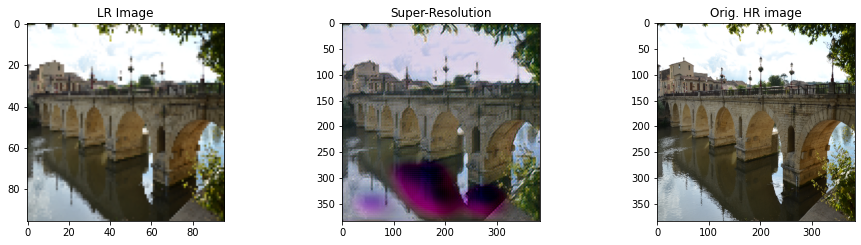

In [ ]:
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Super-Resolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()

In [ ]:
#Peak signal to noise ratio (PSNR)


from math import log10, sqrt

def psnr(ground_truth, sr_result):
    mse = np.mean((ground_truth - sr_result) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


print(psnr(tar_image[0,:,:,:], gen_image[0,:,:,:]))

# #structural similarity index measure
from skimage.metrics import structural_similarity


structural_similarity(tar_image[0,:,:,:], gen_image[0,:,:,:], multichannel = True)



64.06720824829505


0.6233787020134214